# Darmstadt Urban Heat Typology Analysis (H3 index)

Geoff & Avi - 10-26-24
we're trying to understand the affect of different types of 'built environment' on urban heat patterns
starting with data collected from Darmstadt

update - 12 Nov 2024

In [1]:
#import data libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#import geographic analysis libraries
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely as shp
from shapely.geometry import Point
from shapely.geometry import shape
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon
import seaborn as sns
import os
import re
from fiona.crs import from_epsg
import pysal as ps
#set crs for entire analysis
crs = {'init': 'epsg:4326'}
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100

In [2]:
#import machine learning / regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [3]:
# Import for h3 indexing 
import h3
import xarray as xr

In [4]:
# loading darmstadt shapefile
darmstadt_shp = gpd.read_file('../data/Stadtteile/DA_ST_Stadtteile.shp')
darmstadt_shp.to_crs(crs='epsg:4326', inplace=True)
darmstadt_shp

ID  Stadtteil              DAStadttei  \
0  32472        500          Darmstadt-West   
1   3650        700     Darmstadt-Eberstadt   
2   1260        400     Darmstadt-Bessungen   
3    650        100         Darmstadt-Mitte   
4   1300        300           Darmstadt-Ost   
5   1680        200          Darmstadt-Nord   
6   1630        800     Darmstadt-Wixhausen   
7   2500        600    Darmstadt-Arheiligen   
8   1830        900  Darmstadt-Kranichstein   

                                            geometry  
0  POLYGON ((8.63898 49.84548, 8.6377 49.84226, 8...  
1  POLYGON ((8.67249 49.8342, 8.67251 49.83414, 8...  
2  POLYGON ((8.65592 49.8408, 8.65594 49.84072, 8...  
3  POLYGON ((8.66002 49.8646, 8.65915 49.86421, 8...  
4  POLYGON ((8.72912 49.86395, 8.72889 49.86379, ...  
5  POLYGON ((8.66643 49.87859, 8.66634 49.87856, ...  
6  POLYGON ((8.65471 49.92256, 8.65466 49.92257, ...  
7  POLYGON ((8.66312 49.8977, 8.66275 49.89771, 8...  
8  POLYGON ((8.69351 49.89518, 8.69348 49.89517, ...

<Axes: >

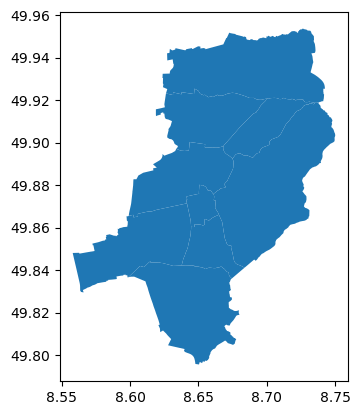

In [5]:
# checking the file
darmstadt_shp.plot()

<Axes: >

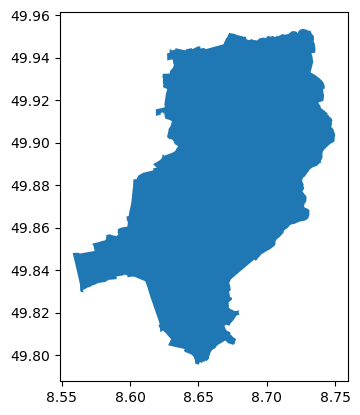

In [6]:
# dissolving districts to get a solid shape
darm_dslv = darmstadt_shp.dissolve()
darm_dslv.plot()

In [7]:
# Get union of the shape (whole darmstadt)
union_poly = unary_union(darmstadt_shp.geometry)
temp = mapping(union_poly)

In [8]:
# Generating H3 index level 8
hexes_8 = h3.polyfill(temp,res=8)
darm_hex_8 = pd.DataFrame(hexes_8,columns=["hex_id"])

In [9]:
# Create hexagon geometry and GeoDataFrame
darm_hex_8['geometry'] = [Polygon(h3.h3_to_geo_boundary(x, geo_json=True)) for x in darm_hex_8["hex_id"]]
darm_hex_8 = gpd.GeoDataFrame(darm_hex_8)
darm_hex_8.shape

(327, 2)

<Axes: >

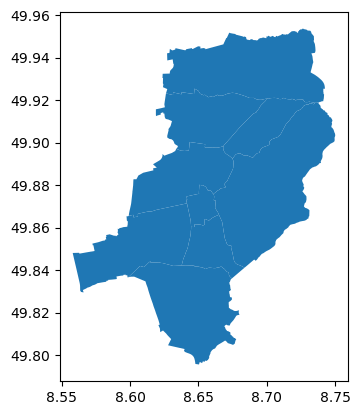

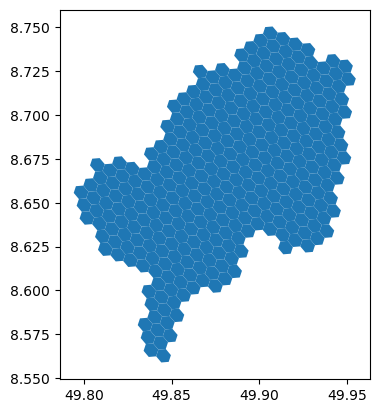

In [10]:
# checking data
darmstadt_shp.plot()
darm_hex_8.plot()

<Axes: >

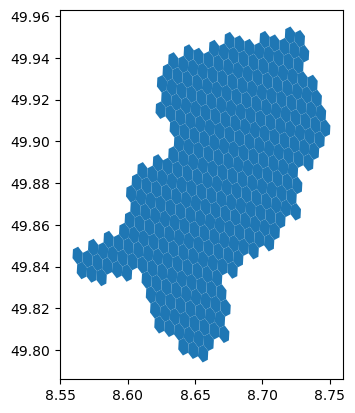

In [11]:
# fixing the coordinates of hexes
darm_hex8_fxd = darm_hex_8.copy()
darm_hex8_fxd['geometry'] = gpd.GeoSeries(darm_hex8_fxd['geometry']).map(
    lambda polygon: shp.ops.transform(lambda x, y: (y, x), polygon))
darm_hex8_fxd.set_crs(crs='epsg:4326', inplace=True)
darm_hex8_fxd.plot()

<Axes: >

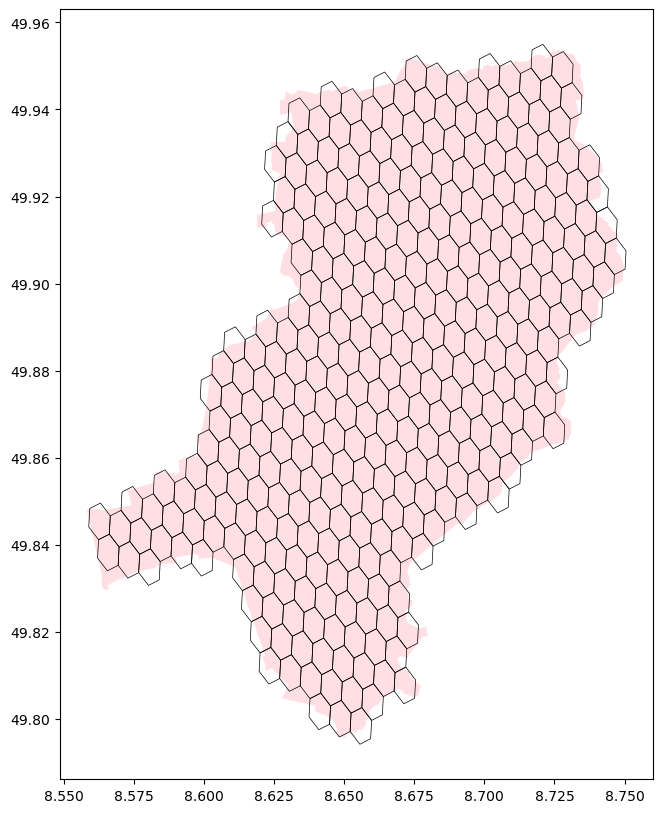

In [12]:
# ploting together to compare
fig, ax = plt.subplots(figsize=(10, 10))

darmstadt_shp.plot(ax=ax, alpha=0.5, color="pink")
darm_hex8_fxd.plot(facecolor="none", edgecolor='black',linewidth=0.5, ax=ax)

In [13]:
# Generating H3 index level 6
hexes_6 = h3.polyfill(temp,res=6)
darm_hex_6 = pd.DataFrame(hexes_6,columns=["hex_id"])

In [14]:
# Create hexagon geometry and GeoDataFrame
darm_hex_6['geometry'] = [Polygon(h3.h3_to_geo_boundary(x, geo_json=True)) for x in darm_hex_6["hex_id"]]
darm_hex_6 = gpd.GeoDataFrame(darm_hex_6)
darm_hex_6.shape

(8, 2)

<Axes: >

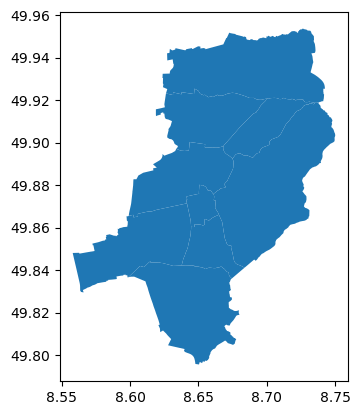

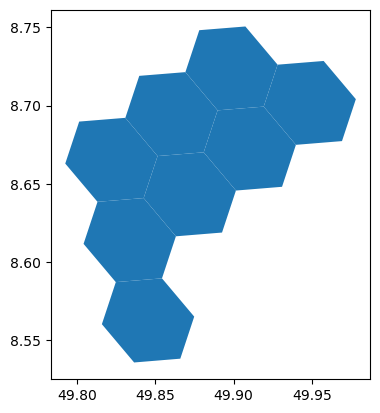

In [15]:
# checking data
darmstadt_shp.plot()
darm_hex_6.plot()

<Axes: >

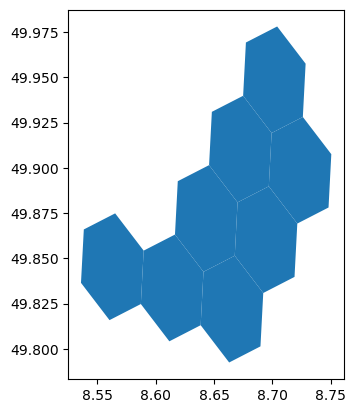

In [16]:
# fixing the coordinates of hexes
darm_hex6_fxd = darm_hex_6.copy()
darm_hex6_fxd['geometry'] = gpd.GeoSeries(darm_hex6_fxd['geometry']).map(
    lambda polygon: shp.ops.transform(lambda x, y: (y, x), polygon))
darm_hex6_fxd.set_crs(crs='epsg:4326', inplace=True)
darm_hex6_fxd.plot()

<Axes: >

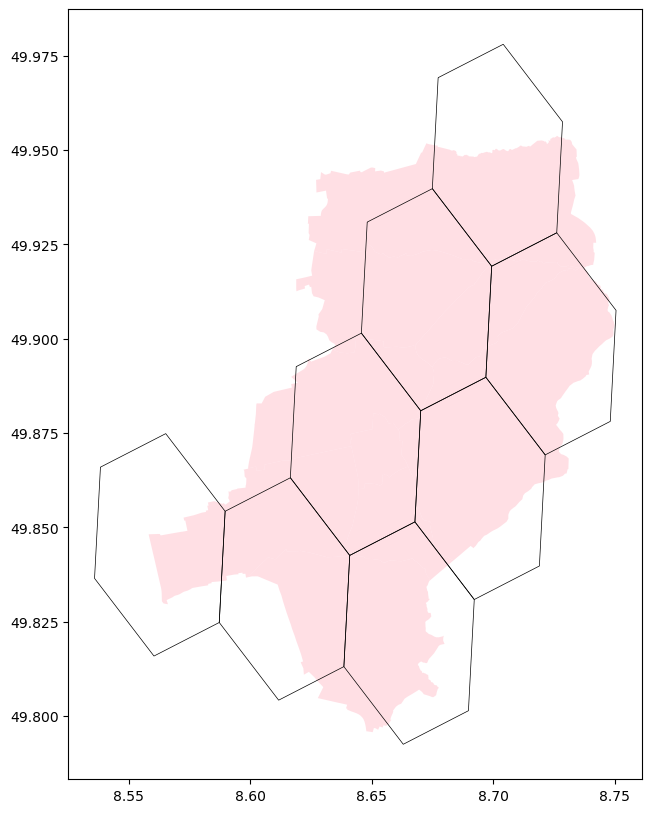

In [17]:
# ploting together to compare
fig, ax = plt.subplots(figsize=(10, 10))
darmstadt_shp.plot(ax=ax, alpha=0.5, color="pink")
darm_hex6_fxd.plot(facecolor="none", edgecolor='black',linewidth=0.5, ax=ax)

In [18]:
# Generating H3 index level 7
hexes_7 = h3.polyfill(temp,res=7)
darm_hex_7 = pd.DataFrame(hexes_7,columns=["hex_id"])

In [19]:
# Create hexagon geometry and GeoDataFrame
darm_hex_7['geometry'] = [Polygon(h3.h3_to_geo_boundary(x, geo_json=True)) for x in darm_hex_7["hex_id"]]
darm_hex_7 = gpd.GeoDataFrame(darm_hex_7)
darm_hex_7.shape

(45, 2)

<Axes: >

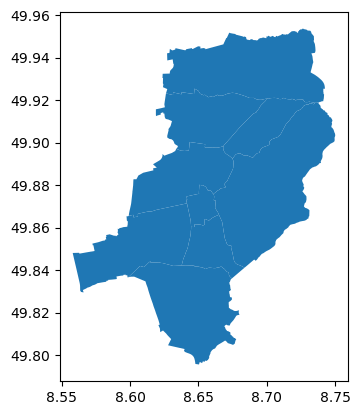

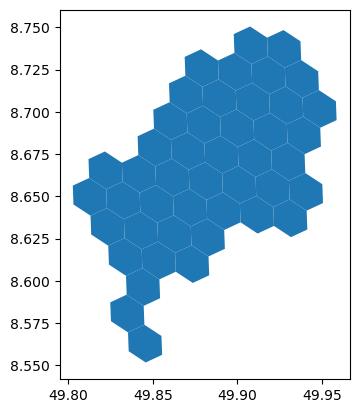

In [20]:
# checking data
darmstadt_shp.plot()
darm_hex_7.plot()

<Axes: >

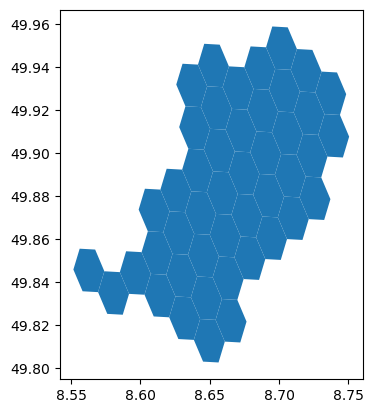

In [21]:
# fixing the coordinates of hexes
darm_hex7_fxd = darm_hex_7.copy()
darm_hex7_fxd['geometry'] = gpd.GeoSeries(darm_hex7_fxd['geometry']).map(
    lambda polygon: shp.ops.transform(lambda x, y: (y, x), polygon))
darm_hex7_fxd.set_crs(crs='epsg:4326', inplace=True)
darm_hex7_fxd.plot()

<Axes: >

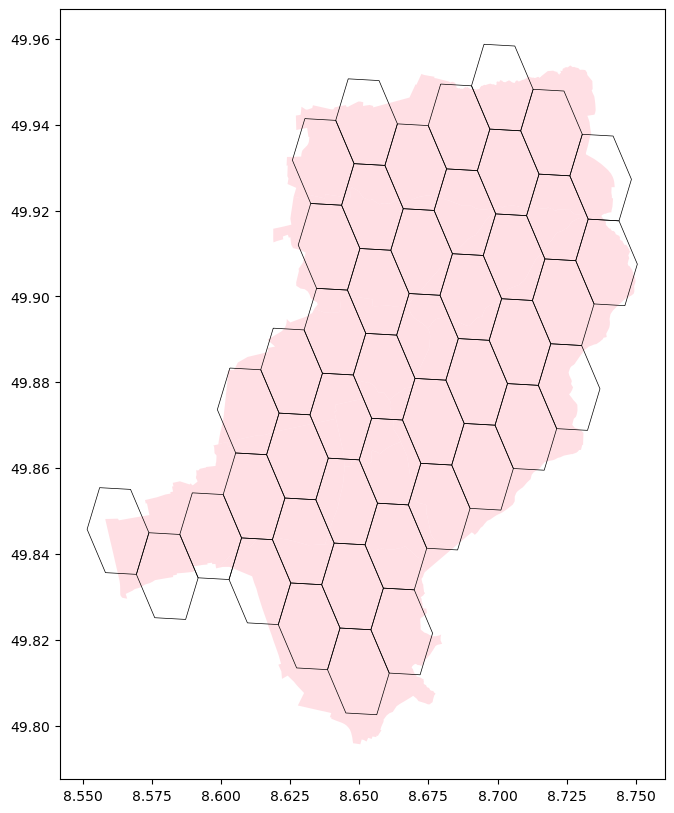

In [22]:
# ploting together to compare
fig, ax = plt.subplots(figsize=(10, 10))
darmstadt_shp.plot(ax=ax, alpha=0.5, color="pink")
darm_hex7_fxd.plot(facecolor="none", edgecolor='black',linewidth=0.5, ax=ax)

In [23]:
# Generating H3 index level 9
hexes_9 = h3.polyfill(temp,res=9)
darm_hex_9 = pd.DataFrame(hexes_9,columns=["hex_id"])

In [24]:
# Create hexagon geometry and GeoDataFrame
darm_hex_9['geometry'] = [Polygon(h3.h3_to_geo_boundary(x, geo_json=True)) for x in darm_hex_9["hex_id"]]
darm_hex_9 = gpd.GeoDataFrame(darm_hex_9)
darm_hex_9.shape

(2278, 2)

<Axes: >

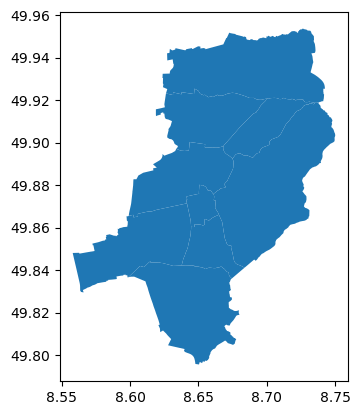

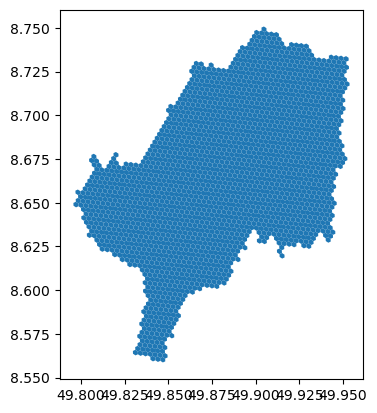

In [25]:
# checking data
darmstadt_shp.plot()
darm_hex_9.plot()

<Axes: >

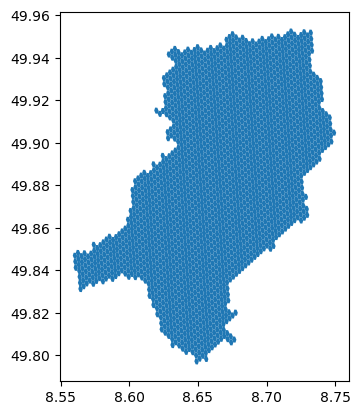

In [26]:
# fixing the coordinates of hexes
darm_hex9_fxd = darm_hex_9.copy()
darm_hex9_fxd['geometry'] = gpd.GeoSeries(darm_hex9_fxd['geometry']).map(
    lambda polygon: shp.ops.transform(lambda x, y: (y, x), polygon))
darm_hex9_fxd.set_crs(crs='epsg:4326', inplace=True)
darm_hex9_fxd.plot()

<Axes: >

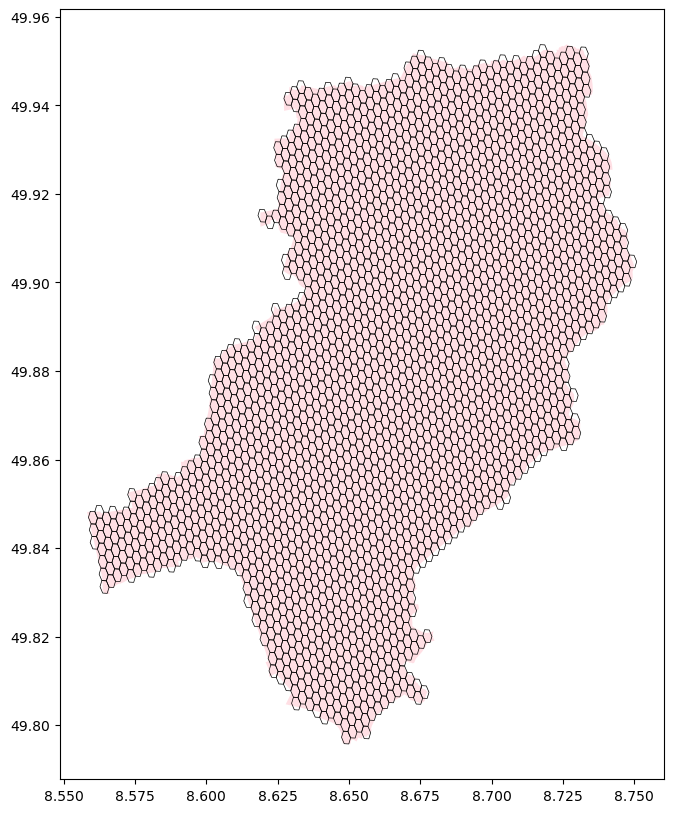

In [27]:
# ploting together to compare
fig, ax = plt.subplots(figsize=(10, 10))
darmstadt_shp.plot(ax=ax, alpha=0.5, color="pink")
darm_hex9_fxd.plot(facecolor="none", edgecolor='black',linewidth=0.5, ax=ax)

<Axes: >

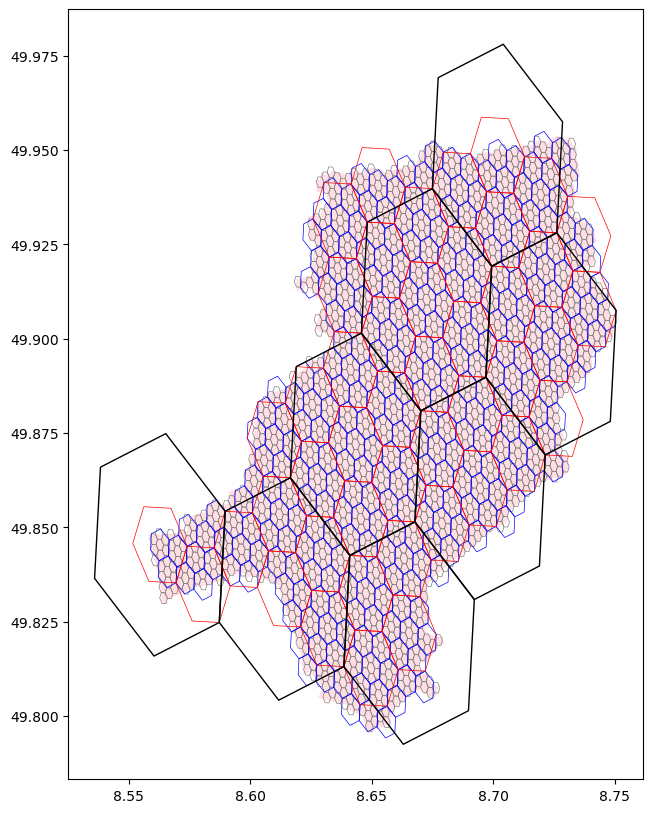

In [28]:
# ploting together to compare
fig, ax = plt.subplots(figsize=(10, 10))

darmstadt_shp.plot(ax=ax, alpha=0.5, color="pink")
darm_hex9_fxd.plot(facecolor="none", edgecolor='grey',linewidth=0.5, ax=ax)
darm_hex8_fxd.plot(facecolor="none", edgecolor='b',linewidth=0.5, ax=ax)
darm_hex7_fxd.plot(facecolor="none", edgecolor='r',linewidth=0.5, ax=ax)
darm_hex6_fxd.plot(facecolor="none", edgecolor='black',linewidth=1, ax=ax)

In [29]:
# loading darmstadt typology shapefile
typology_shp = gpd.read_file('../data/darmstadt_typologies/Darmstadt_typologies_20240506.shp')
typology_shp.to_crs(crs='epsg:4326', inplace=True)
typology_shp.head()

Entity Handle            Layer  LyrFrzn  LyrOn  Color    Linetype  \
0  2DPolyline     75  EST2_row_houses        0      1    233  Continuous   
1  2DPolyline     7B  EST2_row_houses        0      1    233  Continuous   
2  2DPolyline     83  EST2_row_houses        0      1    233  Continuous   
3  2DPolyline     B9  EST2_row_houses        0      1    233  Continuous   
4  2DPolyline     E2  EST2_row_houses        0      1    233  Continuous   

   Elevation  LineWt RefName  DocUpdate         DocId  GlobalWidt  Shape_Leng  \
0        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.675722   
1        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.049873   
2        0.0      70    None 2024-04-25  7.282236e+18         0.0  293.058103   
3        0.0      70    None 2024-04-25  7.282236e+18         0.0  464.264058   
4        0.0      70    None 2024-04-25  7.282236e+18         0.0  209.471486   

    Shape_Area                                           geometry  
0  1129.031176  POLYGON Z ((8.68101 49.88422 0, 8.68145 49.884...  
1   958.035347  POLYGON Z ((8.63622 49.84828 0, 8.63613 49.848...  
2  4334.274022  POLYGON Z ((8.68164 49.87173 0, 8.68161 49.871...  
3  2217.779077  POLYGON Z ((8.61997 49.87457 0, 8.62004 49.874...  
4  2371.092222  POLYGON Z ((8.61871 49.87453 0, 8.61876 49.874...

<Axes: >

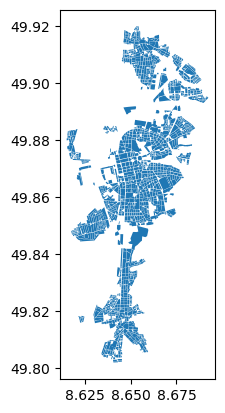

In [30]:
typology_shp.plot()

<Axes: >

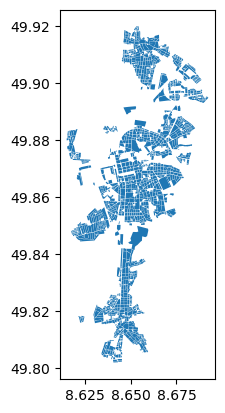

In [31]:
# dropping EST14 
typology_shp.drop(typology_shp[typology_shp.Layer == 'EST14_single_element'].index, inplace=True)
typology_shp.plot()

<Axes: >

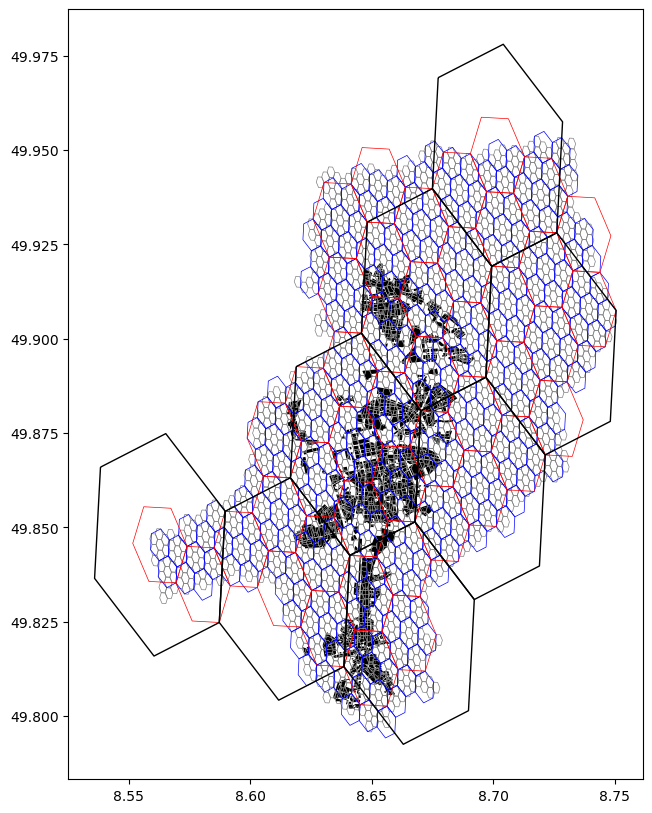

In [32]:
# ploting together to compare
fig, ax = plt.subplots(figsize=(10, 10))

typology_shp.plot(ax=ax, alpha=1, color="black")
darm_hex9_fxd.plot(facecolor="none", edgecolor='grey',linewidth=0.5, ax=ax)
darm_hex8_fxd.plot(facecolor="none", edgecolor='b',linewidth=0.5, ax=ax)
darm_hex7_fxd.plot(facecolor="none", edgecolor='r',linewidth=0.5, ax=ax)
darm_hex6_fxd.plot(facecolor="none", edgecolor='black',linewidth=1, ax=ax)

In [33]:
# joining hex9 with typologies
darm_typ_w_hex9 = typology_shp.overlay(darm_hex9_fxd, how='intersection')
darm_typ_w_hex9

Entity Handle                  Layer  LyrFrzn  LyrOn  Color  \
0     2DPolyline     75        EST2_row_houses        0      1    233   
1     2DPolyline     75        EST2_row_houses        0      1    233   
2     2DPolyline     7B        EST2_row_houses        0      1    233   
3     2DPolyline     7B        EST2_row_houses        0      1    233   
4     2DPolyline     83        EST2_row_houses        0      1    233   
...          ...    ...                    ...      ...    ...    ...   
3611  2DPolyline   ACA2  EST1A_detached_houses        0      1     80   
3612  2DPolyline   ACA2  EST1A_detached_houses        0      1     80   
3613  2DPolyline   ACAE  EST13_alloment_garden        0      1    104   
3614  2DPolyline   ACAE  EST13_alloment_garden        0      1    104   
3615  2DPolyline   ACAE  EST13_alloment_garden        0      1    104   

        Linetype  Elevation  LineWt RefName  DocUpdate         DocId  \
0     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
2     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
3     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
4     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
...          ...        ...     ...     ...        ...           ...   
3611  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
3612  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
3613  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
3614  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
3615  Continuous        0.0      70    None 2024-04-25  7.282236e+18   

      GlobalWidt  Shape_Leng   Shape_Area           hex_id  \
0            0.0  134.675722  1129.031176  8963926d96fffff   
1            0.0  134.675722  1129.031176  897a932992bffff   
2            0.0  134.049873   958.035347  897a932f24bffff   
3            0.0  134.049873   958.035347  897a932f24fffff   
4            0.0  293.058103  4334.274022  8963926dbbbffff   
...          ...         ...          ...              ...   
3611         0.0  398.907877  5770.432809  897a9329ca3ffff   
3612         0.0  398.907877  5770.432809  897a9329cafffff   
3613         0.0  315.622840  4107.587936  897a9329b9bffff   
3614         0.0  315.622840  4107.587936  897a9329bd7ffff   
3615         0.0  315.622840  4107.587936  897a932986fffff   

                                               geometry  
0     POLYGON Z ((8.68158 49.88403 0, 8.6813 49.8839...  
1     POLYGON Z ((8.68145 49.88433 0, 8.68146 49.884...  
2     POLYGON Z ((8.63613 49.84852 0, 8.63646 49.848...  
3     POLYGON Z ((8.6362 49.84834 0, 8.63655 49.8483...  
4     POLYGON Z ((8.68065 49.87212 0, 8.68067 49.872...  
...                                                 ...  
3611  POLYGON Z ((8.65118 49.91536 0, 8.65097 49.915...  
3612  POLYGON Z ((8.6521 49.915 0, 8.65204 49.91502 ...  
3613  POLYGON Z ((8.68334 49.90574 0, 8.68334 49.905...  
3614  POLYGON Z ((8.68355 49.90591 0, 8.68492 49.905...  
3615  POLYGON Z ((8.68334 49.90574 0, 8.68334 49.905...  

[3616 rows x 17 columns]

<Axes: >

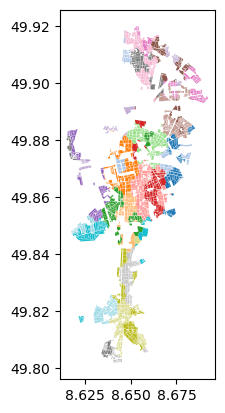

In [34]:
darm_typ_w_hex9.plot(column='hex_id', cmap='tab20')

In [35]:
# computing areas of sliced typ in m2
typ9_ar = darm_typ_w_hex9.copy()
typ9_ar.to_crs(crs='epsg:32632', inplace=True)
typ9_ar["typ_area"] = typ9_ar['geometry'].area
typ9_ar.head()

Entity Handle            Layer  LyrFrzn  LyrOn  Color    Linetype  \
0  2DPolyline     75  EST2_row_houses        0      1    233  Continuous   
1  2DPolyline     75  EST2_row_houses        0      1    233  Continuous   
2  2DPolyline     7B  EST2_row_houses        0      1    233  Continuous   
3  2DPolyline     7B  EST2_row_houses        0      1    233  Continuous   
4  2DPolyline     83  EST2_row_houses        0      1    233  Continuous   

   Elevation  LineWt RefName  DocUpdate         DocId  GlobalWidt  Shape_Leng  \
0        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.675722   
1        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.675722   
2        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.049873   
3        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.049873   
4        0.0      70    None 2024-04-25  7.282236e+18         0.0  293.058103   

    Shape_Area           hex_id  \
0  1129.031176  8963926d96fffff   
1  1129.031176  897a932992bffff   
2   958.035347  897a932f24bffff   
3   958.035347  897a932f24fffff   
4  4334.274022  8963926dbbbffff   

                                            geometry     typ_area  
0  POLYGON Z ((477124.972 5525785.102 0, 477104.5...   358.094407  
1  POLYGON Z ((477115.778 5525819.226 0, 477116.1...   770.937164  
2  POLYGON Z ((473840.974 5521852.143 0, 473864.3...   572.859351  
3  POLYGON Z ((473845.593 5521832.46 0, 473870.66...   385.175696  
4  POLYGON Z ((477052.805 5524461.332 0, 477054.3...  1947.588487

In [36]:
# grouping the data as per hex9 and typology
darm_typ_w_hex9_grp = typ9_ar.groupby(['hex_id','Layer'], as_index=False)['typ_area'].sum()
darm_typ_w_hex9_grp.head()

hex_id                  Layer      typ_area
0  8963926d967ffff  EST1A_detached_houses   5998.331649
1  8963926d967ffff  EST1B_detached_houses     70.591067
2  8963926d967ffff        EST2_row_houses   6825.110809
3  8963926d96bffff  EST1A_detached_houses     48.627892
4  8963926d96fffff  EST1A_detached_houses  11806.381376

In [37]:
# reorganising the data into usage format
pit9 = darm_typ_w_hex9_grp.pivot(index=['hex_id'], columns='Layer', values='typ_area')
pit9.head()

Layer            EST11_park  EST12_cemetary  EST13_alloment_garden  \
hex_id                                                               
8963926d967ffff         NaN             NaN                    NaN   
8963926d96bffff         NaN             NaN                    NaN   
8963926d96fffff         NaN             NaN                    NaN   
8963926da2bffff         NaN             NaN             334.173365   
8963926da2fffff         NaN             NaN                    NaN   

Layer            EST1A_detached_houses  EST1B_detached_houses  \
hex_id                                                          
8963926d967ffff            5998.331649              70.591067   
8963926d96bffff              48.627892                    NaN   
8963926d96fffff           11806.381376            7838.689081   
8963926da2bffff            4867.465639                    NaN   
8963926da2fffff                    NaN                    NaN   

Layer            EST2_row_houses  EST3_row_structures_with_low_density  \
hex_id                                                                   
8963926d967ffff      6825.110809                                   NaN   
8963926d96bffff              NaN                                   NaN   
8963926d96fffff     11650.211475                                   NaN   
8963926da2bffff              NaN                                   NaN   
8963926da2fffff              NaN                           5182.624977   

Layer            EST4_row_structures_with_high_density  EST5_block_structures  \
hex_id                                                                          
8963926d967ffff                                    NaN                    NaN   
8963926d96bffff                                    NaN                    NaN   
8963926d96fffff                                    NaN                    NaN   
8963926da2bffff                                    NaN                    NaN   
8963926da2fffff                                    NaN                    NaN   

Layer            EST6_rural_houses  EST7_historic_centre  EST8_city_centre  
hex_id                                                                      
8963926d967ffff                NaN                   NaN               NaN  
8963926d96bffff                NaN                   NaN               NaN  
8963926d96fffff                NaN                   NaN               NaN  
8963926da2bffff                NaN                   NaN               NaN  
8963926da2fffff                NaN                   NaN               NaN

In [38]:
# computing areas of hex9 in m2
hex9_ar = darm_hex9_fxd.copy()
hex9_ar.to_crs(crs='epsg:32632', inplace=True)
hex9_ar["hex_area"] = hex9_ar['geometry'].area
hex9_ar.head()

hex_id                                           geometry  \
0  8963926c983ffff  POLYGON ((480472.074 5529569.459, 480586.271 5...   
1  897a9328833ffff  POLYGON ((474343.391 5523994.044, 474457.879 5...   
2  8963926d823ffff  POLYGON ((477756.529 5524101.347, 477870.939 5...   
3  897a9321b8fffff  POLYGON ((469427.564 5520535.122, 469542.257 5...   
4  897a93299bbffff  POLYGON ((476240.706 5526383.157, 476355.085 5...   

       hex_area  
0  53564.044975  
1  53764.230823  
2  53712.220022  
3  53904.828285  
4  53689.071394

In [39]:
pit9 = pit9.merge(hex9_ar, on='hex_id')
pit9.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8963926d967ffff         NaN             NaN                    NaN   
1  8963926d96bffff         NaN             NaN                    NaN   
2  8963926d96fffff         NaN             NaN                    NaN   
3  8963926da2bffff         NaN             NaN             334.173365   
4  8963926da2fffff         NaN             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0            5998.331649              70.591067      6825.110809   
1              48.627892                    NaN              NaN   
2           11806.381376            7838.689081     11650.211475   
3            4867.465639                    NaN              NaN   
4                    NaN                    NaN              NaN   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                           5182.624977   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                                    NaN                    NaN   
3                                    NaN                    NaN   
4                                    NaN                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry      hex_area  
0  POLYGON ((477290.493 5526006.948, 477404.859 5...  53681.204005  
1  POLYGON ((477149.611 5525546.057, 477263.994 5...  53692.410698  
2  POLYGON ((477129.162 5525860.206, 477243.537 5...  53686.473523  
3  POLYGON ((476465.019 5522926.877, 476579.491 5...  53754.404812  
4  POLYGON ((476444.618 5523241.14, 476559.081 55...  53748.464832

In [40]:
pit9.to_excel('../data/results/hex_9_w_typ_area.xlsx')

In [41]:
# joining hex8 with typologies
darm_typ_w_hex8 = typology_shp.overlay(darm_hex8_fxd, how='intersection')
darm_typ_w_hex8

Entity Handle                  Layer  LyrFrzn  LyrOn  Color  \
0     2DPolyline     75        EST2_row_houses        0      1    233   
1     2DPolyline     75        EST2_row_houses        0      1    233   
2     2DPolyline     7B        EST2_row_houses        0      1    233   
3     2DPolyline     83        EST2_row_houses        0      1    233   
4     2DPolyline     83        EST2_row_houses        0      1    233   
...          ...    ...                    ...      ...    ...    ...   
2456  2DPolyline   AC93      EST6_rural_houses        0      1     32   
2457  2DPolyline   ACA2  EST1A_detached_houses        0      1     80   
2458  2DPolyline   ACAE  EST13_alloment_garden        0      1    104   
2459  2DPolyline   ACAE  EST13_alloment_garden        0      1    104   
2460  2DPolyline   ACAE  EST13_alloment_garden        0      1    104   

        Linetype  Elevation  LineWt RefName  DocUpdate         DocId  \
0     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
2     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
3     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
4     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
...          ...        ...     ...     ...        ...           ...   
2456  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
2457  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
2458  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
2459  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
2460  Continuous        0.0      70    None 2024-04-25  7.282236e+18   

      GlobalWidt  Shape_Leng    Shape_Area           hex_id  \
0            0.0  134.675722   1129.031176  887a932993fffff   
1            0.0  134.675722   1129.031176  8863926d97fffff   
2            0.0  134.049873    958.035347  887a932f25fffff   
3            0.0  293.058103   4334.274022  8863926dbbfffff   
4            0.0  293.058103   4334.274022  8863926db9fffff   
...          ...         ...           ...              ...   
2456         0.0  438.854341  10286.208752  887a9329cbfffff   
2457         0.0  398.907877   5770.432809  887a9329cbfffff   
2458         0.0  315.622840   4107.587936  887a9329b9fffff   
2459         0.0  315.622840   4107.587936  887a9329bdfffff   
2460         0.0  315.622840   4107.587936  887a932987fffff   

                                               geometry  
0     POLYGON Z ((8.68145 49.88433 0, 8.68158 49.884...  
1     POLYGON Z ((8.68158 49.88403 0, 8.68158 49.884...  
2     POLYGON Z ((8.63613 49.84852 0, 8.63646 49.848...  
3     POLYGON Z ((8.68065 49.87212 0, 8.68067 49.872...  
4     POLYGON Z ((8.68161 49.87173 0, 8.68131 49.871...  
...                                                 ...  
2456  POLYGON Z ((8.65207 49.91479 0, 8.65202 49.914...  
2457  POLYGON Z ((8.6521 49.915 0, 8.65118 49.91536 ...  
2458  POLYGON Z ((8.68334 49.90574 0, 8.68334 49.905...  
2459  POLYGON Z ((8.68355 49.90591 0, 8.68492 49.905...  
2460  POLYGON Z ((8.68334 49.90574 0, 8.68334 49.905...  

[2461 rows x 17 columns]

<Axes: >

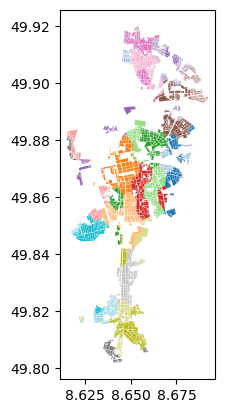

In [42]:
darm_typ_w_hex8.plot(column='hex_id', cmap='tab20')

In [43]:
# computing areas of sliced typ in m2
typ8_ar = darm_typ_w_hex8.copy()
typ8_ar.to_crs(crs='epsg:32632', inplace=True)
typ8_ar["typ_area"] = typ8_ar['geometry'].area
typ8_ar.head()

Entity Handle            Layer  LyrFrzn  LyrOn  Color    Linetype  \
0  2DPolyline     75  EST2_row_houses        0      1    233  Continuous   
1  2DPolyline     75  EST2_row_houses        0      1    233  Continuous   
2  2DPolyline     7B  EST2_row_houses        0      1    233  Continuous   
3  2DPolyline     83  EST2_row_houses        0      1    233  Continuous   
4  2DPolyline     83  EST2_row_houses        0      1    233  Continuous   

   Elevation  LineWt RefName  DocUpdate         DocId  GlobalWidt  Shape_Leng  \
0        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.675722   
1        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.675722   
2        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.049873   
3        0.0      70    None 2024-04-25  7.282236e+18         0.0  293.058103   
4        0.0      70    None 2024-04-25  7.282236e+18         0.0  293.058103   

    Shape_Area           hex_id  \
0  1129.031176  887a932993fffff   
1  1129.031176  8863926d97fffff   
2   958.035347  887a932f25fffff   
3  4334.274022  8863926dbbfffff   
4  4334.274022  8863926db9fffff   

                                            geometry     typ_area  
0  POLYGON Z ((477115.778 5525819.226 0, 477124.9...  1129.023501  
1  POLYGON Z ((477124.972 5525785.102 0, 477124.9...     0.007672  
2  POLYGON Z ((473840.974 5521852.143 0, 473864.3...   958.035347  
3  POLYGON Z ((477052.805 5524461.332 0, 477054.3...   511.502270  
4  POLYGON Z ((477120.999 5524418.192 0, 477099.4...  3822.771745

In [44]:
# grouping the data as per hex8 and typology
darm_typ_w_hex8_grp = typ8_ar.groupby(['hex_id','Layer'], as_index=False)['typ_area'].sum()
darm_typ_w_hex8_grp.head()

hex_id                  Layer      typ_area
0  8863926d97fffff  EST1A_detached_houses  16621.459801
1  8863926d97fffff  EST1B_detached_houses   7528.525549
2  8863926d97fffff        EST2_row_houses  19959.579969
3  8863926d97fffff      EST6_rural_houses    625.885335
4  8863926da3fffff  EST13_alloment_garden      1.402865

In [45]:
# reorganising the data into usage format
pit8 = darm_typ_w_hex8_grp.pivot(index=['hex_id'], columns='Layer', values='typ_area')
pit8.head()

Layer            EST11_park  EST12_cemetary  EST13_alloment_garden  \
hex_id                                                               
8863926d97fffff         NaN             NaN                    NaN   
8863926da3fffff         NaN             NaN               1.402865   
8863926da7fffff         NaN             NaN           35070.086609   
8863926db1fffff         NaN             NaN                    NaN   
8863926db3fffff  922.635324             NaN                    NaN   

Layer            EST1A_detached_houses  EST1B_detached_houses  \
hex_id                                                          
8863926d97fffff           16621.459801            7528.525549   
8863926da3fffff            4498.292880                    NaN   
8863926da7fffff           20132.740288                    NaN   
8863926db1fffff           79437.891126                    NaN   
8863926db3fffff          153723.033194                    NaN   

Layer            EST2_row_houses  EST3_row_structures_with_low_density  \
hex_id                                                                   
8863926d97fffff     19959.579969                                   NaN   
8863926da3fffff              NaN                           6444.983305   
8863926da7fffff     12414.954370                          14241.108956   
8863926db1fffff      9377.362093                          16481.289669   
8863926db3fffff      1692.195626                           8021.713419   

Layer            EST4_row_structures_with_high_density  EST5_block_structures  \
hex_id                                                                          
8863926d97fffff                                    NaN                    NaN   
8863926da3fffff                                    NaN                    NaN   
8863926da7fffff                            2172.225783                    NaN   
8863926db1fffff                            5034.614558                    NaN   
8863926db3fffff                                    NaN           13752.752536   

Layer            EST6_rural_houses  EST7_historic_centre  EST8_city_centre  
hex_id                                                                      
8863926d97fffff         625.885335                   NaN               NaN  
8863926da3fffff                NaN                   NaN               NaN  
8863926da7fffff                NaN                   NaN               NaN  
8863926db1fffff                NaN                   NaN               NaN  
8863926db3fffff                NaN                   NaN               NaN

In [46]:
# computing areas of hex8 in m2
hex8_ar = darm_hex8_fxd.copy()
hex8_ar.to_crs(crs='epsg:32632', inplace=True)
hex8_ar["hex_area"] = hex8_ar['geometry'].area
hex8_ar.head()

hex_id                                           geometry  \
0  887a932d51fffff  POLYGON ((474546.265 5518188.275, 474822.735 5...   
1  887a932d5bfffff  POLYGON ((474242.794 5517579.941, 474519.335 5...   
2  887a9328abfffff  POLYGON ((474949.116 5525209.456, 475225.059 5...   
3  887a932ab5fffff  POLYGON ((472020.071 5525544.125, 472296.257 5...   
4  887a932889fffff  POLYGON ((473595.84 5524978.535, 473871.922 55...   

        hex_area  
0  377140.321190  
1  377255.932855  
2  376123.399625  
3  376376.609191  
4  376293.961429

In [47]:
pit8 = pit8.merge(hex8_ar, on='hex_id')
pit8.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8863926d97fffff         NaN             NaN                    NaN   
1  8863926da3fffff         NaN             NaN               1.402865   
2  8863926da7fffff         NaN             NaN           35070.086609   
3  8863926db1fffff         NaN             NaN                    NaN   
4  8863926db3fffff  922.635324             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           16621.459801            7528.525549     19959.579969   
1            4498.292880                    NaN              NaN   
2           20132.740288                    NaN     12414.954370   
3           79437.891126                    NaN      9377.362093   
4          153723.033194                    NaN      1692.195626   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                           6444.983305   
2                          14241.108956   
3                          16481.289669   
4                           8021.713419   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                            2172.225783                    NaN   
3                            5034.614558                    NaN   
4                                    NaN           13752.752536   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         625.885335                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry       hex_area  
0  POLYGON ((477129.162 5525860.206, 477404.859 5...  375809.985090  
1  POLYGON ((476444.618 5523241.14, 476720.562 55...  376243.911556  
2  POLYGON ((476141.968 5522633.251, 476417.982 5...  376359.341929  
3  POLYGON ((476524.472 5524644.846, 476800.31 55...  376040.701582  
4  POLYGON ((476301.86 5525440.669, 476577.663 55...  375952.890176

In [48]:
pit8.to_excel('../data/results/hex_8_w_typ_area.xlsx')

In [49]:
# joining hex7 with typologies
darm_typ_w_hex7 = typology_shp.overlay(darm_hex7_fxd, how='intersection')
darm_typ_w_hex7

Entity Handle                  Layer  LyrFrzn  LyrOn  Color  \
0     2DPolyline     75        EST2_row_houses        0      1    233   
1     2DPolyline     7B        EST2_row_houses        0      1    233   
2     2DPolyline     83        EST2_row_houses        0      1    233   
3     2DPolyline     B9        EST2_row_houses        0      1    233   
4     2DPolyline     B9        EST2_row_houses        0      1    233   
...          ...    ...                    ...      ...    ...    ...   
1981  2DPolyline   AC84  EST1A_detached_houses        0      1     80   
1982  2DPolyline   AC84  EST1A_detached_houses        0      1     80   
1983  2DPolyline   AC93      EST6_rural_houses        0      1     32   
1984  2DPolyline   ACA2  EST1A_detached_houses        0      1     80   
1985  2DPolyline   ACAE  EST13_alloment_garden        0      1    104   

        Linetype  Elevation  LineWt RefName  DocUpdate         DocId  \
0     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
2     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
3     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
4     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
...          ...        ...     ...     ...        ...           ...   
1981  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1982  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1983  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1984  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1985  Continuous        0.0      70    None 2024-04-25  7.282236e+18   

      GlobalWidt  Shape_Leng    Shape_Area           hex_id  \
0            0.0  134.675722   1129.031176  877a93299ffffff   
1            0.0  134.049873    958.035347  877a932f2ffffff   
2            0.0  293.058103   4334.274022  8763926dbffffff   
3            0.0  464.264058   2217.779077  877a9328cffffff   
4            0.0  464.264058   2217.779077  877a932abffffff   
...          ...         ...           ...              ...   
1981         0.0  531.244247   7116.873859  877a93283ffffff   
1982         0.0  531.244247   7116.873859  877a9329cffffff   
1983         0.0  438.854341  10286.208752  877a9329cffffff   
1984         0.0  398.907877   5770.432809  877a9329cffffff   
1985         0.0  315.622840   4107.587936  877a9329bffffff   

                                               geometry  
0     POLYGON Z ((8.68145 49.88433 0, 8.68158 49.884...  
1     POLYGON Z ((8.63613 49.84852 0, 8.63646 49.848...  
2     POLYGON Z ((8.68161 49.87173 0, 8.68131 49.871...  
3     POLYGON Z ((8.62004 49.87458 0, 8.62012 49.874...  
4     POLYGON Z ((8.61995 49.87439 0, 8.61994 49.874...  
...                                                 ...  
1981  POLYGON Z ((8.64716 49.91423 0, 8.6477 49.9141...  
1982  POLYGON Z ((8.64893 49.91402 0, 8.65016 49.913...  
1983  POLYGON Z ((8.65207 49.91479 0, 8.65202 49.914...  
1984  POLYGON Z ((8.6521 49.915 0, 8.65118 49.91536 ...  
1985  POLYGON Z ((8.68355 49.90591 0, 8.68492 49.905...  

[1986 rows x 17 columns]

<Axes: >

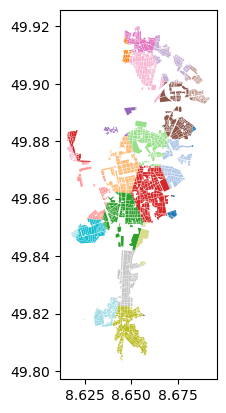

In [50]:
darm_typ_w_hex7.plot(column='hex_id', cmap='tab20')

In [51]:
# computing areas of sliced typ in m2
typ7_ar = darm_typ_w_hex7.copy()
typ7_ar.to_crs(crs='epsg:32632', inplace=True)
typ7_ar["typ_area"] = typ7_ar['geometry'].area
typ7_ar.head()

Entity Handle            Layer  LyrFrzn  LyrOn  Color    Linetype  \
0  2DPolyline     75  EST2_row_houses        0      1    233  Continuous   
1  2DPolyline     7B  EST2_row_houses        0      1    233  Continuous   
2  2DPolyline     83  EST2_row_houses        0      1    233  Continuous   
3  2DPolyline     B9  EST2_row_houses        0      1    233  Continuous   
4  2DPolyline     B9  EST2_row_houses        0      1    233  Continuous   

   Elevation  LineWt RefName  DocUpdate         DocId  GlobalWidt  Shape_Leng  \
0        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.675722   
1        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.049873   
2        0.0      70    None 2024-04-25  7.282236e+18         0.0  293.058103   
3        0.0      70    None 2024-04-25  7.282236e+18         0.0  464.264058   
4        0.0      70    None 2024-04-25  7.282236e+18         0.0  464.264058   

    Shape_Area           hex_id  \
0  1129.031176  877a93299ffffff   
1   958.035347  877a932f2ffffff   
2  4334.274022  8763926dbffffff   
3  2217.779077  877a9328cffffff   
4  2217.779077  877a932abffffff   

                                            geometry     typ_area  
0  POLYGON Z ((477115.778 5525819.226 0, 477124.9...  1129.031176  
1  POLYGON Z ((473840.974 5521852.143 0, 473864.3...   958.035347  
2  POLYGON Z ((477120.999 5524418.192 0, 477099.4...  4334.274022  
3  POLYGON Z ((472698.917 5524755.162 0, 472704.6...   858.389876  
4  POLYGON Z ((472692.155 5524733.937 0, 472691.4...  1359.389201

In [52]:
# grouping the data as per hex7 and typology
darm_typ_w_hex7_grp = typ7_ar.groupby(['hex_id','Layer'], as_index=False)['typ_area'].sum()
darm_typ_w_hex7_grp.head()

hex_id                  Layer      typ_area
0  8763926d9ffffff  EST1A_detached_houses  10882.197440
1  8763926d9ffffff  EST1B_detached_houses   4215.258953
2  8763926d9ffffff        EST2_row_houses   9700.352304
3  8763926daffffff  EST13_alloment_garden  35071.489564
4  8763926daffffff  EST1A_detached_houses  18563.273944

In [53]:
# reorganising the data into usage format
pit7 = darm_typ_w_hex7_grp.pivot(index=['hex_id'], columns='Layer', values='typ_area')
pit7.head()

Layer             EST11_park  EST12_cemetary  EST13_alloment_garden  \
hex_id                                                                
8763926d9ffffff          NaN             NaN                    NaN   
8763926daffffff          NaN             NaN           35071.489564   
8763926dbffffff  2184.358476    24387.049186                    NaN   
877a93283ffffff          NaN             NaN                    NaN   
877a93288ffffff  9881.342029             NaN                    NaN   

Layer            EST1A_detached_houses  EST1B_detached_houses  \
hex_id                                                          
8763926d9ffffff           10882.197440            4215.258953   
8763926daffffff           18563.273944                    NaN   
8763926dbffffff          483684.259578            3209.713330   
877a93283ffffff           19025.514696             152.324029   
877a93288ffffff           36273.401777           28137.885941   

Layer            EST2_row_houses  EST3_row_structures_with_low_density  \
hex_id                                                                   
8763926d9ffffff      9700.352304                                   NaN   
8763926daffffff      8359.014671                          19423.655239   
8763926dbffffff     20795.953564                          73978.330549   
877a93283ffffff     52366.232480                          42133.740240   
877a93288ffffff     24410.374269                         272346.726067   

Layer            EST4_row_structures_with_high_density  EST5_block_structures  \
hex_id                                                                          
8763926d9ffffff                                    NaN                    NaN   
8763926daffffff                            2172.225783                    NaN   
8763926dbffffff                           14915.682503          122973.167321   
877a93283ffffff                                    NaN                    NaN   
877a93288ffffff                            6901.611633          292124.265546   

Layer            EST6_rural_houses  EST7_historic_centre  EST8_city_centre  
hex_id                                                                      
8763926d9ffffff                NaN                   NaN               NaN  
8763926daffffff                NaN                   NaN               NaN  
8763926dbffffff                NaN                   NaN               NaN  
877a93283ffffff                NaN                   NaN               NaN  
877a93288ffffff       25460.653446           2203.494021      337451.38577

In [54]:
# computing areas of hex7 in m2
hex7_ar = darm_hex7_fxd.copy()
hex7_ar.to_crs(crs='epsg:32632', inplace=True)
hex7_ar["hex_area"] = hex7_ar['geometry'].area
hex7_ar.head()

hex_id                                           geometry  \
0  877a93669ffffff  POLYGON ((478272.414 5531890.479, 479071.62 55...   
1  877a9329dffffff  POLYGON ((474887.434 5528811.826, 475687.767 5...   
2  877a93299ffffff  POLYGON ((476159.191 5527639.652, 476959.561 5...   
3  8763926c9ffffff  POLYGON ((479543.342 5530719.552, 480342.585 5...   
4  877a932f2ffffff  POLYGON ((472908.328 5522358.989, 473710.238 5...   

       hex_area  
0  2.624601e+06  
1  2.630018e+06  
2  2.630248e+06  
3  2.624830e+06  
4  2.637715e+06

In [55]:
pit7 = pit7.merge(hex7_ar, on='hex_id')
pit7.head()

hex_id   EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8763926d9ffffff          NaN             NaN                    NaN   
1  8763926daffffff          NaN             NaN           35071.489564   
2  8763926dbffffff  2184.358476    24387.049186                    NaN   
3  877a93283ffffff          NaN             NaN                    NaN   
4  877a93288ffffff  9881.342029             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           10882.197440            4215.258953      9700.352304   
1           18563.273944                    NaN      8359.014671   
2          483684.259578            3209.713330     20795.953564   
3           19025.514696             152.324029     52366.232480   
4           36273.401777           28137.885941     24410.374269   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                          19423.655239   
2                          73978.330549   
3                          42133.740240   
4                         272346.726067   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                            2172.225783                    NaN   
2                           14915.682503          122973.167321   
3                                    NaN                    NaN   
4                            6901.611633          292124.265546   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4       25460.653446           2203.494021      337451.38577   

                                            geometry      hex_area  
0  POLYGON ((477431.335 5526467.807, 478231.741 5...  2.630477e+06  
1  POLYGON ((476444.618 5523241.14, 477245.812 55...  2.634322e+06  
2  POLYGON ((476301.86 5525440.669, 477102.642 55...  2.632285e+06  
3  POLYGON ((473616.065 5529984.33, 474416.36 552...  2.629788e+06  
4  POLYGON ((473898.837 5525586.162, 474699.958 5...  2.633865e+06

In [56]:
pit7.to_excel('../data/results/hex_7_w_typ_area.xlsx')

In [57]:
# joining hex6 with typologies
darm_typ_w_hex6 = typology_shp.overlay(darm_hex6_fxd, how='intersection')
darm_typ_w_hex6

Entity Handle                  Layer  LyrFrzn  LyrOn  Color  \
0     2DPolyline     75        EST2_row_houses        0      1    233   
1     2DPolyline     7B        EST2_row_houses        0      1    233   
2     2DPolyline     83        EST2_row_houses        0      1    233   
3     2DPolyline     B9        EST2_row_houses        0      1    233   
4     2DPolyline     E2        EST2_row_houses        0      1    233   
...          ...    ...                    ...      ...    ...    ...   
1784  2DPolyline   AC74  EST1A_detached_houses        0      1     80   
1785  2DPolyline   AC84  EST1A_detached_houses        0      1     80   
1786  2DPolyline   AC93      EST6_rural_houses        0      1     32   
1787  2DPolyline   ACA2  EST1A_detached_houses        0      1     80   
1788  2DPolyline   ACAE  EST13_alloment_garden        0      1    104   

        Linetype  Elevation  LineWt RefName  DocUpdate         DocId  \
0     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
2     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
3     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
4     Continuous        0.0      70    None 2024-04-25  7.282236e+18   
...          ...        ...     ...     ...        ...           ...   
1784  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1785  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1786  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1787  Continuous        0.0      70    None 2024-04-25  7.282236e+18   
1788  Continuous        0.0      70    None 2024-04-25  7.282236e+18   

      GlobalWidt  Shape_Leng    Shape_Area           hex_id  \
0            0.0  134.675722   1129.031176  8663926dfffffff   
1            0.0  134.049873    958.035347  867a9328fffffff   
2            0.0  293.058103   4334.274022  8663926dfffffff   
3            0.0  464.264058   2217.779077  867a9328fffffff   
4            0.0  209.471486   2371.092222  867a9328fffffff   
...          ...         ...           ...              ...   
1784         0.0  606.269966  17313.880523  867a9329fffffff   
1785         0.0  531.244247   7116.873859  867a9329fffffff   
1786         0.0  438.854341  10286.208752  867a9329fffffff   
1787         0.0  398.907877   5770.432809  867a9329fffffff   
1788         0.0  315.622840   4107.587936  867a9329fffffff   

                                               geometry  
0     POLYGON Z ((8.68145 49.88433 0, 8.68158 49.884...  
1     POLYGON Z ((8.63613 49.84852 0, 8.63646 49.848...  
2     POLYGON Z ((8.68161 49.87173 0, 8.68131 49.871...  
3     POLYGON Z ((8.62004 49.87458 0, 8.62012 49.874...  
4     POLYGON Z ((8.61876 49.87437 0, 8.61866 49.874...  
...                                                 ...  
1784  POLYGON Z ((8.64896 49.91446 0, 8.64892 49.914...  
1785  POLYGON Z ((8.64716 49.91423 0, 8.6477 49.9141...  
1786  POLYGON Z ((8.65207 49.91479 0, 8.65202 49.914...  
1787  POLYGON Z ((8.6521 49.915 0, 8.65118 49.91536 ...  
1788  POLYGON Z ((8.68355 49.90591 0, 8.68492 49.905...  

[1789 rows x 17 columns]

<Axes: >

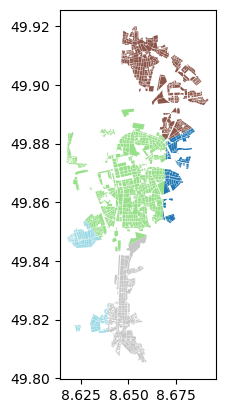

In [58]:
darm_typ_w_hex6.plot(column='hex_id', cmap='tab20')

In [59]:
# computing areas of sliced typ in m2
typ6_ar = darm_typ_w_hex6.copy()
typ6_ar.to_crs(crs='epsg:32632', inplace=True)
typ6_ar["typ_area"] = typ6_ar['geometry'].area
typ6_ar.head()

Entity Handle            Layer  LyrFrzn  LyrOn  Color    Linetype  \
0  2DPolyline     75  EST2_row_houses        0      1    233  Continuous   
1  2DPolyline     7B  EST2_row_houses        0      1    233  Continuous   
2  2DPolyline     83  EST2_row_houses        0      1    233  Continuous   
3  2DPolyline     B9  EST2_row_houses        0      1    233  Continuous   
4  2DPolyline     E2  EST2_row_houses        0      1    233  Continuous   

   Elevation  LineWt RefName  DocUpdate         DocId  GlobalWidt  Shape_Leng  \
0        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.675722   
1        0.0      70    None 2024-04-25  7.282236e+18         0.0  134.049873   
2        0.0      70    None 2024-04-25  7.282236e+18         0.0  293.058103   
3        0.0      70    None 2024-04-25  7.282236e+18         0.0  464.264058   
4        0.0      70    None 2024-04-25  7.282236e+18         0.0  209.471486   

    Shape_Area           hex_id  \
0  1129.031176  8663926dfffffff   
1   958.035347  867a9328fffffff   
2  4334.274022  8663926dfffffff   
3  2217.779077  867a9328fffffff   
4  2371.092222  867a9328fffffff   

                                            geometry     typ_area  
0  POLYGON Z ((477115.778 5525819.226 0, 477124.9...  1129.031176  
1  POLYGON Z ((473840.974 5521852.143 0, 473864.3...   958.035347  
2  POLYGON Z ((477120.999 5524418.192 0, 477099.4...  4334.274022  
3  POLYGON Z ((472698.917 5524755.162 0, 472704.6...  2217.779077  
4  POLYGON Z ((472606.539 5524731.997 0, 472599.3...  2371.092222

In [60]:
# grouping the data as per hex6 and typology
darm_typ_w_hex6_grp = typ6_ar.groupby(['hex_id','Layer'], as_index=False)['typ_area'].sum()
darm_typ_w_hex6_grp.head()

hex_id                  Layer       typ_area
0  8663926dfffffff             EST11_park     922.802293
1  8663926dfffffff         EST12_cemetary   50699.605012
2  8663926dfffffff  EST13_alloment_garden   35071.489564
3  8663926dfffffff  EST1A_detached_houses  619957.150266
4  8663926dfffffff  EST1B_detached_houses   39433.028030

In [61]:
# reorganising the data into usage format
pit6 = darm_typ_w_hex6_grp.pivot(index=['hex_id'], columns='Layer', values='typ_area')
pit6.head()

Layer               EST11_park  EST12_cemetary  EST13_alloment_garden  \
hex_id                                                                  
8663926dfffffff     922.802293    50699.605012           35071.489564   
867a9328fffffff  267940.237753    98431.234978          211485.325680   
867a9329fffffff   19996.898504             NaN          308957.288471   
867a932d7ffffff            NaN             NaN           22035.917625   
867a932f7ffffff            NaN             NaN           59216.594967   

Layer            EST1A_detached_houses  EST1B_detached_houses  \
hex_id                                                          
8663926dfffffff           6.199572e+05           39433.028030   
867a9328fffffff           1.178889e+06          187608.050612   
867a9329fffffff           9.743059e+05           39714.384270   
867a932d7ffffff           1.224552e+06           39401.843208   
867a932f7ffffff           4.229011e+05            2265.117032   

Layer            EST2_row_houses  EST3_row_structures_with_low_density  \
hex_id                                                                   
8663926dfffffff     65086.762080                          7.795645e+04   
867a9328fffffff    337257.313423                          1.261975e+06   
867a9329fffffff    643544.088894                          3.160614e+05   
867a932d7ffffff    255943.403644                          3.428828e+05   
867a932f7ffffff    141305.821266                          5.775835e+04   

Layer            EST4_row_structures_with_high_density  EST5_block_structures  \
hex_id                                                                          
8663926dfffffff                           12968.175348           5.878773e+04   
867a9328fffffff                           52839.505825           1.569654e+06   
867a9329fffffff                          249408.171816                    NaN   
867a932d7ffffff                           31420.537407                    NaN   
867a932f7ffffff                            8997.551939                    NaN   

Layer            EST6_rural_houses  EST7_historic_centre  EST8_city_centre  
hex_id                                                                      
8663926dfffffff         627.097848                   NaN               NaN  
867a9328fffffff      294554.184609          31247.772468     345095.237183  
867a9329fffffff      611503.156937                   NaN               NaN  
867a932d7ffffff      416284.831704                   NaN               NaN  
867a932f7ffffff      208036.456458                   NaN               NaN

In [62]:
# computing areas of hex6 in m2
hex6_ar = darm_hex6_fxd.copy()
hex6_ar.to_crs(crs='epsg:32632', inplace=True)
hex6_ar["hex_area"] = hex6_ar['geometry'].area
hex6_ar.head()

hex_id                                           geometry  \
0  867a9366fffffff  POLYGON ((476858.896 5535258.618, 478783.606 5...   
1  8663926dfffffff  POLYGON ((476301.86 5525440.669, 478231.741 55...   
2  867a9321fffffff  POLYGON ((466821.47 5523828.338, 468758.206 55...   
3  8663926cfffffff  POLYGON ((478416.142 5529692.963, 480342.585 5...   
4  867a932d7ffffff  POLYGON ((474181.965 5521185.811, 476115.288 5...   

       hex_area  
0  1.835797e+07  
1  1.842759e+07  
2  1.848616e+07  
3  1.838805e+07  
4  1.846719e+07

In [63]:
pit6 = pit6.merge(hex6_ar, on='hex_id')
pit6.head()

hex_id     EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8663926dfffffff     922.802293    50699.605012           35071.489564   
1  867a9328fffffff  267940.237753    98431.234978          211485.325680   
2  867a9329fffffff   19996.898504             NaN          308957.288471   
3  867a932d7ffffff            NaN             NaN           22035.917625   
4  867a932f7ffffff            NaN             NaN           59216.594967   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           6.199572e+05           39433.028030     65086.762080   
1           1.178889e+06          187608.050612    337257.313423   
2           9.743059e+05           39714.384270    643544.088894   
3           1.224552e+06           39401.843208    255943.403644   
4           4.229011e+05            2265.117032    141305.821266   

   EST3_row_structures_with_low_density  \
0                          7.795645e+04   
1                          1.261975e+06   
2                          3.160614e+05   
3                          3.428828e+05   
4                          5.775835e+04   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                           12968.175348           5.878773e+04   
1                           52839.505825           1.569654e+06   
2                          249408.171816                    NaN   
3                           31420.537407                    NaN   
4                            8997.551939                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         627.097848                   NaN               NaN   
1      294554.184609          31247.772468     345095.237183   
2      611503.156937                   NaN               NaN   
3      416284.831704                   NaN               NaN   
4      208036.456458                   NaN               NaN   

                                            geometry      hex_area  
0  POLYGON ((476301.86 5525440.669, 478231.741 55...  1.842759e+07  
1  POLYGON ((472626.528 5526759.169, 474558.114 5...  1.843705e+07  
2  POLYGON ((474745.518 5531010.176, 476673.664 5...  1.839748e+07  
3  POLYGON ((474181.965 5521185.811, 476115.288 5...  1.846719e+07  
4  POLYGON ((470501.92 5522505.6, 472436.951 5523...  1.847668e+07

In [64]:
pit6.to_excel('../data/results/hex_6_w_typ_area.xlsx')

In [65]:
# reading statistical districts
darmstadt_std_shp = gpd.read_file('../data/Darms_ST_districts/Districs.shp')
darmstadt_std_shp.to_crs(crs='epsg:4326', inplace=True)
darmstadt_std_shp

OBJECTID      Entity Layer  Color    Linetype  Elevation  LineWt RefName  \
0          1  LWPolyline  1001      7  Continuous        0.0      25    None   
1          2  LWPolyline  1001      7  Continuous        0.0      25    None   
2          3  LWPolyline  1001      7  Continuous        0.0      25    None   
3          4  LWPolyline  1001      7  Continuous        0.0      25    None   
4          5  LWPolyline  1001      7  Continuous        0.0      25    None   
5          6  LWPolyline  1001      7  Continuous        0.0      25    None   
6          7  LWPolyline  1001      7  Continuous        0.0      25    None   
7          8  LWPolyline  1001      7  Continuous        0.0      25    None   
8          9  LWPolyline  1001      7  Continuous        0.0      25    None   
9         10  LWPolyline  1001      7  Continuous        0.0      25    None   
10        11  LWPolyline  1001      7  Continuous        0.0      25    None   
11        12  LWPolyline  1001      7  Continuous        0.0      25    None   
12        13  LWPolyline  1001      7  Continuous        0.0      25    None   
13        14  LWPolyline  1001      7  Continuous        0.0      25    None   
14        15  LWPolyline  1001      7  Continuous        0.0      25    None   
15        16  LWPolyline  1001      7  Continuous        0.0      25    None   
16        17  LWPolyline  1001      7  Continuous        0.0      25    None   
17        18  LWPolyline  1001      7  Continuous        0.0      25    None   
18        19  LWPolyline  1001      7  Continuous        0.0      25    None   
19        20  LWPolyline  1001      7  Continuous        0.0      25    None   
20        21  LWPolyline  1001      7  Continuous        0.0      25    None   
21        22  LWPolyline  1001      7  Continuous        0.0      25    None   
22        23  LWPolyline  1001      7  Continuous        0.0      25    None   
23        24  LWPolyline  1001      7  Continuous        0.0      25    None   
24        25  LWPolyline  1001      7  Continuous        0.0      25    None   
25        26  LWPolyline  1001      7  Continuous        0.0      25    None   
26        27  LWPolyline  1001      7  Continuous        0.0      25    None   
27        28  LWPolyline  1001      7  Continuous        0.0      25    None   
28        29  LWPolyline  1001      7  Continuous        0.0      25    None   
29        30  LWPolyline  1001      7  Continuous        0.0      25    None   
30        31  LWPolyline  1001      7  Continuous        0.0      25    None   
31        32  LWPolyline  1001      7  Continuous        0.0      25    None   
32        33  LWPolyline  1001      7  Continuous        0.0      25    None   
33        34  LWPolyline  1001      7  Continuous        0.0      25    None   
34        35  LWPolyline  1001      7  Continuous        0.0      25    None   
35        36  LWPolyline  1001      7  Continuous        0.0      25    None   
36        37  LWPolyline  1001      7  Continuous        0.0      25    None   

                            Name_Bezir    Shape_Leng    Shape_Area  \
0                   810 Wixhausen-West   9360.192922  3.500984e+06   
1                    820 Wixhausen-Ost  21701.641762  1.972749e+07   
2                   630 Arheilgen-West  12019.657876  5.714194e+06   
3                    610 Alt-Arheilgen   6654.726438  2.045101e+06   
4                    640 Arheilgen-Ost   9402.803133  2.590851e+06   
5                920 Kranichstein-Nord  11928.863646  5.457804e+06   
6                      310 Am Oberfeld  20788.406205  1.920096e+07   
7                 910 Kranichstein-Süd   5050.868181  1.091750e+06   
8                    620 Arheilgen-Süd   4563.634983  9.092342e+05   
9                   270 Am Ziegelbusch   6249.417123  2.431327e+06   
10                 250 Mornewegviertel   3766.459078  5.234413e+05   
11                 530 Verlegerviertel   4302.615169  1.143100e+06   
12                 210 Johannesviertel   2688.561821 

In [66]:
# joining districts with typologies
darm_typ_w_dist = typology_shp.overlay(darmstadt_std_shp, how='intersection')
darm_typ_w_dist

Entity_1 Handle                Layer_1  LyrFrzn  LyrOn  Color_1  \
0     2DPolyline     75        EST2_row_houses        0      1      233   
1     2DPolyline     7B        EST2_row_houses        0      1      233   
2     2DPolyline     83        EST2_row_houses        0      1      233   
3     2DPolyline     B9        EST2_row_houses        0      1      233   
4     2DPolyline     E2        EST2_row_houses        0      1      233   
...          ...    ...                    ...      ...    ...      ...   
1793  2DPolyline   AC74  EST1A_detached_houses        0      1       80   
1794  2DPolyline   AC84  EST1A_detached_houses        0      1       80   
1795  2DPolyline   AC93      EST6_rural_houses        0      1       32   
1796  2DPolyline   ACA2  EST1A_detached_houses        0      1       80   
1797  2DPolyline   ACAE  EST13_alloment_garden        0      1      104   

      Linetype_1  Elevation_1  LineWt_1 RefName_1  DocUpdate         DocId  \
0     Continuous          0.0        70      None 2024-04-25  7.282236e+18   
1     Continuous          0.0        70      None 2024-04-25  7.282236e+18   
2     Continuous          0.0        70      None 2024-04-25  7.282236e+18   
3     Continuous          0.0        70      None 2024-04-25  7.282236e+18   
4     Continuous          0.0        70      None 2024-04-25  7.282236e+18   
...          ...          ...       ...       ...        ...           ...   
1793  Continuous          0.0        70      None 2024-04-25  7.282236e+18   
1794  Continuous          0.0        70      None 2024-04-25  7.282236e+18   
1795  Continuous          0.0        70      None 2024-04-25  7.282236e+18   
1796  Continuous          0.0        70      None 2024-04-25  7.282236e+18   
1797  Continuous          0.0        70      None 2024-04-25  7.282236e+18   

      GlobalWidt  Shape_Leng_1  Shape_Area_1  OBJECTID    Entity_2 Layer_2  \
0            0.0    134.675722   1129.031176         7  LWPolyline    1001   
1            0.0    134.049873    958.035347        26  LWPolyline    1001   
2            0.0    293.058103   4334.274022         7  LWPolyline    1001   
3            0.0    464.264058   2217.779077        35  LWPolyline    1001   
4            0.0    209.471486   2371.092222        35  LWPolyline    1001   
...          ...           ...           ...       ...         ...     ...   
1793         0.0    606.269966  17313.880523         3  LWPolyline    1001   
1794         0.0    531.244247   7116.873859         3  LWPolyline    1001   
1795         0.0    438.854341  10286.208752         3  LWPolyline    1001   
1796         0.0    398.907877   5770.432809         3  LWPolyline    1001   
1797         0.0    315.622840   4107.587936         6  LWPolyline    1001   

      Color_2  Linetype_2  Elevation_2  LineWt_2 RefName_2  \
0           7  Continuous          0.0        25      None   
1           7  Continuous          0.0        25      None   
2           7  Continuous          0.0        25      None   
3           7  Continuous          0.0        25      None   
4           7  Continuous          0.0        25      None   
...       ...         ...          ...       ...       ...   
1793        7  Continuous          0.0        25      None   
1794        7  Continuous          0.0        25      None   
1795        7  Continuous          0.0        25      None   
1796        7  Continuous          0.0        25      None   
1797        7  Continuous          0.0        25      None   

                   Name_Bezir  Shape_Leng_2  Shape_Area_2  \
0             310 Am Oberfeld  20788.406205  1.920096e+07   
1     520 Heimstättensiedlung   6997.742530  2.063725e+06   
2             310 Am Oberfeld  20788.406205  1.920096e+07   
3             240 Waldkolonie  10195.376759  4.481641e+06   
4             240 Waldkolonie  10195.376759  4.481641e+06   
...                       ...           ...           ...   
1793       630 Arheilgen-West  12019.657876  5.714194e+06   


<Axes: >

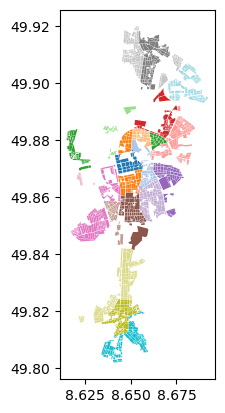

In [67]:
darm_typ_w_dist.plot(column='Name_Bezir', cmap='tab20')

In [68]:
# computing areas of sliced typ in m2
typD_ar = darm_typ_w_dist.copy()
typD_ar.to_crs(crs='epsg:32632', inplace=True)
typD_ar["typ_area"] = typD_ar['geometry'].area
typD_ar.head()

Entity_1 Handle          Layer_1  LyrFrzn  LyrOn  Color_1  Linetype_1  \
0  2DPolyline     75  EST2_row_houses        0      1      233  Continuous   
1  2DPolyline     7B  EST2_row_houses        0      1      233  Continuous   
2  2DPolyline     83  EST2_row_houses        0      1      233  Continuous   
3  2DPolyline     B9  EST2_row_houses        0      1      233  Continuous   
4  2DPolyline     E2  EST2_row_houses        0      1      233  Continuous   

   Elevation_1  LineWt_1 RefName_1  DocUpdate         DocId  GlobalWidt  \
0          0.0        70      None 2024-04-25  7.282236e+18         0.0   
1          0.0        70      None 2024-04-25  7.282236e+18         0.0   
2          0.0        70      None 2024-04-25  7.282236e+18         0.0   
3          0.0        70      None 2024-04-25  7.282236e+18         0.0   
4          0.0        70      None 2024-04-25  7.282236e+18         0.0   

   Shape_Leng_1  Shape_Area_1  OBJECTID    Entity_2 Layer_2  Color_2  \
0    134.675722   1129.031176         7  LWPolyline    1001        7   
1    134.049873    958.035347        26  LWPolyline    1001        7   
2    293.058103   4334.274022         7  LWPolyline    1001        7   
3    464.264058   2217.779077        35  LWPolyline    1001        7   
4    209.471486   2371.092222        35  LWPolyline    1001        7   

   Linetype_2  Elevation_2  LineWt_2 RefName_2               Name_Bezir  \
0  Continuous          0.0        25      None          310 Am Oberfeld   
1  Continuous          0.0        25      None  520 Heimstättensiedlung   
2  Continuous          0.0        25      None          310 Am Oberfeld   
3  Continuous          0.0        25      None          240 Waldkolonie   
4  Continuous          0.0        25      None          240 Waldkolonie   

   Shape_Leng_2  Shape_Area_2  \
0  20788.406205  1.920096e+07   
1   6997.742530  2.063725e+06   
2  20788.406205  1.920096e+07   
3  10195.376759  4.481641e+06   
4  10195.376759  4.481641e+06   

                                            geometry     typ_area  
0  POLYGON Z ((477115.778 5525819.226 0, 477124.9...  1129.031176  
1  POLYGON Z ((473840.974 5521852.143 0, 473864.3...   958.035347  
2  POLYGON Z ((477120.999 5524418.192 0, 477099.4...  4334.274022  
3  POLYGON Z ((472698.917 5524755.162 0, 472704.6...  2217.779077  
4  POLYGON Z ((472606.539 5524731.997 0, 472599.3...  2371.092222

In [69]:
# grouping the data as per hex6 and typology
darm_typ_w_dist_grp = typD_ar.groupby(['Name_Bezir','Layer_1'], as_index=False)['typ_area'].sum()
darm_typ_w_dist_grp.head()

Name_Bezir                Layer_1       typ_area
0           110 Stadtzentrum             EST11_park    7370.186849
1           110 Stadtzentrum  EST5_block_structures   24185.537025
2           110 Stadtzentrum   EST7_historic_centre   23495.041093
3           110 Stadtzentrum       EST8_city_centre  112451.093688
4  120 Rheintor/Grafenstraße       EST8_city_centre  231176.416702

In [70]:
# reorganising the data into usage format
pitD = darm_typ_w_dist_grp.pivot(index=['Name_Bezir'], columns='Layer_1', values='typ_area')
pitD.head()

Layer_1                                EST11_park  EST12_cemetary  \
Name_Bezir                                                          
110 Stadtzentrum                      7370.186849             NaN   
120 Rheintor/Grafenstraße                     NaN             NaN   
130 Hochschulviertel                113671.235126             NaN   
140 Kapellplatzviertel                   1.259645             NaN   
150 St. Ludwig mit Eichbergviertel            NaN             NaN   

Layer_1                             EST13_alloment_garden  \
Name_Bezir                                                  
110 Stadtzentrum                                      NaN   
120 Rheintor/Grafenstraße                             NaN   
130 Hochschulviertel                                  NaN   
140 Kapellplatzviertel                                NaN   
150 St. Ludwig mit Eichbergviertel                    NaN   

Layer_1                             EST1A_detached_houses  \
Name_Bezir                                                  
110 Stadtzentrum                                      NaN   
120 Rheintor/Grafenstraße                             NaN   
130 Hochschulviertel                                  NaN   
140 Kapellplatzviertel                       11748.238663   
150 St. Ludwig mit Eichbergviertel           37064.281641   

Layer_1                             EST1B_detached_houses  EST2_row_houses  \
Name_Bezir                                                                   
110 Stadtzentrum                                      NaN              NaN   
120 Rheintor/Grafenstraße                             NaN              NaN   
130 Hochschulviertel                                  NaN              NaN   
140 Kapellplatzviertel                       33491.589152      9814.215928   
150 St. Ludwig mit Eichbergviertel           20746.521595     21350.298699   

Layer_1                             EST3_row_structures_with_low_density  \
Name_Bezir                                                                 
110 Stadtzentrum                                                     NaN   
120 Rheintor/Grafenstraße                                            NaN   
130 Hochschulviertel                                                 NaN   
140 Kapellplatzviertel                                      51467.207186   
150 St. Ludwig mit Eichbergviertel                         187793.734718   

Layer_1                             EST4_row_structures_with_high_density  \
Name_Bezir                                                                  
110 Stadtzentrum                                                      NaN   
120 Rheintor/Grafenstraße                                             NaN   
130 Hochschulviertel                                                  NaN   
140 Kapellplatzviertel                                                NaN   
150 St. Ludwig mit Eichbergviertel                                    NaN   

Layer_1                             EST5_block_structures  EST6_rural_houses  \
Name_Bezir                                                                     
110 Stadtzentrum                             24185.537025                NaN   
120 Rheintor/Grafenstraße                             NaN                NaN   
130 Hochschulviertel                         30495.437374                NaN   
140 Kapellplatzviertel                      170223.321769        1391.841472   
150 St. Ludwig mit Eichbergviertel          187282.062266       22669.619786   

Layer_1                             EST7_historic_centre  EST8_city_centre  
Name_Bezir                                                                  
110 Stadtzentrum                            23495.041093     112451.093688  
120 Rheintor/Grafenstraße                            NaN     231176.416702  
130 Hochschulviertel                                 NaN               NaN  
140 Kapellplatzviertel                       7752.731375       1467.726794  
150 St. Ludwig mi

In [71]:
# computing areas of hex6 in m2
Dist_ar = darmstadt_std_shp.copy()
Dist_ar.to_crs(crs='epsg:32632', inplace=True)
Dist_ar["Dist_area"] = Dist_ar['geometry'].area
Dist_ar.head()

OBJECTID      Entity Layer  Color    Linetype  Elevation  LineWt RefName  \
0         1  LWPolyline  1001      7  Continuous        0.0      25    None   
1         2  LWPolyline  1001      7  Continuous        0.0      25    None   
2         3  LWPolyline  1001      7  Continuous        0.0      25    None   
3         4  LWPolyline  1001      7  Continuous        0.0      25    None   
4         5  LWPolyline  1001      7  Continuous        0.0      25    None   

           Name_Bezir    Shape_Leng    Shape_Area  \
0  810 Wixhausen-West   9360.192922  3.500984e+06   
1   820 Wixhausen-Ost  21701.641762  1.972749e+07   
2  630 Arheilgen-West  12019.657876  5.714194e+06   
3   610 Alt-Arheilgen   6654.726438  2.045101e+06   
4   640 Arheilgen-Ost   9402.803133  2.590851e+06   

                                            geometry     Dist_area  
0  POLYGON ((474748.8 5531179, 474746.5 5531157.3...  3.500984e+06  
1  POLYGON ((475214.1 5530077.8, 475210.8 5530078...  1.972749e+07  
2  POLYGON ((473324.4 5530127.9, 473409.7 5530107...  5.714194e+06  
3  POLYGON ((475219.4 5530064.1, 475226.5 5530074...  2.045101e+06  
4  POLYGON ((475862.8 5527741.8, 475871.2 5527806...  2.590851e+06

In [72]:
pitD = pitD.merge(Dist_ar, on='Name_Bezir')
pitD.head()

Name_Bezir     EST11_park  EST12_cemetary  \
0                    110 Stadtzentrum    7370.186849             NaN   
1           120 Rheintor/Grafenstraße            NaN             NaN   
2                130 Hochschulviertel  113671.235126             NaN   
3              140 Kapellplatzviertel       1.259645             NaN   
4  150 St. Ludwig mit Eichbergviertel            NaN             NaN   

   EST13_alloment_garden  EST1A_detached_houses  EST1B_detached_houses  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN           11748.238663           33491.589152   
4                    NaN           37064.281641           20746.521595   

   EST2_row_houses  EST3_row_structures_with_low_density  \
0              NaN                                   NaN   
1              NaN                                   NaN   
2              NaN                                   NaN   
3      9814.215928                          51467.207186   
4     21350.298699                         187793.734718   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN           24185.537025   
1                                    NaN                    NaN   
2                                    NaN           30495.437374   
3                                    NaN          170223.321769   
4                                    NaN          187282.062266   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  OBJECTID  \
0                NaN          23495.041093     112451.093688        17   
1                NaN                   NaN     231176.416702        16   
2                NaN                   NaN               NaN        18   
3        1391.841472           7752.731375       1467.726794        21   
4       22669.619786                   NaN               NaN        20   

       Entity Layer  Color    Linetype  Elevation  LineWt RefName  \
0  LWPolyline  1001      7  Continuous        0.0      25    None   
1  LWPolyline  1001      7  Continuous        0.0      25    None   
2  LWPolyline  1001      7  Continuous        0.0      25    None   
3  LWPolyline  1001      7  Continuous        0.0      25    None   
4  LWPolyline  1001      7  Continuous        0.0      25    None   

    Shape_Leng  Shape_Area                                           geometry  \
0  2595.787857  299855.115  POLYGON ((474704.5 5524870.5, 474716.8 5524872...   
1  2625.814320  398359.550  POLYGON ((474700.4 5524869.8, 474704.5 5524870...   
2  2811.905234  414414.555  POLYGON ((475238.9 5524553.4, 475225.2 5524551...   
3  3382.614724  496346.625  POLYGON ((475566.1 5523632.3, 475503.9 5523588...   
4  3966.607654  719066.380  POLYGON ((474642.4 5523307.7, 474638.8 5523289...   

       Dist_area  
0  299855.114999  
1  398359.549998  
2  414414.554998  
3  496346.624997  
4  719066.379996

In [73]:
pitD_small = pitD[['Name_Bezir', 'EST11_park', 'EST12_cemetary', 'EST13_alloment_garden',
       'EST1A_detached_houses', 'EST1B_detached_houses', 'EST2_row_houses',
       'EST3_row_structures_with_low_density',
       'EST4_row_structures_with_high_density', 'EST5_block_structures',
       'EST6_rural_houses', 'EST7_historic_centre', 'EST8_city_centre', 'Dist_area']].copy()

In [74]:
### Read in tiff temp file 20-08-2023
dataarray1 = xr.open_dataset('../data/Landsurface_Temperature/D_LST_20230820.tif', engine='rasterio')

# copy the data to dataframe
df1 = dataarray1.to_dataframe()
df1.reset_index(inplace=True)
df1

band         x          y  spatial_ref  band_data
0          1  462870.0  5533860.0            0  28.451338
1          1  462870.0  5533830.0            0  28.347881
2          1  462870.0  5533800.0            0  28.258028
3          1  462870.0  5533770.0            0  28.184521
4          1  462870.0  5533740.0            0  28.140858
...      ...       ...        ...          ...        ...
526677     1  488700.0  5515680.0            0  31.860716
526678     1  488700.0  5515650.0            0  31.757217
526679     1  488700.0  5515620.0            0  31.717854
526680     1  488700.0  5515590.0            0  31.712639
526681     1  488700.0  5515560.0            0  31.765898

[526682 rows x 5 columns]

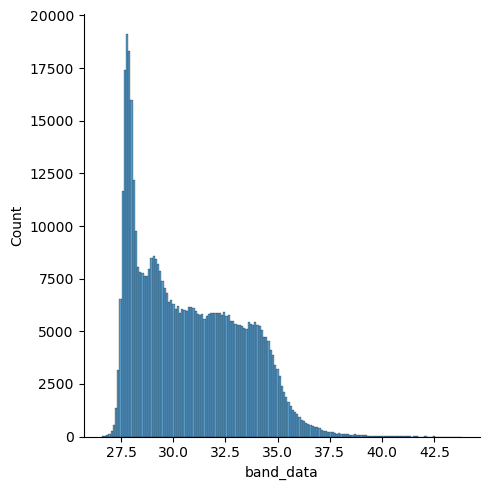

In [75]:
# checking the data
sns.displot(df1['band_data'])

In [76]:
# creating geometry 
geometry = [Point(xy) for xy in zip(df1.x, df1.y)]
# df = df.drop(['x', 'y'], axis=1)
gdf1 = GeoDataFrame(df1, crs="EPSG:32632", geometry=geometry)
gdf1

band         x          y  spatial_ref  band_data  \
0          1  462870.0  5533860.0            0  28.451338   
1          1  462870.0  5533830.0            0  28.347881   
2          1  462870.0  5533800.0            0  28.258028   
3          1  462870.0  5533770.0            0  28.184521   
4          1  462870.0  5533740.0            0  28.140858   
...      ...       ...        ...          ...        ...   
526677     1  488700.0  5515680.0            0  31.860716   
526678     1  488700.0  5515650.0            0  31.757217   
526679     1  488700.0  5515620.0            0  31.717854   
526680     1  488700.0  5515590.0            0  31.712639   
526681     1  488700.0  5515560.0            0  31.765898   

                      geometry  
0       POINT (462870 5533860)  
1       POINT (462870 5533830)  
2       POINT (462870 5533800)  
3       POINT (462870 5533770)  
4       POINT (462870 5533740)  
...                        ...  
526677  POINT (488700 5515680)  
526678  POINT (488700 5515650)  
526679  POINT (488700 5515620)  
526680  POINT (488700 5515590)  
526681  POINT (488700 5515560)  

[526682 rows x 6 columns]

<Axes: >

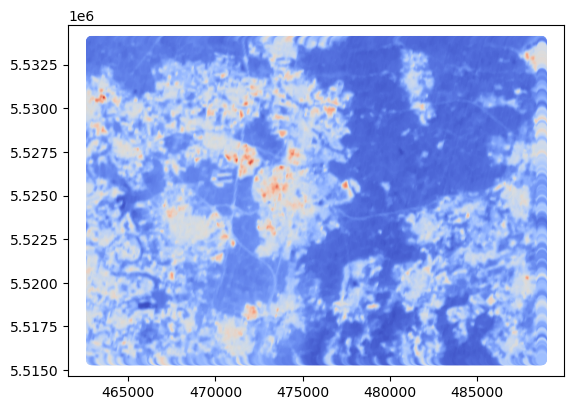

In [77]:
gdf1.plot(column='band_data', cmap='coolwarm')

<Axes: >

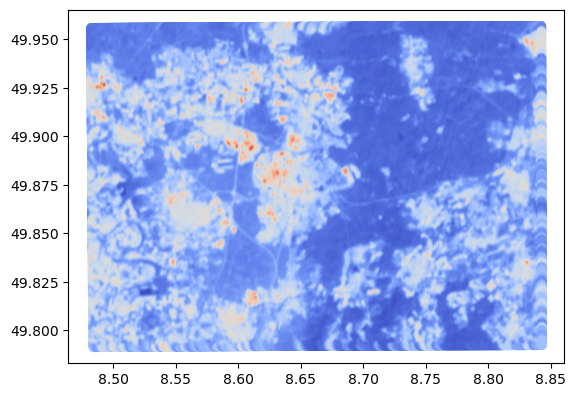

In [78]:
# changing crs to epsg:4326
gdf1.to_crs(crs='epsg:4326', inplace=True)
gdf1.plot(column='band_data', cmap='coolwarm')

In [79]:
# joining temp with hex9
gdf1_w_hex9 = gdf1.overlay(darm_hex9_fxd, how='intersection')
gdf1_w_hex9

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521800.0            0  33.770164  897a9321813ffff   
1          1  468300.0  5521770.0            0  33.885727  897a9321813ffff   
2          1  468300.0  5521740.0            0  34.014351  897a9321813ffff   
3          1  468300.0  5521710.0            0  34.210583  897a9321813ffff   
4          1  468300.0  5521680.0            0  34.500244  897a9321813ffff   
...      ...       ...        ...          ...        ...              ...   
135938     1  482070.0  5528040.0            0  27.971674  8963926cd93ffff   
135939     1  482070.0  5528010.0            0  27.982693  8963926cd93ffff   
135940     1  482070.0  5527980.0            0  27.974396  8963926cd93ffff   
135941     1  482070.0  5527950.0            0  27.963581  8963926cd93ffff   
135942     1  482100.0  5528070.0            0  27.911392  8963926cd93ffff   

                        geometry  
0       POINT (8.55907 49.84778)  
1       POINT (8.55907 49.84751)  
2       POINT (8.55907 49.84724)  
3       POINT (8.55907 49.84697)  
4        POINT (8.55908 49.8467)  
...                          ...  
135938  POINT (8.75031 49.90448)  
135939  POINT (8.75031 49.90421)  
135940  POINT (8.75031 49.90394)  
135941  POINT (8.75031 49.90367)  
135942  POINT (8.75073 49.90475)  

[135943 rows x 7 columns]

In [80]:
# calculating mean temp of hex9
gdf1_w_hex9_grp = gdf1_w_hex9.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf1_w_hex9_grp.rename(columns={"band_data": "HW_1"}, inplace=True)
gdf1_w_hex9_grp

hex_id       HW_1
0     8963926c323ffff  28.318008
1     8963926c327ffff  27.821741
2     8963926c32bffff  28.250315
3     8963926c32fffff  28.450893
4     8963926c333ffff  28.331596
...               ...        ...
2273  897a9366dcbffff  27.913015
2274  897a9366dcfffff  27.963037
2275  897a9366dd3ffff  28.105593
2276  897a9366dd7ffff  28.092205
2277  897a9366ddbffff  28.027508

[2278 rows x 2 columns]

In [81]:
pit9 = pit9.merge(gdf1_w_hex9_grp, on='hex_id')
pit9.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8963926d967ffff         NaN             NaN                    NaN   
1  8963926d96bffff         NaN             NaN                    NaN   
2  8963926d96fffff         NaN             NaN                    NaN   
3  8963926da2bffff         NaN             NaN             334.173365   
4  8963926da2fffff         NaN             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0            5998.331649              70.591067      6825.110809   
1              48.627892                    NaN              NaN   
2           11806.381376            7838.689081     11650.211475   
3            4867.465639                    NaN              NaN   
4                    NaN                    NaN              NaN   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                           5182.624977   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                                    NaN                    NaN   
3                                    NaN                    NaN   
4                                    NaN                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry      hex_area       HW_1  
0  POLYGON ((477290.493 5526006.948, 477404.859 5...  53681.204005  29.838594  
1  POLYGON ((477149.611 5525546.057, 477263.994 5...  53692.410698  30.090197  
2  POLYGON ((477129.162 5525860.206, 477243.537 5...  53686.473523  31.541504  
3  POLYGON ((476465.019 5522926.877, 476579.491 5...  53754.404812  32.791145  
4  POLYGON ((476444.618 5523241.14, 476559.081 55...  53748.464832  30.724434

In [82]:
# joining temp with hex8
gdf1_w_hex8 = gdf1.overlay(darm_hex8_fxd, how='intersection')
gdf1_w_hex8

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521560.0            0  34.555397  887a932181fffff   
1          1  468300.0  5521530.0            0  33.922478  887a932181fffff   
2          1  468300.0  5521500.0            0  33.339485  887a932181fffff   
3          1  468300.0  5521470.0            0  32.933769  887a932181fffff   
4          1  468300.0  5521440.0            0  32.656265  887a932181fffff   
...      ...       ...        ...          ...        ...              ...   
136606     1  482070.0  5528220.0            0  27.785912  8863926cd9fffff   
136607     1  482070.0  5528190.0            0  27.810436  8863926cd9fffff   
136608     1  482070.0  5528160.0            0  27.840731  8863926cd9fffff   
136609     1  482070.0  5528130.0            0  27.865143  8863926cd9fffff   
136610     1  482070.0  5528100.0            0  27.906139  8863926cd9fffff   

                        geometry  
0       POINT (8.55909 49.84562)  
1       POINT (8.55909 49.84535)  
2       POINT (8.55909 49.84509)  
3       POINT (8.55909 49.84482)  
4        POINT (8.5591 49.84455)  
...                          ...  
136606    POINT (8.7503 49.9061)  
136607   POINT (8.7503 49.90583)  
136608   POINT (8.7503 49.90556)  
136609  POINT (8.75031 49.90529)  
136610  POINT (8.75031 49.90502)  

[136611 rows x 7 columns]

In [83]:
# calculating mean temp of hex8
gdf1_w_hex8_grp = gdf1_w_hex8.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf1_w_hex8_grp.rename(columns={"band_data": "HW_1"}, inplace=True)
gdf1_w_hex8_grp

hex_id       HW_1
0    8863926c33fffff  28.206165
1    8863926c81fffff  27.758780
2    8863926c83fffff  27.661617
3    8863926c85fffff  27.859625
4    8863926c87fffff  27.804783
..               ...        ...
322  887a9366d5fffff  27.745573
323  887a9366d7fffff  27.968430
324  887a9366d9fffff  28.178953
325  887a9366dbfffff  30.808739
326  887a9366ddfffff  27.995052

[327 rows x 2 columns]

In [84]:
pit8 = pit8.merge(gdf1_w_hex8_grp, on='hex_id')
pit8.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8863926d97fffff         NaN             NaN                    NaN   
1  8863926da3fffff         NaN             NaN               1.402865   
2  8863926da7fffff         NaN             NaN           35070.086609   
3  8863926db1fffff         NaN             NaN                    NaN   
4  8863926db3fffff  922.635324             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           16621.459801            7528.525549     19959.579969   
1            4498.292880                    NaN              NaN   
2           20132.740288                    NaN     12414.954370   
3           79437.891126                    NaN      9377.362093   
4          153723.033194                    NaN      1692.195626   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                           6444.983305   
2                          14241.108956   
3                          16481.289669   
4                           8021.713419   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                            2172.225783                    NaN   
3                            5034.614558                    NaN   
4                                    NaN           13752.752536   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         625.885335                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry       hex_area       HW_1  
0  POLYGON ((477129.162 5525860.206, 477404.859 5...  375809.985090  31.418055  
1  POLYGON ((476444.618 5523241.14, 476720.562 55...  376243.911556  30.027418  
2  POLYGON ((476141.968 5522633.251, 476417.982 5...  376359.341929  29.924324  
3  POLYGON ((476524.472 5524644.846, 476800.31 55...  376040.701582  31.437441  
4  POLYGON ((476301.86 5525440.669, 476577.663 55...  375952.890176  31.169531

In [85]:
# joining temp with hex7
gdf1_w_hex7 = gdf1.overlay(darm_hex7_fxd, how='intersection')
gdf1_w_hex7

band         x          y  spatial_ref  band_data           hex_id  \
0          1  467790.0  5521650.0            0  33.660397  877a93218ffffff   
1          1  467790.0  5521620.0            0  33.864838  877a93218ffffff   
2          1  467790.0  5521590.0            0  34.139584  877a93218ffffff   
3          1  467790.0  5521560.0            0  34.500233  877a93218ffffff   
4          1  467790.0  5521530.0            0  34.826225  877a93218ffffff   
...      ...       ...        ...          ...        ...              ...   
131402     1  482040.0  5528280.0            0  27.854300  8763926cdffffff   
131403     1  482040.0  5528250.0            0  27.791445  8763926cdffffff   
131404     1  482070.0  5528400.0            0  28.576956  8763926cdffffff   
131405     1  482070.0  5528370.0            0  28.350805  8763926cdffffff   
131406     1  482070.0  5528340.0            0  28.151882  8763926cdffffff   

                        geometry  
0       POINT (8.55199 49.84641)  
1       POINT (8.55199 49.84614)  
2       POINT (8.55199 49.84587)  
3        POINT (8.55199 49.8456)  
4         POINT (8.552 49.84533)  
...                          ...  
131402  POINT (8.74988 49.90663)  
131403  POINT (8.74988 49.90636)  
131404  POINT (8.75029 49.90771)  
131405  POINT (8.75029 49.90745)  
131406   POINT (8.7503 49.90718)  

[131407 rows x 7 columns]

In [86]:
# calculating mean temp of hex7
gdf1_w_hex7_grp = gdf1_w_hex7.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf1_w_hex7_grp.rename(columns={"band_data": "HW_1"}, inplace=True)
gdf1_w_hex7_grp

hex_id       HW_1
0   8763926c8ffffff  27.770414
1   8763926c9ffffff  27.863222
2   8763926caffffff  27.852592
3   8763926cbffffff  27.824547
4   8763926cdffffff  27.978455
5   8763926ceffffff  28.149487
6   8763926d8ffffff  28.218504
7   8763926d9ffffff  30.660500
8   8763926daffffff  28.538870
9   8763926dbffffff  30.932590
10  8763926ddffffff  27.896549
11  877a93218ffffff  32.500225
12  877a9321bffffff  30.670933
13  877a93282ffffff  32.890083
14  877a93283ffffff  32.202457
15  877a93288ffffff  35.067825
16  877a93289ffffff  32.581303
17  877a9328affffff  33.306854
18  877a9328bffffff  32.582390
19  877a9328cffffff  34.797859
20  877a9328dffffff  33.820362
21  877a9328effffff  33.738758
22  877a93291ffffff  31.306177
23  877a93298ffffff  32.417053
24  877a93299ffffff  30.713484
25  877a9329affffff  31.271257
26  877a9329bffffff  29.644602
27  877a9329cffffff  33.289497
28  877a9329dffffff  33.267368
29  877a9329effffff  31.901426
30  877a932abffffff  29.931860
31  877a932d0ffffff  29.990831
32  877a932d4ffffff  30.742884
33  877a932d5ffffff  32.053925
34  877a932d6ffffff  28.734234
35  877a932f0ffffff  29.098921
36  877a932f2ffffff  31.322449
37  877a932f3ffffff  31.637650
38  877a932f4ffffff  31.081654
39  877a932f6ffffff  29.555393
40  877a9364dffffff  29.559610
41  877a93668ffffff  27.673262
42  877a93669ffffff  27.873972
43  877a9366bffffff  27.831421
44  877a9366dffffff  28.586363

In [87]:
pit7 = pit7.merge(gdf1_w_hex7_grp, on='hex_id')
pit7.head()

hex_id   EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8763926d9ffffff          NaN             NaN                    NaN   
1  8763926daffffff          NaN             NaN           35071.489564   
2  8763926dbffffff  2184.358476    24387.049186                    NaN   
3  877a93283ffffff          NaN             NaN                    NaN   
4  877a93288ffffff  9881.342029             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           10882.197440            4215.258953      9700.352304   
1           18563.273944                    NaN      8359.014671   
2          483684.259578            3209.713330     20795.953564   
3           19025.514696             152.324029     52366.232480   
4           36273.401777           28137.885941     24410.374269   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                          19423.655239   
2                          73978.330549   
3                          42133.740240   
4                         272346.726067   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                            2172.225783                    NaN   
2                           14915.682503          122973.167321   
3                                    NaN                    NaN   
4                            6901.611633          292124.265546   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4       25460.653446           2203.494021      337451.38577   

                                            geometry      hex_area       HW_1  
0  POLYGON ((477431.335 5526467.807, 478231.741 5...  2.630477e+06  30.660500  
1  POLYGON ((476444.618 5523241.14, 477245.812 55...  2.634322e+06  28.538870  
2  POLYGON ((476301.86 5525440.669, 477102.642 55...  2.632285e+06  30.932590  
3  POLYGON ((473616.065 5529984.33, 474416.36 552...  2.629788e+06  32.202457  
4  POLYGON ((473898.837 5525586.162, 474699.958 5...  2.633865e+06  35.067825

In [88]:
# joining temp with hex6
gdf1_w_hex6 = gdf1.overlay(darm_hex6_fxd, how='intersection')
gdf1_w_hex6

band         x          y  spatial_ref  band_data           hex_id  \
0          1  466650.0  5520930.0            0  34.296970  867a9321fffffff   
1          1  466650.0  5520900.0            0  34.396469  867a9321fffffff   
2          1  466650.0  5520870.0            0  34.231804  867a9321fffffff   
3          1  466650.0  5520840.0            0  34.056076  867a9321fffffff   
4          1  466650.0  5520810.0            0  33.885559  867a9321fffffff   
...      ...       ...        ...          ...        ...              ...   
157386     1  482070.0  5528220.0            0  27.785912  8663926cfffffff   
157387     1  482070.0  5528190.0            0  27.810436  8663926cfffffff   
157388     1  482070.0  5528160.0            0  27.840731  8663926cfffffff   
157389     1  482070.0  5528130.0            0  27.865143  8663926cfffffff   
157390     1  482070.0  5528100.0            0  27.906139  8663926cfffffff   

                        geometry  
0       POINT (8.53619 49.83987)  
1        POINT (8.53619 49.8396)  
2        POINT (8.5362 49.83933)  
3        POINT (8.5362 49.83906)  
4        POINT (8.5362 49.83879)  
...                          ...  
157386    POINT (8.7503 49.9061)  
157387   POINT (8.7503 49.90583)  
157388   POINT (8.7503 49.90556)  
157389  POINT (8.75031 49.90529)  
157390  POINT (8.75031 49.90502)  

[157391 rows x 7 columns]

In [89]:
# calculating mean temp of hex6
gdf1_w_hex6_grp = gdf1_w_hex6.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf1_w_hex6_grp.rename(columns={"band_data": "HW_1"}, inplace=True)
gdf1_w_hex6_grp

hex_id       HW_1
0  8663926cfffffff  27.900627
1  8663926dfffffff  29.327410
2  867a9321fffffff  32.426788
3  867a9328fffffff  33.737103
4  867a9329fffffff  31.742964
5  867a932d7ffffff  29.824053
6  867a932f7ffffff  30.735737
7  867a9366fffffff  28.002098

In [90]:
pit6 = pit6.merge(gdf1_w_hex6_grp, on='hex_id')
pit6.head()

hex_id     EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8663926dfffffff     922.802293    50699.605012           35071.489564   
1  867a9328fffffff  267940.237753    98431.234978          211485.325680   
2  867a9329fffffff   19996.898504             NaN          308957.288471   
3  867a932d7ffffff            NaN             NaN           22035.917625   
4  867a932f7ffffff            NaN             NaN           59216.594967   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           6.199572e+05           39433.028030     65086.762080   
1           1.178889e+06          187608.050612    337257.313423   
2           9.743059e+05           39714.384270    643544.088894   
3           1.224552e+06           39401.843208    255943.403644   
4           4.229011e+05            2265.117032    141305.821266   

   EST3_row_structures_with_low_density  \
0                          7.795645e+04   
1                          1.261975e+06   
2                          3.160614e+05   
3                          3.428828e+05   
4                          5.775835e+04   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                           12968.175348           5.878773e+04   
1                           52839.505825           1.569654e+06   
2                          249408.171816                    NaN   
3                           31420.537407                    NaN   
4                            8997.551939                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         627.097848                   NaN               NaN   
1      294554.184609          31247.772468     345095.237183   
2      611503.156937                   NaN               NaN   
3      416284.831704                   NaN               NaN   
4      208036.456458                   NaN               NaN   

                                            geometry      hex_area       HW_1  
0  POLYGON ((476301.86 5525440.669, 478231.741 55...  1.842759e+07  29.327410  
1  POLYGON ((472626.528 5526759.169, 474558.114 5...  1.843705e+07  33.737103  
2  POLYGON ((474745.518 5531010.176, 476673.664 5...  1.839748e+07  31.742964  
3  POLYGON ((474181.965 5521185.811, 476115.288 5...  1.846719e+07  29.824053  
4  POLYGON ((470501.92 5522505.6, 472436.951 5523...  1.847668e+07  30.735737

In [91]:
# joining temp with districts
gdf1_w_Dist = gdf1.overlay(darmstadt_std_shp, how='intersection')
gdf1_w_Dist

band         x          y  spatial_ref  band_data  OBJECTID  \
0          1  468240.0  5521830.0            0  33.568249        36   
1          1  468270.0  5521830.0            0  33.641903        36   
2          1  468270.0  5521800.0            0  33.683495        36   
3          1  468270.0  5521770.0            0  33.814743        36   
4          1  468270.0  5521740.0            0  33.980045        36   
...      ...       ...        ...          ...        ...       ...   
135557     1  482010.0  5527740.0            0  27.854328         7   
135558     1  482010.0  5527710.0            0  27.794241         7   
135559     1  482010.0  5527680.0            0  27.734045         7   
135560     1  482040.0  5527950.0            0  27.922661         7   
135561     1  482040.0  5527920.0            0  27.876059         7   

            Entity Layer  Color    Linetype  Elevation  LineWt RefName  \
0       LWPolyline  1001      7  Continuous        0.0      25    None   
1       LWPolyline  1001      7  Continuous        0.0      25    None   
2       LWPolyline  1001      7  Continuous        0.0      25    None   
3       LWPolyline  1001      7  Continuous        0.0      25    None   
4       LWPolyline  1001      7  Continuous        0.0      25    None   
...            ...   ...    ...         ...        ...     ...     ...   
135557  LWPolyline  1001      7  Continuous        0.0      25    None   
135558  LWPolyline  1001      7  Continuous        0.0      25    None   
135559  LWPolyline  1001      7  Continuous        0.0      25    None   
135560  LWPolyline  1001      7  Continuous        0.0      25    None   
135561  LWPolyline  1001      7  Continuous        0.0      25    None   

                   Name_Bezir    Shape_Leng    Shape_Area  \
0       540 Am Kavalleriesand  17662.149836  1.146508e+07   
1       540 Am Kavalleriesand  17662.149836  1.146508e+07   
2       540 Am Kavalleriesand  17662.149836  1.146508e+07   
3       540 Am Kavalleriesand  17662.149836  1.146508e+07   
4       540 Am Kavalleriesand  17662.149836  1.146508e+07   
...                       ...           ...           ...   
135557        310 Am Oberfeld  20788.406205  1.920096e+07   
135558        310 Am Oberfeld  20788.406205  1.920096e+07   
135559        310 Am Oberfeld  20788.406205  1.920096e+07   
135560        310 Am Oberfeld  20788.406205  1.920096e+07   
135561        310 Am Oberfeld  20788.406205  1.920096e+07   

                        geometry  
0       POINT (8.55823 49.84805)  
1       POINT (8.55865 49.84805)  
2       POINT (8.55865 49.84778)  
3       POINT (8.55865 49.84751)  
4       POINT (8.55865 49.84724)  
...                          ...  
135557  POINT (8.74949 49.90178)  
135558  POINT (8.74949 49.90151)  
135559  POINT (8.74949 49.90124)  
135560   POINT (8.7499 49.90367)  
135561    POINT (8.7499 49.9034)  

[135562 rows x 17 columns]

In [92]:
# calculating mean temp of hex6
gdf1_w_Dist_grp = gdf1_w_Dist.groupby(['Name_Bezir'], as_index=False)['band_data'].mean()
gdf1_w_Dist_grp.rename(columns={"band_data": "HW_1"}, inplace=True)
gdf1_w_Dist_grp

Name_Bezir       HW_1
0                     110 Stadtzentrum  35.800507
1            120 Rheintor/Grafenstraße  35.462467
2                 130 Hochschulviertel  33.821999
3               140 Kapellplatzviertel  34.337162
4   150 St. Ludwig mit Eichbergviertel  33.851768
5                  210 Johannesviertel  34.566647
6              220 Martinsviertel-West  33.901546
7               230 Martinsviertel-Ost  33.173836
8                      240 Waldkolonie  31.850771
9                  250 Mornewegviertel  35.559780
10             260 Pallaswiesenviertel  34.956940
11                  270 Am Ziegelbusch  31.848055
12                     310 Am Oberfeld  28.579773
13                   320 Mathildenhöhe  32.501537
14                    330 Woogsviertel  32.234661
15              340 An den Lichtwiesen  28.773832
16                   410 Paulusviertel  31.765291
17                   420 Alt-Bessungen  33.459026
18              430 An der Ludwigshöhe  29.116022
19                440 Lincoln-Siedlung  32.633980
20                   510 Am Südbahnhof  33.113407
21             520 Heimstättensiedlung  32.671700
22                 530 Verlegerviertel  34.164707
23               540 Am Kavalleriesand  31.406410
24                   610 Alt-Arheilgen  33.288376
25                   620 Arheilgen-Süd  32.919670
26                  630 Arheilgen-West  31.904114
27                   640 Arheilgen-Ost  32.079514
28                   710 Alt-Eberstadt  32.130398
29                 720 Am Lämmchesberg  31.145214
30                   730 Villenkolonie  29.791815
31                 740 Am Frankenstein  29.975533
32             750 Kirchtannensiedlung  31.560535
33                  810 Wixhausen-West  32.851620
34                   820 Wixhausen-Ost  29.103350
35                910 Kranichstein-Süd  31.308981
36               920 Kranichstein-Nord  28.778954

In [93]:
pitD_small = pitD_small.merge(gdf1_w_Dist_grp, on='Name_Bezir')
pitD_small.head()

Name_Bezir     EST11_park  EST12_cemetary  \
0                    110 Stadtzentrum    7370.186849             NaN   
1           120 Rheintor/Grafenstraße            NaN             NaN   
2                130 Hochschulviertel  113671.235126             NaN   
3              140 Kapellplatzviertel       1.259645             NaN   
4  150 St. Ludwig mit Eichbergviertel            NaN             NaN   

   EST13_alloment_garden  EST1A_detached_houses  EST1B_detached_houses  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN           11748.238663           33491.589152   
4                    NaN           37064.281641           20746.521595   

   EST2_row_houses  EST3_row_structures_with_low_density  \
0              NaN                                   NaN   
1              NaN                                   NaN   
2              NaN                                   NaN   
3      9814.215928                          51467.207186   
4     21350.298699                         187793.734718   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN           24185.537025   
1                                    NaN                    NaN   
2                                    NaN           30495.437374   
3                                    NaN          170223.321769   
4                                    NaN          187282.062266   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre      Dist_area  \
0                NaN          23495.041093     112451.093688  299855.114999   
1                NaN                   NaN     231176.416702  398359.549998   
2                NaN                   NaN               NaN  414414.554998   
3        1391.841472           7752.731375       1467.726794  496346.624997   
4       22669.619786                   NaN               NaN  719066.379996   

        HW_1  
0  35.800507  
1  35.462467  
2  33.821999  
3  34.337162  
4  33.851768

In [94]:
### Read in tiff temp file 24-07-2019
dataarray2 = xr.open_dataset('../data/Landsurface_Temperature/D_LST_20190724.tif', engine='rasterio')

# copy the data to dataframe
df2 = dataarray2.to_dataframe()
df2.reset_index(inplace=True)
df2

band         x          y  spatial_ref  band_data
0          1  462870.0  5533860.0            0  36.670937
1          1  462870.0  5533830.0            0  36.482933
2          1  462870.0  5533800.0            0  36.297466
3          1  462870.0  5533770.0            0  36.152973
4          1  462870.0  5533740.0            0  36.078018
...      ...       ...        ...          ...        ...
526677     1  488700.0  5515680.0            0  43.042164
526678     1  488700.0  5515650.0            0  43.382786
526679     1  488700.0  5515620.0            0  43.634087
526680     1  488700.0  5515590.0            0  43.843239
526681     1  488700.0  5515560.0            0  44.015282

[526682 rows x 5 columns]

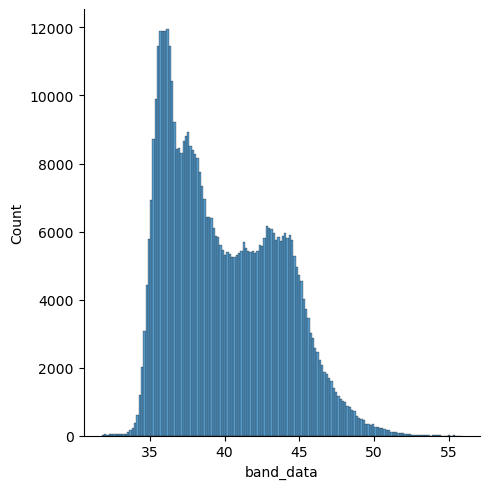

In [95]:
# checking the data
sns.displot(df2['band_data'])

In [96]:
# creating geometry 
geometry = [Point(xy) for xy in zip(df2.x, df2.y)]
# df = df.drop(['x', 'y'], axis=1)
gdf2 = GeoDataFrame(df2, crs="EPSG:32632", geometry=geometry)
gdf2

band         x          y  spatial_ref  band_data  \
0          1  462870.0  5533860.0            0  36.670937   
1          1  462870.0  5533830.0            0  36.482933   
2          1  462870.0  5533800.0            0  36.297466   
3          1  462870.0  5533770.0            0  36.152973   
4          1  462870.0  5533740.0            0  36.078018   
...      ...       ...        ...          ...        ...   
526677     1  488700.0  5515680.0            0  43.042164   
526678     1  488700.0  5515650.0            0  43.382786   
526679     1  488700.0  5515620.0            0  43.634087   
526680     1  488700.0  5515590.0            0  43.843239   
526681     1  488700.0  5515560.0            0  44.015282   

                      geometry  
0       POINT (462870 5533860)  
1       POINT (462870 5533830)  
2       POINT (462870 5533800)  
3       POINT (462870 5533770)  
4       POINT (462870 5533740)  
...                        ...  
526677  POINT (488700 5515680)  
526678  POINT (488700 5515650)  
526679  POINT (488700 5515620)  
526680  POINT (488700 5515590)  
526681  POINT (488700 5515560)  

[526682 rows x 6 columns]

<Axes: >

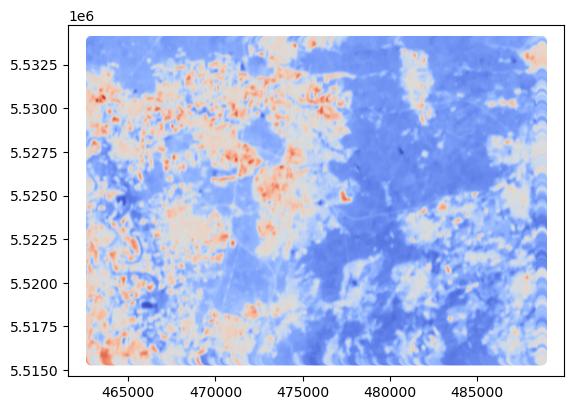

In [97]:
gdf2.plot(column='band_data', cmap='coolwarm')

<Axes: >

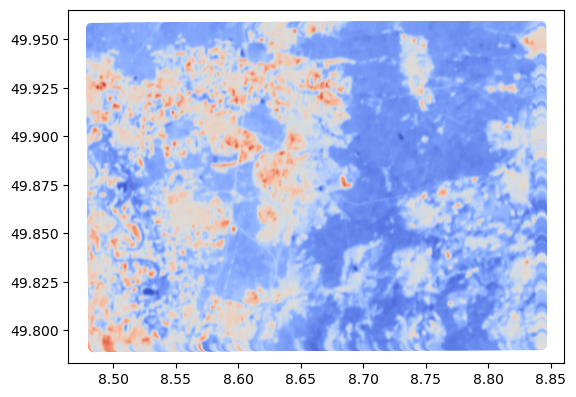

In [98]:
# changing crs to epsg:4326
gdf2.to_crs(crs='epsg:4326', inplace=True)
gdf2.plot(column='band_data', cmap='coolwarm')

In [99]:
# joining temp with hex9
gdf2_w_hex9 = gdf2.overlay(darm_hex9_fxd, how='intersection')
gdf2_w_hex9

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521800.0            0  42.497681  897a9321813ffff   
1          1  468300.0  5521770.0            0  42.804981  897a9321813ffff   
2          1  468300.0  5521740.0            0  43.135563  897a9321813ffff   
3          1  468300.0  5521710.0            0  43.167358  897a9321813ffff   
4          1  468300.0  5521680.0            0  42.880276  897a9321813ffff   
...      ...       ...        ...          ...        ...              ...   
135938     1  482070.0  5528040.0            0  35.793736  8963926cd93ffff   
135939     1  482070.0  5528010.0            0  35.651497  8963926cd93ffff   
135940     1  482070.0  5527980.0            0  35.545048  8963926cd93ffff   
135941     1  482070.0  5527950.0            0  35.483116  8963926cd93ffff   
135942     1  482100.0  5528070.0            0  35.904495  8963926cd93ffff   

                        geometry  
0       POINT (8.55907 49.84778)  
1       POINT (8.55907 49.84751)  
2       POINT (8.55907 49.84724)  
3       POINT (8.55907 49.84697)  
4        POINT (8.55908 49.8467)  
...                          ...  
135938  POINT (8.75031 49.90448)  
135939  POINT (8.75031 49.90421)  
135940  POINT (8.75031 49.90394)  
135941  POINT (8.75031 49.90367)  
135942  POINT (8.75073 49.90475)  

[135943 rows x 7 columns]

In [100]:
# calculating mean temp of hex9
gdf2_w_hex9_grp = gdf2_w_hex9.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf2_w_hex9_grp.rename(columns={"band_data": "HW_2"}, inplace=True)
gdf2_w_hex9_grp

hex_id       HW_2
0     8963926c323ffff  35.606571
1     8963926c327ffff  34.653027
2     8963926c32bffff  35.743927
3     8963926c32fffff  35.801430
4     8963926c333ffff  35.778221
...               ...        ...
2273  897a9366dcbffff  36.658890
2274  897a9366dcfffff  36.634796
2275  897a9366dd3ffff  36.475906
2276  897a9366dd7ffff  36.577744
2277  897a9366ddbffff  36.963966

[2278 rows x 2 columns]

In [101]:
pit9 = pit9.merge(gdf2_w_hex9_grp, on='hex_id')
pit9.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8963926d967ffff         NaN             NaN                    NaN   
1  8963926d96bffff         NaN             NaN                    NaN   
2  8963926d96fffff         NaN             NaN                    NaN   
3  8963926da2bffff         NaN             NaN             334.173365   
4  8963926da2fffff         NaN             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0            5998.331649              70.591067      6825.110809   
1              48.627892                    NaN              NaN   
2           11806.381376            7838.689081     11650.211475   
3            4867.465639                    NaN              NaN   
4                    NaN                    NaN              NaN   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                           5182.624977   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                                    NaN                    NaN   
3                                    NaN                    NaN   
4                                    NaN                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((477290.493 5526006.948, 477404.859 5...  53681.204005  29.838594   
1  POLYGON ((477149.611 5525546.057, 477263.994 5...  53692.410698  30.090197   
2  POLYGON ((477129.162 5525860.206, 477243.537 5...  53686.473523  31.541504   
3  POLYGON ((476465.019 5522926.877, 476579.491 5...  53754.404812  32.791145   
4  POLYGON ((476444.618 5523241.14, 476559.081 55...  53748.464832  30.724434   

        HW_2  
0  38.552288  
1  40.005802  
2  40.954422  
3  40.753078  
4  38.766953

In [102]:
# joining temp with hex8
gdf2_w_hex8 = gdf2.overlay(darm_hex8_fxd, how='intersection')
gdf2_w_hex8

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521560.0            0  41.227985  887a932181fffff   
1          1  468300.0  5521530.0            0  41.248005  887a932181fffff   
2          1  468300.0  5521500.0            0  41.460381  887a932181fffff   
3          1  468300.0  5521470.0            0  42.026066  887a932181fffff   
4          1  468300.0  5521440.0            0  42.611778  887a932181fffff   
...      ...       ...        ...          ...        ...              ...   
136606     1  482070.0  5528220.0            0  35.990356  8863926cd9fffff   
136607     1  482070.0  5528190.0            0  36.010860  8863926cd9fffff   
136608     1  482070.0  5528160.0            0  35.990513  8863926cd9fffff   
136609     1  482070.0  5528130.0            0  35.935905  8863926cd9fffff   
136610     1  482070.0  5528100.0            0  35.917885  8863926cd9fffff   

                        geometry  
0       POINT (8.55909 49.84562)  
1       POINT (8.55909 49.84535)  
2       POINT (8.55909 49.84509)  
3       POINT (8.55909 49.84482)  
4        POINT (8.5591 49.84455)  
...                          ...  
136606    POINT (8.7503 49.9061)  
136607   POINT (8.7503 49.90583)  
136608   POINT (8.7503 49.90556)  
136609  POINT (8.75031 49.90529)  
136610  POINT (8.75031 49.90502)  

[136611 rows x 7 columns]

In [103]:
# calculating mean temp of hex8
gdf2_w_hex8_grp = gdf2_w_hex8.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf2_w_hex8_grp.rename(columns={"band_data": "HW_2"}, inplace=True)
gdf2_w_hex8_grp

hex_id       HW_2
0    8863926c33fffff  35.522049
1    8863926c81fffff  35.763172
2    8863926c83fffff  35.774494
3    8863926c85fffff  35.744259
4    8863926c87fffff  35.814430
..               ...        ...
322  887a9366d5fffff  36.187637
323  887a9366d7fffff  38.639824
324  887a9366d9fffff  39.251305
325  887a9366dbfffff  41.374046
326  887a9366ddfffff  36.591194

[327 rows x 2 columns]

In [104]:
pit8 = pit8.merge(gdf2_w_hex8_grp, on='hex_id')
pit8.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8863926d97fffff         NaN             NaN                    NaN   
1  8863926da3fffff         NaN             NaN               1.402865   
2  8863926da7fffff         NaN             NaN           35070.086609   
3  8863926db1fffff         NaN             NaN                    NaN   
4  8863926db3fffff  922.635324             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           16621.459801            7528.525549     19959.579969   
1            4498.292880                    NaN              NaN   
2           20132.740288                    NaN     12414.954370   
3           79437.891126                    NaN      9377.362093   
4          153723.033194                    NaN      1692.195626   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                           6444.983305   
2                          14241.108956   
3                          16481.289669   
4                           8021.713419   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                            2172.225783                    NaN   
3                            5034.614558                    NaN   
4                                    NaN           13752.752536   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         625.885335                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry       hex_area  \
0  POLYGON ((477129.162 5525860.206, 477404.859 5...  375809.985090   
1  POLYGON ((476444.618 5523241.14, 476720.562 55...  376243.911556   
2  POLYGON ((476141.968 5522633.251, 476417.982 5...  376359.341929   
3  POLYGON ((476524.472 5524644.846, 476800.31 55...  376040.701582   
4  POLYGON ((476301.86 5525440.669, 476577.663 55...  375952.890176   

        HW_1       HW_2  
0  31.418055  40.754959  
1  30.027418  37.968319  
2  29.924324  38.008041  
3  31.437441  40.381416  
4  31.169531  40.260696

In [105]:
# joining temp with hex7
gdf2_w_hex7 = gdf2.overlay(darm_hex7_fxd, how='intersection')
gdf2_w_hex7

band         x          y  spatial_ref  band_data           hex_id  \
0          1  467790.0  5521650.0            0  38.574322  877a93218ffffff   
1          1  467790.0  5521620.0            0  39.453651  877a93218ffffff   
2          1  467790.0  5521590.0            0  41.090237  877a93218ffffff   
3          1  467790.0  5521560.0            0  42.827454  877a93218ffffff   
4          1  467790.0  5521530.0            0  43.958767  877a93218ffffff   
...      ...       ...        ...          ...        ...              ...   
131402     1  482040.0  5528280.0            0  36.091209  8763926cdffffff   
131403     1  482040.0  5528250.0            0  36.067905  8763926cdffffff   
131404     1  482070.0  5528400.0            0  36.723473  8763926cdffffff   
131405     1  482070.0  5528370.0            0  36.537247  8763926cdffffff   
131406     1  482070.0  5528340.0            0  36.382431  8763926cdffffff   

                        geometry  
0       POINT (8.55199 49.84641)  
1       POINT (8.55199 49.84614)  
2       POINT (8.55199 49.84587)  
3        POINT (8.55199 49.8456)  
4         POINT (8.552 49.84533)  
...                          ...  
131402  POINT (8.74988 49.90663)  
131403  POINT (8.74988 49.90636)  
131404  POINT (8.75029 49.90771)  
131405  POINT (8.75029 49.90745)  
131406   POINT (8.7503 49.90718)  

[131407 rows x 7 columns]

In [106]:
# calculating mean temp of hex7
gdf2_w_hex7_grp = gdf2_w_hex7.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf2_w_hex7_grp.rename(columns={"band_data": "HW_2"}, inplace=True)
gdf2_w_hex7_grp

hex_id       HW_2
0   8763926c8ffffff  35.728523
1   8763926c9ffffff  36.296902
2   8763926caffffff  35.424526
3   8763926cbffffff  36.059879
4   8763926cdffffff  36.180065
5   8763926ceffffff  35.872166
6   8763926d8ffffff  35.987545
7   8763926d9ffffff  39.127792
8   8763926daffffff  36.090363
9   8763926dbffffff  39.854946
10  8763926ddffffff  35.530079
11  877a93218ffffff  42.794685
12  877a9321bffffff  40.452812
13  877a93282ffffff  44.577995
14  877a93283ffffff  42.909931
15  877a93288ffffff  44.951012
16  877a93289ffffff  42.129917
17  877a9328affffff  43.041424
18  877a9328bffffff  41.567863
19  877a9328cffffff  45.617519
20  877a9328dffffff  44.104362
21  877a9328effffff  44.425823
22  877a93291ffffff  41.548164
23  877a93298ffffff  43.013485
24  877a93299ffffff  40.208988
25  877a9329affffff  41.901344
26  877a9329bffffff  38.556084
27  877a9329cffffff  43.610256
28  877a9329dffffff  43.619175
29  877a9329effffff  44.175526
30  877a932abffffff  39.121181
31  877a932d0ffffff  38.930378
32  877a932d4ffffff  39.678459
33  877a932d5ffffff  41.172462
34  877a932d6ffffff  36.961342
35  877a932f0ffffff  37.302986
36  877a932f2ffffff  40.700314
37  877a932f3ffffff  40.845673
38  877a932f4ffffff  40.313862
39  877a932f6ffffff  38.388771
40  877a9364dffffff  39.126209
41  877a93668ffffff  36.177120
42  877a93669ffffff  36.607731
43  877a9366bffffff  36.374813
44  877a9366dffffff  38.720181

In [107]:
pit7 = pit7.merge(gdf2_w_hex7_grp, on='hex_id')
pit7.head()

hex_id   EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8763926d9ffffff          NaN             NaN                    NaN   
1  8763926daffffff          NaN             NaN           35071.489564   
2  8763926dbffffff  2184.358476    24387.049186                    NaN   
3  877a93283ffffff          NaN             NaN                    NaN   
4  877a93288ffffff  9881.342029             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           10882.197440            4215.258953      9700.352304   
1           18563.273944                    NaN      8359.014671   
2          483684.259578            3209.713330     20795.953564   
3           19025.514696             152.324029     52366.232480   
4           36273.401777           28137.885941     24410.374269   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                          19423.655239   
2                          73978.330549   
3                          42133.740240   
4                         272346.726067   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                            2172.225783                    NaN   
2                           14915.682503          122973.167321   
3                                    NaN                    NaN   
4                            6901.611633          292124.265546   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4       25460.653446           2203.494021      337451.38577   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((477431.335 5526467.807, 478231.741 5...  2.630477e+06  30.660500   
1  POLYGON ((476444.618 5523241.14, 477245.812 55...  2.634322e+06  28.538870   
2  POLYGON ((476301.86 5525440.669, 477102.642 55...  2.632285e+06  30.932590   
3  POLYGON ((473616.065 5529984.33, 474416.36 552...  2.629788e+06  32.202457   
4  POLYGON ((473898.837 5525586.162, 474699.958 5...  2.633865e+06  35.067825   

        HW_2  
0  39.127792  
1  36.090363  
2  39.854946  
3  42.909931  
4  44.951012

In [108]:
# joining temp with hex6
gdf2_w_hex6 = gdf2.overlay(darm_hex6_fxd, how='intersection')
gdf2_w_hex6

band         x          y  spatial_ref  band_data           hex_id  \
0          1  466650.0  5520930.0            0  41.468380  867a9321fffffff   
1          1  466650.0  5520900.0            0  40.793339  867a9321fffffff   
2          1  466650.0  5520870.0            0  40.138000  867a9321fffffff   
3          1  466650.0  5520840.0            0  39.865326  867a9321fffffff   
4          1  466650.0  5520810.0            0  40.154530  867a9321fffffff   
...      ...       ...        ...          ...        ...              ...   
157386     1  482070.0  5528220.0            0  35.990356  8663926cfffffff   
157387     1  482070.0  5528190.0            0  36.010860  8663926cfffffff   
157388     1  482070.0  5528160.0            0  35.990513  8663926cfffffff   
157389     1  482070.0  5528130.0            0  35.935905  8663926cfffffff   
157390     1  482070.0  5528100.0            0  35.917885  8663926cfffffff   

                        geometry  
0       POINT (8.53619 49.83987)  
1        POINT (8.53619 49.8396)  
2        POINT (8.5362 49.83933)  
3        POINT (8.5362 49.83906)  
4        POINT (8.5362 49.83879)  
...                          ...  
157386    POINT (8.7503 49.9061)  
157387   POINT (8.7503 49.90583)  
157388   POINT (8.7503 49.90556)  
157389  POINT (8.75031 49.90529)  
157390  POINT (8.75031 49.90502)  

[157391 rows x 7 columns]

In [109]:
# calculating mean temp of hex6
gdf2_w_hex6_grp = gdf2_w_hex6.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf2_w_hex6_grp.rename(columns={"band_data": "HW_2"}, inplace=True)
gdf2_w_hex6_grp

hex_id       HW_2
0  8663926cfffffff  35.898781
1  8663926dfffffff  37.344666
2  867a9321fffffff  42.506210
3  867a9328fffffff  43.723404
4  867a9329fffffff  42.106445
5  867a932d7ffffff  38.124653
6  867a932f7ffffff  39.870174
7  867a9366fffffff  37.012138

In [110]:
pit6 = pit6.merge(gdf2_w_hex6_grp, on='hex_id')
pit6.head()

hex_id     EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8663926dfffffff     922.802293    50699.605012           35071.489564   
1  867a9328fffffff  267940.237753    98431.234978          211485.325680   
2  867a9329fffffff   19996.898504             NaN          308957.288471   
3  867a932d7ffffff            NaN             NaN           22035.917625   
4  867a932f7ffffff            NaN             NaN           59216.594967   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           6.199572e+05           39433.028030     65086.762080   
1           1.178889e+06          187608.050612    337257.313423   
2           9.743059e+05           39714.384270    643544.088894   
3           1.224552e+06           39401.843208    255943.403644   
4           4.229011e+05            2265.117032    141305.821266   

   EST3_row_structures_with_low_density  \
0                          7.795645e+04   
1                          1.261975e+06   
2                          3.160614e+05   
3                          3.428828e+05   
4                          5.775835e+04   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                           12968.175348           5.878773e+04   
1                           52839.505825           1.569654e+06   
2                          249408.171816                    NaN   
3                           31420.537407                    NaN   
4                            8997.551939                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         627.097848                   NaN               NaN   
1      294554.184609          31247.772468     345095.237183   
2      611503.156937                   NaN               NaN   
3      416284.831704                   NaN               NaN   
4      208036.456458                   NaN               NaN   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((476301.86 5525440.669, 478231.741 55...  1.842759e+07  29.327410   
1  POLYGON ((472626.528 5526759.169, 474558.114 5...  1.843705e+07  33.737103   
2  POLYGON ((474745.518 5531010.176, 476673.664 5...  1.839748e+07  31.742964   
3  POLYGON ((474181.965 5521185.811, 476115.288 5...  1.846719e+07  29.824053   
4  POLYGON ((470501.92 5522505.6, 472436.951 5523...  1.847668e+07  30.735737   

        HW_2  
0  37.344666  
1  43.723404  
2  42.106445  
3  38.124653  
4  39.870174

In [111]:
# joining temp with districts
gdf2_w_Dist = gdf2.overlay(darmstadt_std_shp, how='intersection')
gdf2_w_Dist

band         x          y  spatial_ref  band_data  OBJECTID  \
0          1  468240.0  5521830.0            0  42.174503        36   
1          1  468270.0  5521830.0            0  42.116997        36   
2          1  468270.0  5521800.0            0  42.219757        36   
3          1  468270.0  5521770.0            0  42.453037        36   
4          1  468270.0  5521740.0            0  42.819244        36   
...      ...       ...        ...          ...        ...       ...   
135557     1  482010.0  5527740.0            0  35.511486         7   
135558     1  482010.0  5527710.0            0  35.472614         7   
135559     1  482010.0  5527680.0            0  35.420761         7   
135560     1  482040.0  5527950.0            0  35.451912         7   
135561     1  482040.0  5527920.0            0  35.438679         7   

            Entity Layer  Color    Linetype  Elevation  LineWt RefName  \
0       LWPolyline  1001      7  Continuous        0.0      25    None   
1       LWPolyline  1001      7  Continuous        0.0      25    None   
2       LWPolyline  1001      7  Continuous        0.0      25    None   
3       LWPolyline  1001      7  Continuous        0.0      25    None   
4       LWPolyline  1001      7  Continuous        0.0      25    None   
...            ...   ...    ...         ...        ...     ...     ...   
135557  LWPolyline  1001      7  Continuous        0.0      25    None   
135558  LWPolyline  1001      7  Continuous        0.0      25    None   
135559  LWPolyline  1001      7  Continuous        0.0      25    None   
135560  LWPolyline  1001      7  Continuous        0.0      25    None   
135561  LWPolyline  1001      7  Continuous        0.0      25    None   

                   Name_Bezir    Shape_Leng    Shape_Area  \
0       540 Am Kavalleriesand  17662.149836  1.146508e+07   
1       540 Am Kavalleriesand  17662.149836  1.146508e+07   
2       540 Am Kavalleriesand  17662.149836  1.146508e+07   
3       540 Am Kavalleriesand  17662.149836  1.146508e+07   
4       540 Am Kavalleriesand  17662.149836  1.146508e+07   
...                       ...           ...           ...   
135557        310 Am Oberfeld  20788.406205  1.920096e+07   
135558        310 Am Oberfeld  20788.406205  1.920096e+07   
135559        310 Am Oberfeld  20788.406205  1.920096e+07   
135560        310 Am Oberfeld  20788.406205  1.920096e+07   
135561        310 Am Oberfeld  20788.406205  1.920096e+07   

                        geometry  
0       POINT (8.55823 49.84805)  
1       POINT (8.55865 49.84805)  
2       POINT (8.55865 49.84778)  
3       POINT (8.55865 49.84751)  
4       POINT (8.55865 49.84724)  
...                          ...  
135557  POINT (8.74949 49.90178)  
135558  POINT (8.74949 49.90151)  
135559  POINT (8.74949 49.90124)  
135560   POINT (8.7499 49.90367)  
135561    POINT (8.7499 49.9034)  

[135562 rows x 17 columns]

In [112]:
# calculating mean temp of hex6
gdf2_w_Dist_grp = gdf2_w_Dist.groupby(['Name_Bezir'], as_index=False)['band_data'].mean()
gdf2_w_Dist_grp.rename(columns={"band_data": "HW_2"}, inplace=True)
gdf2_w_Dist_grp

Name_Bezir       HW_2
0                     110 Stadtzentrum  45.670071
1            120 Rheintor/Grafenstraße  45.641220
2                 130 Hochschulviertel  43.415585
3               140 Kapellplatzviertel  43.720726
4   150 St. Ludwig mit Eichbergviertel  43.267216
5                  210 Johannesviertel  44.125946
6              220 Martinsviertel-West  43.611950
7               230 Martinsviertel-Ost  42.659412
8                      240 Waldkolonie  41.726585
9                  250 Mornewegviertel  45.969257
10             260 Pallaswiesenviertel  45.642666
11                  270 Am Ziegelbusch  41.785725
12                     310 Am Oberfeld  36.626621
13                   320 Mathildenhöhe  41.879005
14                    330 Woogsviertel  40.943008
15              340 An den Lichtwiesen  36.640942
16                   410 Paulusviertel  40.531292
17                   420 Alt-Bessungen  42.798752
18              430 An der Ludwigshöhe  37.194000
19                440 Lincoln-Siedlung  42.656338
20                   510 Am Südbahnhof  42.915295
21             520 Heimstättensiedlung  42.515083
22                 530 Verlegerviertel  43.924690
23               540 Am Kavalleriesand  41.309288
24                   610 Alt-Arheilgen  44.060287
25                   620 Arheilgen-Süd  42.829395
26                  630 Arheilgen-West  42.492687
27                   640 Arheilgen-Ost  42.587467
28                   710 Alt-Eberstadt  41.185600
29                 720 Am Lämmchesberg  40.231033
30                   730 Villenkolonie  38.592003
31                 740 Am Frankenstein  38.442234
32             750 Kirchtannensiedlung  40.731182
33                  810 Wixhausen-West  44.119057
34                   820 Wixhausen-Ost  38.742405
35                910 Kranichstein-Süd  41.333061
36               920 Kranichstein-Nord  37.582779

In [113]:
pitD_small = pitD_small.merge(gdf2_w_Dist_grp, on='Name_Bezir')
pitD_small.head()

Name_Bezir     EST11_park  EST12_cemetary  \
0                    110 Stadtzentrum    7370.186849             NaN   
1           120 Rheintor/Grafenstraße            NaN             NaN   
2                130 Hochschulviertel  113671.235126             NaN   
3              140 Kapellplatzviertel       1.259645             NaN   
4  150 St. Ludwig mit Eichbergviertel            NaN             NaN   

   EST13_alloment_garden  EST1A_detached_houses  EST1B_detached_houses  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN           11748.238663           33491.589152   
4                    NaN           37064.281641           20746.521595   

   EST2_row_houses  EST3_row_structures_with_low_density  \
0              NaN                                   NaN   
1              NaN                                   NaN   
2              NaN                                   NaN   
3      9814.215928                          51467.207186   
4     21350.298699                         187793.734718   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN           24185.537025   
1                                    NaN                    NaN   
2                                    NaN           30495.437374   
3                                    NaN          170223.321769   
4                                    NaN          187282.062266   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre      Dist_area  \
0                NaN          23495.041093     112451.093688  299855.114999   
1                NaN                   NaN     231176.416702  398359.549998   
2                NaN                   NaN               NaN  414414.554998   
3        1391.841472           7752.731375       1467.726794  496346.624997   
4       22669.619786                   NaN               NaN  719066.379996   

        HW_1       HW_2  
0  35.800507  45.670071  
1  35.462467  45.641220  
2  33.821999  43.415585  
3  34.337162  43.720726  
4  33.851768  43.267216

In [114]:
### Read in tiff temp file 22-08-2018
dataarray3 = xr.open_dataset('../data/Landsurface_Temperature/D_LST_20180822.tif', engine='rasterio')

# copy the data to dataframe
df3 = dataarray3.to_dataframe()
df3.reset_index(inplace=True)
df3

band         x          y  spatial_ref  band_data
0          1  462870.0  5533860.0            0  31.408089
1          1  462870.0  5533830.0            0  31.245398
2          1  462870.0  5533800.0            0  31.106644
3          1  462870.0  5533770.0            0  31.018536
4          1  462870.0  5533740.0            0  30.948891
...      ...       ...        ...          ...        ...
526677     1  488700.0  5515680.0            0  42.938938
526678     1  488700.0  5515650.0            0  42.297012
526679     1  488700.0  5515620.0            0  41.766991
526680     1  488700.0  5515590.0            0  41.722153
526681     1  488700.0  5515560.0            0  41.901913

[526682 rows x 5 columns]

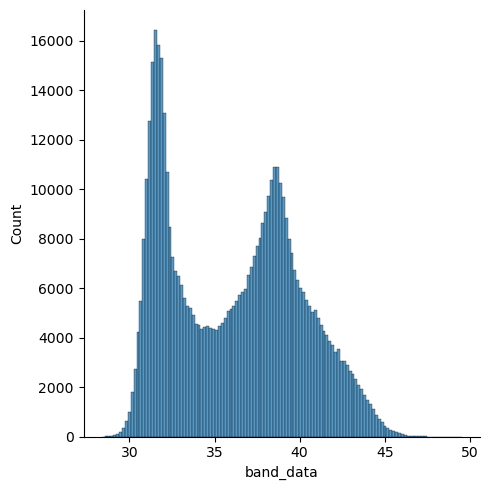

In [115]:
# checking the data
sns.displot(df3['band_data'])

In [116]:
# creating geometry 
geometry = [Point(xy) for xy in zip(df3.x, df3.y)]
# df = df.drop(['x', 'y'], axis=1)
gdf3 = GeoDataFrame(df3, crs="EPSG:32632", geometry=geometry)
gdf3

band         x          y  spatial_ref  band_data  \
0          1  462870.0  5533860.0            0  31.408089   
1          1  462870.0  5533830.0            0  31.245398   
2          1  462870.0  5533800.0            0  31.106644   
3          1  462870.0  5533770.0            0  31.018536   
4          1  462870.0  5533740.0            0  30.948891   
...      ...       ...        ...          ...        ...   
526677     1  488700.0  5515680.0            0  42.938938   
526678     1  488700.0  5515650.0            0  42.297012   
526679     1  488700.0  5515620.0            0  41.766991   
526680     1  488700.0  5515590.0            0  41.722153   
526681     1  488700.0  5515560.0            0  41.901913   

                      geometry  
0       POINT (462870 5533860)  
1       POINT (462870 5533830)  
2       POINT (462870 5533800)  
3       POINT (462870 5533770)  
4       POINT (462870 5533740)  
...                        ...  
526677  POINT (488700 5515680)  
526678  POINT (488700 5515650)  
526679  POINT (488700 5515620)  
526680  POINT (488700 5515590)  
526681  POINT (488700 5515560)  

[526682 rows x 6 columns]

<Axes: >

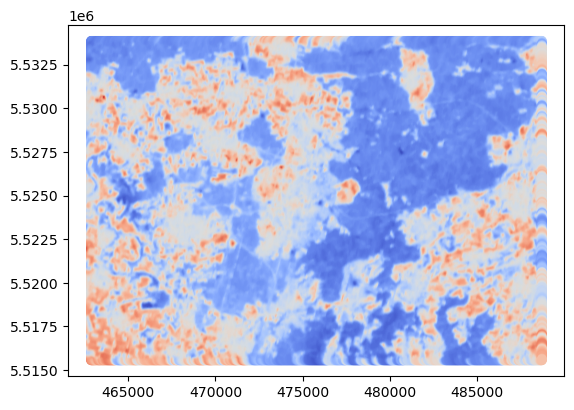

In [117]:
gdf3.plot(column='band_data', cmap='coolwarm')

<Axes: >

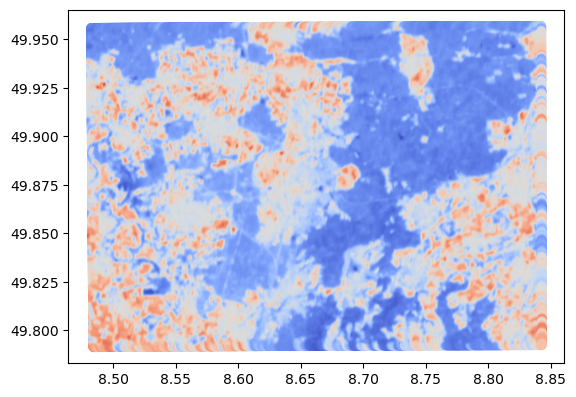

In [118]:
# changing crs to epsg:4326
gdf3.to_crs(crs='epsg:4326', inplace=True)
gdf3.plot(column='band_data', cmap='coolwarm')

In [119]:
# joining temp with hex9
gdf3_w_hex9 = gdf3.overlay(darm_hex9_fxd, how='intersection')
gdf3_w_hex9

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521800.0            0  39.716156  897a9321813ffff   
1          1  468300.0  5521770.0            0  39.423725  897a9321813ffff   
2          1  468300.0  5521740.0            0  39.812023  897a9321813ffff   
3          1  468300.0  5521710.0            0  40.702698  897a9321813ffff   
4          1  468300.0  5521680.0            0  41.610786  897a9321813ffff   
...      ...       ...        ...          ...        ...              ...   
135938     1  482070.0  5528040.0            0  31.370996  8963926cd93ffff   
135939     1  482070.0  5528010.0            0  31.275021  8963926cd93ffff   
135940     1  482070.0  5527980.0            0  31.128086  8963926cd93ffff   
135941     1  482070.0  5527950.0            0  30.986540  8963926cd93ffff   
135942     1  482100.0  5528070.0            0  31.250677  8963926cd93ffff   

                        geometry  
0       POINT (8.55907 49.84778)  
1       POINT (8.55907 49.84751)  
2       POINT (8.55907 49.84724)  
3       POINT (8.55907 49.84697)  
4        POINT (8.55908 49.8467)  
...                          ...  
135938  POINT (8.75031 49.90448)  
135939  POINT (8.75031 49.90421)  
135940  POINT (8.75031 49.90394)  
135941  POINT (8.75031 49.90367)  
135942  POINT (8.75073 49.90475)  

[135943 rows x 7 columns]

In [120]:
# calculating mean temp of hex9
gdf3_w_hex9_grp = gdf3_w_hex9.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf3_w_hex9_grp.rename(columns={"band_data": "HW_3"}, inplace=True)
gdf3_w_hex9_grp

hex_id       HW_3
0     8963926c323ffff  31.021589
1     8963926c327ffff  31.397150
2     8963926c32bffff  31.332920
3     8963926c32fffff  31.527683
4     8963926c333ffff  31.285032
...               ...        ...
2273  897a9366dcbffff  32.211273
2274  897a9366dcfffff  32.038116
2275  897a9366dd3ffff  32.010376
2276  897a9366dd7ffff  32.029774
2277  897a9366ddbffff  32.375473

[2278 rows x 2 columns]

In [121]:
pit9 = pit9.merge(gdf3_w_hex9_grp, on='hex_id')
pit9.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8963926d967ffff         NaN             NaN                    NaN   
1  8963926d96bffff         NaN             NaN                    NaN   
2  8963926d96fffff         NaN             NaN                    NaN   
3  8963926da2bffff         NaN             NaN             334.173365   
4  8963926da2fffff         NaN             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0            5998.331649              70.591067      6825.110809   
1              48.627892                    NaN              NaN   
2           11806.381376            7838.689081     11650.211475   
3            4867.465639                    NaN              NaN   
4                    NaN                    NaN              NaN   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                           5182.624977   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                                    NaN                    NaN   
3                                    NaN                    NaN   
4                                    NaN                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((477290.493 5526006.948, 477404.859 5...  53681.204005  29.838594   
1  POLYGON ((477149.611 5525546.057, 477263.994 5...  53692.410698  30.090197   
2  POLYGON ((477129.162 5525860.206, 477243.537 5...  53686.473523  31.541504   
3  POLYGON ((476465.019 5522926.877, 476579.491 5...  53754.404812  32.791145   
4  POLYGON ((476444.618 5523241.14, 476559.081 55...  53748.464832  30.724434   

        HW_2       HW_3  
0  38.552288  33.805782  
1  40.005802  38.112843  
2  40.954422  36.515518  
3  40.753078  35.644665  
4  38.766953  33.711040

In [122]:
# joining temp with hex8
gdf3_w_hex8 = gdf3.overlay(darm_hex8_fxd, how='intersection')
gdf3_w_hex8

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521560.0            0  41.804897  887a932181fffff   
1          1  468300.0  5521530.0            0  40.647755  887a932181fffff   
2          1  468300.0  5521500.0            0  39.335556  887a932181fffff   
3          1  468300.0  5521470.0            0  38.037758  887a932181fffff   
4          1  468300.0  5521440.0            0  36.893814  887a932181fffff   
...      ...       ...        ...          ...        ...              ...   
136606     1  482070.0  5528220.0            0  31.418869  8863926cd9fffff   
136607     1  482070.0  5528190.0            0  31.421783  8863926cd9fffff   
136608     1  482070.0  5528160.0            0  31.453772  8863926cd9fffff   
136609     1  482070.0  5528130.0            0  31.405458  8863926cd9fffff   
136610     1  482070.0  5528100.0            0  31.376135  8863926cd9fffff   

                        geometry  
0       POINT (8.55909 49.84562)  
1       POINT (8.55909 49.84535)  
2       POINT (8.55909 49.84509)  
3       POINT (8.55909 49.84482)  
4        POINT (8.5591 49.84455)  
...                          ...  
136606    POINT (8.7503 49.9061)  
136607   POINT (8.7503 49.90583)  
136608   POINT (8.7503 49.90556)  
136609  POINT (8.75031 49.90529)  
136610  POINT (8.75031 49.90502)  

[136611 rows x 7 columns]

In [123]:
# calculating mean temp of hex8
gdf3_w_hex8_grp = gdf3_w_hex8.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf3_w_hex8_grp.rename(columns={"band_data": "HW_3"}, inplace=True)
gdf3_w_hex8_grp

hex_id       HW_3
0    8863926c33fffff  31.221405
1    8863926c81fffff  31.547096
2    8863926c83fffff  31.358465
3    8863926c85fffff  31.601786
4    8863926c87fffff  31.752981
..               ...        ...
322  887a9366d5fffff  31.634802
323  887a9366d7fffff  34.179562
324  887a9366d9fffff  34.617752
325  887a9366dbfffff  36.449680
326  887a9366ddfffff  32.029457

[327 rows x 2 columns]

In [124]:
pit8 = pit8.merge(gdf3_w_hex8_grp, on='hex_id')
pit8.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8863926d97fffff         NaN             NaN                    NaN   
1  8863926da3fffff         NaN             NaN               1.402865   
2  8863926da7fffff         NaN             NaN           35070.086609   
3  8863926db1fffff         NaN             NaN                    NaN   
4  8863926db3fffff  922.635324             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           16621.459801            7528.525549     19959.579969   
1            4498.292880                    NaN              NaN   
2           20132.740288                    NaN     12414.954370   
3           79437.891126                    NaN      9377.362093   
4          153723.033194                    NaN      1692.195626   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                           6444.983305   
2                          14241.108956   
3                          16481.289669   
4                           8021.713419   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                            2172.225783                    NaN   
3                            5034.614558                    NaN   
4                                    NaN           13752.752536   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         625.885335                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry       hex_area  \
0  POLYGON ((477129.162 5525860.206, 477404.859 5...  375809.985090   
1  POLYGON ((476444.618 5523241.14, 476720.562 55...  376243.911556   
2  POLYGON ((476141.968 5522633.251, 476417.982 5...  376359.341929   
3  POLYGON ((476524.472 5524644.846, 476800.31 55...  376040.701582   
4  POLYGON ((476301.86 5525440.669, 476577.663 55...  375952.890176   

        HW_1       HW_2       HW_3  
0  31.418055  40.754959  38.266575  
1  30.027418  37.968319  33.359394  
2  29.924324  38.008041  33.053688  
3  31.437441  40.381416  35.511772  
4  31.169531  40.260696  35.432758

In [125]:
# joining temp with hex7
gdf3_w_hex7 = gdf3.overlay(darm_hex7_fxd, how='intersection')
gdf3_w_hex7

band         x          y  spatial_ref  band_data           hex_id  \
0          1  467790.0  5521650.0            0  37.764725  877a93218ffffff   
1          1  467790.0  5521620.0            0  38.656403  877a93218ffffff   
2          1  467790.0  5521590.0            0  39.231846  877a93218ffffff   
3          1  467790.0  5521560.0            0  39.629089  877a93218ffffff   
4          1  467790.0  5521530.0            0  39.858521  877a93218ffffff   
...      ...       ...        ...          ...        ...              ...   
131402     1  482040.0  5528280.0            0  31.530886  8763926cdffffff   
131403     1  482040.0  5528250.0            0  31.581415  8763926cdffffff   
131404     1  482070.0  5528400.0            0  31.643106  8763926cdffffff   
131405     1  482070.0  5528370.0            0  31.557392  8763926cdffffff   
131406     1  482070.0  5528340.0            0  31.498730  8763926cdffffff   

                        geometry  
0       POINT (8.55199 49.84641)  
1       POINT (8.55199 49.84614)  
2       POINT (8.55199 49.84587)  
3        POINT (8.55199 49.8456)  
4         POINT (8.552 49.84533)  
...                          ...  
131402  POINT (8.74988 49.90663)  
131403  POINT (8.74988 49.90636)  
131404  POINT (8.75029 49.90771)  
131405  POINT (8.75029 49.90745)  
131406   POINT (8.7503 49.90718)  

[131407 rows x 7 columns]

In [126]:
# calculating mean temp of hex7
gdf3_w_hex7_grp = gdf3_w_hex7.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf3_w_hex7_grp.rename(columns={"band_data": "HW_3"}, inplace=True)
gdf3_w_hex7_grp

hex_id       HW_3
0   8763926c8ffffff  31.428429
1   8763926c9ffffff  31.957045
2   8763926caffffff  31.432255
3   8763926cbffffff  31.721741
4   8763926cdffffff  31.859041
5   8763926ceffffff  32.444248
6   8763926d8ffffff  31.971489
7   8763926d9ffffff  37.202698
8   8763926daffffff  31.501644
9   8763926dbffffff  35.403851
10  8763926ddffffff  31.405716
11  877a93218ffffff  38.285027
12  877a9321bffffff  36.138256
13  877a93282ffffff  40.672886
14  877a93283ffffff  39.091614
15  877a93288ffffff  38.729660
16  877a93289ffffff  36.913364
17  877a9328affffff  37.589577
18  877a9328bffffff  36.251312
19  877a9328cffffff  39.583206
20  877a9328dffffff  38.300110
21  877a9328effffff  38.657333
22  877a93291ffffff  38.213852
23  877a93298ffffff  38.443089
24  877a93299ffffff  35.767399
25  877a9329affffff  37.587646
26  877a9329bffffff  34.016220
27  877a9329cffffff  39.453136
28  877a9329dffffff  38.688496
29  877a9329effffff  39.014538
30  877a932abffffff  34.168823
31  877a932d0ffffff  36.088211
32  877a932d4ffffff  35.560604
33  877a932d5ffffff  35.693111
34  877a932d6ffffff  32.691448
35  877a932f0ffffff  32.685326
36  877a932f2ffffff  35.715649
37  877a932f3ffffff  35.551163
38  877a932f4ffffff  35.676689
39  877a932f6ffffff  33.398857
40  877a9364dffffff  35.060520
41  877a93668ffffff  31.681469
42  877a93669ffffff  31.935228
43  877a9366bffffff  32.126049
44  877a9366dffffff  34.136536

In [127]:
pit7 = pit7.merge(gdf3_w_hex7_grp, on='hex_id')
pit7.head()

hex_id   EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8763926d9ffffff          NaN             NaN                    NaN   
1  8763926daffffff          NaN             NaN           35071.489564   
2  8763926dbffffff  2184.358476    24387.049186                    NaN   
3  877a93283ffffff          NaN             NaN                    NaN   
4  877a93288ffffff  9881.342029             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           10882.197440            4215.258953      9700.352304   
1           18563.273944                    NaN      8359.014671   
2          483684.259578            3209.713330     20795.953564   
3           19025.514696             152.324029     52366.232480   
4           36273.401777           28137.885941     24410.374269   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                          19423.655239   
2                          73978.330549   
3                          42133.740240   
4                         272346.726067   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                            2172.225783                    NaN   
2                           14915.682503          122973.167321   
3                                    NaN                    NaN   
4                            6901.611633          292124.265546   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4       25460.653446           2203.494021      337451.38577   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((477431.335 5526467.807, 478231.741 5...  2.630477e+06  30.660500   
1  POLYGON ((476444.618 5523241.14, 477245.812 55...  2.634322e+06  28.538870   
2  POLYGON ((476301.86 5525440.669, 477102.642 55...  2.632285e+06  30.932590   
3  POLYGON ((473616.065 5529984.33, 474416.36 552...  2.629788e+06  32.202457   
4  POLYGON ((473898.837 5525586.162, 474699.958 5...  2.633865e+06  35.067825   

        HW_2       HW_3  
0  39.127792  37.202698  
1  36.090363  31.501644  
2  39.854946  35.403851  
3  42.909931  39.091614  
4  44.951012  38.729660

In [128]:
# joining temp with hex6
gdf3_w_hex6 = gdf3.overlay(darm_hex6_fxd, how='intersection')
gdf3_w_hex6

band         x          y  spatial_ref  band_data           hex_id  \
0          1  466650.0  5520930.0            0  41.191181  867a9321fffffff   
1          1  466650.0  5520900.0            0  40.903515  867a9321fffffff   
2          1  466650.0  5520870.0            0  40.100197  867a9321fffffff   
3          1  466650.0  5520840.0            0  38.749874  867a9321fffffff   
4          1  466650.0  5520810.0            0  37.448616  867a9321fffffff   
...      ...       ...        ...          ...        ...              ...   
157386     1  482070.0  5528220.0            0  31.418869  8663926cfffffff   
157387     1  482070.0  5528190.0            0  31.421783  8663926cfffffff   
157388     1  482070.0  5528160.0            0  31.453772  8663926cfffffff   
157389     1  482070.0  5528130.0            0  31.405458  8663926cfffffff   
157390     1  482070.0  5528100.0            0  31.376135  8663926cfffffff   

                        geometry  
0       POINT (8.53619 49.83987)  
1        POINT (8.53619 49.8396)  
2        POINT (8.5362 49.83933)  
3        POINT (8.5362 49.83906)  
4        POINT (8.5362 49.83879)  
...                          ...  
157386    POINT (8.7503 49.9061)  
157387   POINT (8.7503 49.90583)  
157388   POINT (8.7503 49.90556)  
157389  POINT (8.75031 49.90529)  
157390  POINT (8.75031 49.90502)  

[157391 rows x 7 columns]

In [129]:
# calculating mean temp of hex6
gdf3_w_hex6_grp = gdf3_w_hex6.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf3_w_hex6_grp.rename(columns={"band_data": "HW_3"}, inplace=True)
gdf3_w_hex6_grp

hex_id       HW_3
0  8663926cfffffff  31.736912
1  8663926dfffffff  33.491508
2  867a9321fffffff  37.918373
3  867a9328fffffff  38.011215
4  867a9329fffffff  37.491119
5  867a932d7ffffff  34.045586
6  867a932f7ffffff  34.877201
7  867a9366fffffff  32.580109

In [130]:
pit6 = pit6.merge(gdf3_w_hex6_grp, on='hex_id')
pit6.head()

hex_id     EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8663926dfffffff     922.802293    50699.605012           35071.489564   
1  867a9328fffffff  267940.237753    98431.234978          211485.325680   
2  867a9329fffffff   19996.898504             NaN          308957.288471   
3  867a932d7ffffff            NaN             NaN           22035.917625   
4  867a932f7ffffff            NaN             NaN           59216.594967   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           6.199572e+05           39433.028030     65086.762080   
1           1.178889e+06          187608.050612    337257.313423   
2           9.743059e+05           39714.384270    643544.088894   
3           1.224552e+06           39401.843208    255943.403644   
4           4.229011e+05            2265.117032    141305.821266   

   EST3_row_structures_with_low_density  \
0                          7.795645e+04   
1                          1.261975e+06   
2                          3.160614e+05   
3                          3.428828e+05   
4                          5.775835e+04   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                           12968.175348           5.878773e+04   
1                           52839.505825           1.569654e+06   
2                          249408.171816                    NaN   
3                           31420.537407                    NaN   
4                            8997.551939                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         627.097848                   NaN               NaN   
1      294554.184609          31247.772468     345095.237183   
2      611503.156937                   NaN               NaN   
3      416284.831704                   NaN               NaN   
4      208036.456458                   NaN               NaN   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((476301.86 5525440.669, 478231.741 55...  1.842759e+07  29.327410   
1  POLYGON ((472626.528 5526759.169, 474558.114 5...  1.843705e+07  33.737103   
2  POLYGON ((474745.518 5531010.176, 476673.664 5...  1.839748e+07  31.742964   
3  POLYGON ((474181.965 5521185.811, 476115.288 5...  1.846719e+07  29.824053   
4  POLYGON ((470501.92 5522505.6, 472436.951 5523...  1.847668e+07  30.735737   

        HW_2       HW_3  
0  37.344666  33.491508  
1  43.723404  38.011215  
2  42.106445  37.491119  
3  38.124653  34.045586  
4  39.870174  34.877201

In [131]:
# joining temp with districts
gdf3_w_Dist = gdf3.overlay(darmstadt_std_shp, how='intersection')
gdf3_w_Dist

band         x          y  spatial_ref  band_data  OBJECTID  \
0          1  468240.0  5521830.0            0  39.530293        36   
1          1  468270.0  5521830.0            0  39.817451        36   
2          1  468270.0  5521800.0            0  39.410538        36   
3          1  468270.0  5521770.0            0  39.300041        36   
4          1  468270.0  5521740.0            0  39.696270        36   
...      ...       ...        ...          ...        ...       ...   
135557     1  482010.0  5527740.0            0  31.088091         7   
135558     1  482010.0  5527710.0            0  31.130978         7   
135559     1  482010.0  5527680.0            0  31.189552         7   
135560     1  482040.0  5527950.0            0  30.975895         7   
135561     1  482040.0  5527920.0            0  30.874010         7   

            Entity Layer  Color    Linetype  Elevation  LineWt RefName  \
0       LWPolyline  1001      7  Continuous        0.0      25    None   
1       LWPolyline  1001      7  Continuous        0.0      25    None   
2       LWPolyline  1001      7  Continuous        0.0      25    None   
3       LWPolyline  1001      7  Continuous        0.0      25    None   
4       LWPolyline  1001      7  Continuous        0.0      25    None   
...            ...   ...    ...         ...        ...     ...     ...   
135557  LWPolyline  1001      7  Continuous        0.0      25    None   
135558  LWPolyline  1001      7  Continuous        0.0      25    None   
135559  LWPolyline  1001      7  Continuous        0.0      25    None   
135560  LWPolyline  1001      7  Continuous        0.0      25    None   
135561  LWPolyline  1001      7  Continuous        0.0      25    None   

                   Name_Bezir    Shape_Leng    Shape_Area  \
0       540 Am Kavalleriesand  17662.149836  1.146508e+07   
1       540 Am Kavalleriesand  17662.149836  1.146508e+07   
2       540 Am Kavalleriesand  17662.149836  1.146508e+07   
3       540 Am Kavalleriesand  17662.149836  1.146508e+07   
4       540 Am Kavalleriesand  17662.149836  1.146508e+07   
...                       ...           ...           ...   
135557        310 Am Oberfeld  20788.406205  1.920096e+07   
135558        310 Am Oberfeld  20788.406205  1.920096e+07   
135559        310 Am Oberfeld  20788.406205  1.920096e+07   
135560        310 Am Oberfeld  20788.406205  1.920096e+07   
135561        310 Am Oberfeld  20788.406205  1.920096e+07   

                        geometry  
0       POINT (8.55823 49.84805)  
1       POINT (8.55865 49.84805)  
2       POINT (8.55865 49.84778)  
3       POINT (8.55865 49.84751)  
4       POINT (8.55865 49.84724)  
...                          ...  
135557  POINT (8.74949 49.90178)  
135558  POINT (8.74949 49.90151)  
135559  POINT (8.74949 49.90124)  
135560   POINT (8.7499 49.90367)  
135561    POINT (8.7499 49.9034)  

[135562 rows x 17 columns]

In [132]:
# calculating mean temp of hex6
gdf3_w_Dist_grp = gdf3_w_Dist.groupby(['Name_Bezir'], as_index=False)['band_data'].mean()
gdf3_w_Dist_grp.rename(columns={"band_data": "HW_3"}, inplace=True)
gdf3_w_Dist_grp

Name_Bezir       HW_3
0                     110 Stadtzentrum  39.336338
1            120 Rheintor/Grafenstraße  39.039982
2                 130 Hochschulviertel  38.105221
3               140 Kapellplatzviertel  37.693356
4   150 St. Ludwig mit Eichbergviertel  37.510578
5                  210 Johannesviertel  38.049030
6              220 Martinsviertel-West  37.695557
7               230 Martinsviertel-Ost  36.916275
8                      240 Waldkolonie  36.346485
9                  250 Mornewegviertel  39.380424
10             260 Pallaswiesenviertel  39.495102
11                  270 Am Ziegelbusch  37.239521
12                     310 Am Oberfeld  32.819370
13                   320 Mathildenhöhe  36.535553
14                    330 Woogsviertel  35.978138
15              340 An den Lichtwiesen  32.321484
16                   410 Paulusviertel  35.446640
17                   420 Alt-Bessungen  37.282959
18              430 An der Ludwigshöhe  32.526241
19                440 Lincoln-Siedlung  37.500187
20                   510 Am Südbahnhof  37.795517
21             520 Heimstättensiedlung  37.267509
22                 530 Verlegerviertel  38.304298
23               540 Am Kavalleriesand  36.651249
24                   610 Alt-Arheilgen  38.913189
25                   620 Arheilgen-Süd  38.429974
26                  630 Arheilgen-West  38.294601
27                   640 Arheilgen-Ost  38.510868
28                   710 Alt-Eberstadt  37.170895
29                 720 Am Lämmchesberg  34.903313
30                   730 Villenkolonie  34.524105
31                 740 Am Frankenstein  33.791477
32             750 Kirchtannensiedlung  35.269936
33                  810 Wixhausen-West  40.164764
34                   820 Wixhausen-Ost  34.394093
35                910 Kranichstein-Süd  36.539043
36               920 Kranichstein-Nord  33.004566

In [133]:
pitD_small = pitD_small.merge(gdf3_w_Dist_grp, on='Name_Bezir')
pitD_small.head()

Name_Bezir     EST11_park  EST12_cemetary  \
0                    110 Stadtzentrum    7370.186849             NaN   
1           120 Rheintor/Grafenstraße            NaN             NaN   
2                130 Hochschulviertel  113671.235126             NaN   
3              140 Kapellplatzviertel       1.259645             NaN   
4  150 St. Ludwig mit Eichbergviertel            NaN             NaN   

   EST13_alloment_garden  EST1A_detached_houses  EST1B_detached_houses  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN           11748.238663           33491.589152   
4                    NaN           37064.281641           20746.521595   

   EST2_row_houses  EST3_row_structures_with_low_density  \
0              NaN                                   NaN   
1              NaN                                   NaN   
2              NaN                                   NaN   
3      9814.215928                          51467.207186   
4     21350.298699                         187793.734718   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN           24185.537025   
1                                    NaN                    NaN   
2                                    NaN           30495.437374   
3                                    NaN          170223.321769   
4                                    NaN          187282.062266   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre      Dist_area  \
0                NaN          23495.041093     112451.093688  299855.114999   
1                NaN                   NaN     231176.416702  398359.549998   
2                NaN                   NaN               NaN  414414.554998   
3        1391.841472           7752.731375       1467.726794  496346.624997   
4       22669.619786                   NaN               NaN  719066.379996   

        HW_1       HW_2       HW_3  
0  35.800507  45.670071  39.336338  
1  35.462467  45.641220  39.039982  
2  33.821999  43.415585  38.105221  
3  34.337162  43.720726  37.693356  
4  33.851768  43.267216  37.510578

In [134]:
### Read in tiff temp file 06-08-2018
dataarray4 = xr.open_dataset('../data/Landsurface_Temperature/D_LST_20180806.tif', engine='rasterio')

# copy the data to dataframe
df4 = dataarray4.to_dataframe()
df4.reset_index(inplace=True)
df4

band         x          y  spatial_ref  band_data
0          1  462870.0  5533860.0            0  33.170158
1          1  462870.0  5533830.0            0  33.014725
2          1  462870.0  5533800.0            0  32.880299
3          1  462870.0  5533770.0            0  32.769436
4          1  462870.0  5533740.0            0  32.663670
...      ...       ...        ...          ...        ...
526677     1  488700.0  5515680.0            0  41.951843
526678     1  488700.0  5515650.0            0  42.463406
526679     1  488700.0  5515620.0            0  42.836517
526680     1  488700.0  5515590.0            0  43.037178
526681     1  488700.0  5515560.0            0  43.010376

[526682 rows x 5 columns]

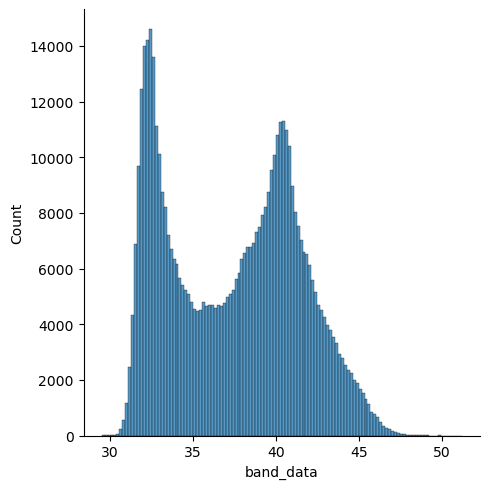

In [135]:
# checking the data
sns.displot(df4['band_data'])

In [136]:
# creating geometry 
geometry = [Point(xy) for xy in zip(df4.x, df4.y)]
# df = df.drop(['x', 'y'], axis=1)
gdf4 = GeoDataFrame(df4, crs="EPSG:32632", geometry=geometry)
gdf4

band         x          y  spatial_ref  band_data  \
0          1  462870.0  5533860.0            0  33.170158   
1          1  462870.0  5533830.0            0  33.014725   
2          1  462870.0  5533800.0            0  32.880299   
3          1  462870.0  5533770.0            0  32.769436   
4          1  462870.0  5533740.0            0  32.663670   
...      ...       ...        ...          ...        ...   
526677     1  488700.0  5515680.0            0  41.951843   
526678     1  488700.0  5515650.0            0  42.463406   
526679     1  488700.0  5515620.0            0  42.836517   
526680     1  488700.0  5515590.0            0  43.037178   
526681     1  488700.0  5515560.0            0  43.010376   

                      geometry  
0       POINT (462870 5533860)  
1       POINT (462870 5533830)  
2       POINT (462870 5533800)  
3       POINT (462870 5533770)  
4       POINT (462870 5533740)  
...                        ...  
526677  POINT (488700 5515680)  
526678  POINT (488700 5515650)  
526679  POINT (488700 5515620)  
526680  POINT (488700 5515590)  
526681  POINT (488700 5515560)  

[526682 rows x 6 columns]

<Axes: >

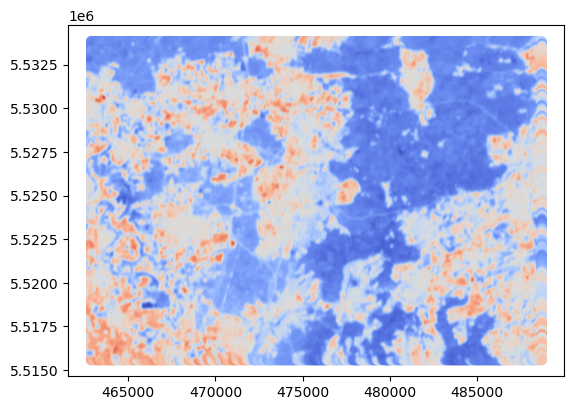

In [137]:
gdf4.plot(column='band_data', cmap='coolwarm')

<Axes: >

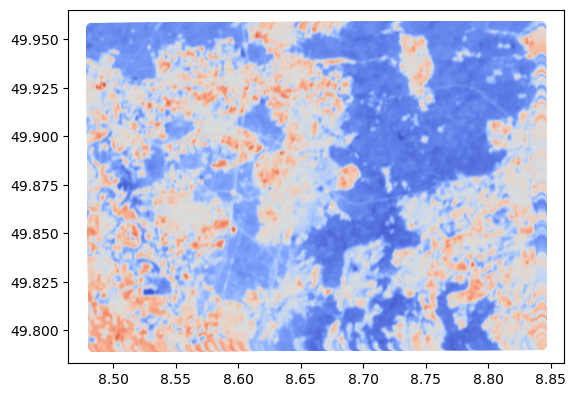

In [138]:
# changing crs to epsg:4326
gdf4.to_crs(crs='epsg:4326', inplace=True)
gdf4.plot(column='band_data', cmap='coolwarm')

In [139]:
# joining temp with hex9
gdf4_w_hex9 = gdf4.overlay(darm_hex9_fxd, how='intersection')
gdf4_w_hex9

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521800.0            0  40.862858  897a9321813ffff   
1          1  468300.0  5521770.0            0  40.978466  897a9321813ffff   
2          1  468300.0  5521740.0            0  41.681942  897a9321813ffff   
3          1  468300.0  5521710.0            0  42.787601  897a9321813ffff   
4          1  468300.0  5521680.0            0  43.796978  897a9321813ffff   
...      ...       ...        ...          ...        ...              ...   
135938     1  482070.0  5528040.0            0  32.579250  8963926cd93ffff   
135939     1  482070.0  5528010.0            0  32.346386  8963926cd93ffff   
135940     1  482070.0  5527980.0            0  32.054653  8963926cd93ffff   
135941     1  482070.0  5527950.0            0  31.834377  8963926cd93ffff   
135942     1  482100.0  5528070.0            0  32.451931  8963926cd93ffff   

                        geometry  
0       POINT (8.55907 49.84778)  
1       POINT (8.55907 49.84751)  
2       POINT (8.55907 49.84724)  
3       POINT (8.55907 49.84697)  
4        POINT (8.55908 49.8467)  
...                          ...  
135938  POINT (8.75031 49.90448)  
135939  POINT (8.75031 49.90421)  
135940  POINT (8.75031 49.90394)  
135941  POINT (8.75031 49.90367)  
135942  POINT (8.75073 49.90475)  

[135943 rows x 7 columns]

In [140]:
# calculating mean temp of hex9
gdf4_w_hex9_grp = gdf4_w_hex9.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf4_w_hex9_grp.rename(columns={"band_data": "HW_4"}, inplace=True)
gdf4_w_hex9_grp

hex_id       HW_4
0     8963926c323ffff  31.822390
1     8963926c327ffff  31.764429
2     8963926c32bffff  32.067741
3     8963926c32fffff  32.471748
4     8963926c333ffff  32.366421
...               ...        ...
2273  897a9366dcbffff  33.079971
2274  897a9366dcfffff  32.858597
2275  897a9366dd3ffff  33.046623
2276  897a9366dd7ffff  33.010262
2277  897a9366ddbffff  33.381168

[2278 rows x 2 columns]

In [141]:
pit9 = pit9.merge(gdf4_w_hex9_grp, on='hex_id')
pit9.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8963926d967ffff         NaN             NaN                    NaN   
1  8963926d96bffff         NaN             NaN                    NaN   
2  8963926d96fffff         NaN             NaN                    NaN   
3  8963926da2bffff         NaN             NaN             334.173365   
4  8963926da2fffff         NaN             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0            5998.331649              70.591067      6825.110809   
1              48.627892                    NaN              NaN   
2           11806.381376            7838.689081     11650.211475   
3            4867.465639                    NaN              NaN   
4                    NaN                    NaN              NaN   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                           5182.624977   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                                    NaN                    NaN   
3                                    NaN                    NaN   
4                                    NaN                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((477290.493 5526006.948, 477404.859 5...  53681.204005  29.838594   
1  POLYGON ((477149.611 5525546.057, 477263.994 5...  53692.410698  30.090197   
2  POLYGON ((477129.162 5525860.206, 477243.537 5...  53686.473523  31.541504   
3  POLYGON ((476465.019 5522926.877, 476579.491 5...  53754.404812  32.791145   
4  POLYGON ((476444.618 5523241.14, 476559.081 55...  53748.464832  30.724434   

        HW_2       HW_3       HW_4  
0  38.552288  33.805782  35.329655  
1  40.005802  38.112843  40.148472  
2  40.954422  36.515518  38.647854  
3  40.753078  35.644665  37.387890  
4  38.766953  33.711040  35.695545

In [142]:
# joining temp with hex8
gdf4_w_hex8 = gdf4.overlay(darm_hex8_fxd, how='intersection')
gdf4_w_hex8

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521560.0            0  44.997353  887a932181fffff   
1          1  468300.0  5521530.0            0  43.717850  887a932181fffff   
2          1  468300.0  5521500.0            0  42.631805  887a932181fffff   
3          1  468300.0  5521470.0            0  41.854321  887a932181fffff   
4          1  468300.0  5521440.0            0  41.328335  887a932181fffff   
...      ...       ...        ...          ...        ...              ...   
136606     1  482070.0  5528220.0            0  32.070644  8863926cd9fffff   
136607     1  482070.0  5528190.0            0  32.213844  8863926cd9fffff   
136608     1  482070.0  5528160.0            0  32.388912  8863926cd9fffff   
136609     1  482070.0  5528130.0            0  32.502399  8863926cd9fffff   
136610     1  482070.0  5528100.0            0  32.608246  8863926cd9fffff   

                        geometry  
0       POINT (8.55909 49.84562)  
1       POINT (8.55909 49.84535)  
2       POINT (8.55909 49.84509)  
3       POINT (8.55909 49.84482)  
4        POINT (8.5591 49.84455)  
...                          ...  
136606    POINT (8.7503 49.9061)  
136607   POINT (8.7503 49.90583)  
136608   POINT (8.7503 49.90556)  
136609  POINT (8.75031 49.90529)  
136610  POINT (8.75031 49.90502)  

[136611 rows x 7 columns]

In [143]:
# calculating mean temp of hex8
gdf4_w_hex8_grp = gdf4_w_hex8.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf4_w_hex8_grp.rename(columns={"band_data": "HW_4"}, inplace=True)
gdf4_w_hex8_grp

hex_id       HW_4
0    8863926c33fffff  32.064232
1    8863926c81fffff  32.209518
2    8863926c83fffff  32.113159
3    8863926c85fffff  32.268581
4    8863926c87fffff  32.502834
..               ...        ...
322  887a9366d5fffff  32.382809
323  887a9366d7fffff  34.911873
324  887a9366d9fffff  35.681183
325  887a9366dbfffff  38.039322
326  887a9366ddfffff  32.966515

[327 rows x 2 columns]

In [144]:
pit8 = pit8.merge(gdf4_w_hex8_grp, on='hex_id')
pit8.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8863926d97fffff         NaN             NaN                    NaN   
1  8863926da3fffff         NaN             NaN               1.402865   
2  8863926da7fffff         NaN             NaN           35070.086609   
3  8863926db1fffff         NaN             NaN                    NaN   
4  8863926db3fffff  922.635324             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           16621.459801            7528.525549     19959.579969   
1            4498.292880                    NaN              NaN   
2           20132.740288                    NaN     12414.954370   
3           79437.891126                    NaN      9377.362093   
4          153723.033194                    NaN      1692.195626   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                           6444.983305   
2                          14241.108956   
3                          16481.289669   
4                           8021.713419   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                            2172.225783                    NaN   
3                            5034.614558                    NaN   
4                                    NaN           13752.752536   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         625.885335                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry       hex_area  \
0  POLYGON ((477129.162 5525860.206, 477404.859 5...  375809.985090   
1  POLYGON ((476444.618 5523241.14, 476720.562 55...  376243.911556   
2  POLYGON ((476141.968 5522633.251, 476417.982 5...  376359.341929   
3  POLYGON ((476524.472 5524644.846, 476800.31 55...  376040.701582   
4  POLYGON ((476301.86 5525440.669, 476577.663 55...  375952.890176   

        HW_1       HW_2       HW_3       HW_4  
0  31.418055  40.754959  38.266575  39.740276  
1  30.027418  37.968319  33.359394  35.053707  
2  29.924324  38.008041  33.053688  34.657207  
3  31.437441  40.381416  35.511772  37.490078  
4  31.169531  40.260696  35.432758  37.357365

In [145]:
# joining temp with hex7
gdf4_w_hex7 = gdf4.overlay(darm_hex7_fxd, how='intersection')
gdf4_w_hex7

band         x          y  spatial_ref  band_data           hex_id  \
0          1  467790.0  5521650.0            0  38.912792  877a93218ffffff   
1          1  467790.0  5521620.0            0  39.530426  877a93218ffffff   
2          1  467790.0  5521590.0            0  40.019695  877a93218ffffff   
3          1  467790.0  5521560.0            0  40.429672  877a93218ffffff   
4          1  467790.0  5521530.0            0  40.647964  877a93218ffffff   
...      ...       ...        ...          ...        ...              ...   
131402     1  482040.0  5528280.0            0  32.126396  8763926cdffffff   
131403     1  482040.0  5528250.0            0  32.200649  8763926cdffffff   
131404     1  482070.0  5528400.0            0  32.748978  8763926cdffffff   
131405     1  482070.0  5528370.0            0  32.391273  8763926cdffffff   
131406     1  482070.0  5528340.0            0  32.086330  8763926cdffffff   

                        geometry  
0       POINT (8.55199 49.84641)  
1       POINT (8.55199 49.84614)  
2       POINT (8.55199 49.84587)  
3        POINT (8.55199 49.8456)  
4         POINT (8.552 49.84533)  
...                          ...  
131402  POINT (8.74988 49.90663)  
131403  POINT (8.74988 49.90636)  
131404  POINT (8.75029 49.90771)  
131405  POINT (8.75029 49.90745)  
131406   POINT (8.7503 49.90718)  

[131407 rows x 7 columns]

In [146]:
# calculating mean temp of hex7
gdf4_w_hex7_grp = gdf4_w_hex7.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf4_w_hex7_grp.rename(columns={"band_data": "HW_4"}, inplace=True)
gdf4_w_hex7_grp

hex_id       HW_4
0   8763926c8ffffff  32.160786
1   8763926c9ffffff  32.678272
2   8763926caffffff  32.318062
3   8763926cbffffff  32.434547
4   8763926cdffffff  32.748199
5   8763926ceffffff  33.438915
6   8763926d8ffffff  33.217262
7   8763926d9ffffff  38.374813
8   8763926daffffff  32.758545
9   8763926dbffffff  37.380898
10  8763926ddffffff  32.282185
11  877a93218ffffff  40.163097
12  877a9321bffffff  37.850094
13  877a93282ffffff  41.250595
14  877a93283ffffff  40.924622
15  877a93288ffffff  40.860596
16  877a93289ffffff  39.029617
17  877a9328affffff  39.583176
18  877a9328bffffff  38.253376
19  877a9328cffffff  41.709625
20  877a9328dffffff  40.317009
21  877a9328effffff  40.476467
22  877a93291ffffff  38.779064
23  877a93298ffffff  39.770470
24  877a93299ffffff  37.417370
25  877a9329affffff  38.510765
26  877a9329bffffff  35.243496
27  877a9329cffffff  41.008400
28  877a9329dffffff  40.557465
29  877a9329effffff  40.209663
30  877a932abffffff  35.724442
31  877a932d0ffffff  37.669273
32  877a932d4ffffff  37.256199
33  877a932d5ffffff  37.694218
34  877a932d6ffffff  34.100712
35  877a932f0ffffff  33.967102
36  877a932f2ffffff  37.383244
37  877a932f3ffffff  37.325500
38  877a932f4ffffff  37.441017
39  877a932f6ffffff  34.776138
40  877a9364dffffff  35.998352
41  877a93668ffffff  32.408817
42  877a93669ffffff  32.605213
43  877a9366bffffff  32.841080
44  877a9366dffffff  35.209469

In [147]:
pit7 = pit7.merge(gdf4_w_hex7_grp, on='hex_id')
pit7.head()

hex_id   EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8763926d9ffffff          NaN             NaN                    NaN   
1  8763926daffffff          NaN             NaN           35071.489564   
2  8763926dbffffff  2184.358476    24387.049186                    NaN   
3  877a93283ffffff          NaN             NaN                    NaN   
4  877a93288ffffff  9881.342029             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           10882.197440            4215.258953      9700.352304   
1           18563.273944                    NaN      8359.014671   
2          483684.259578            3209.713330     20795.953564   
3           19025.514696             152.324029     52366.232480   
4           36273.401777           28137.885941     24410.374269   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                          19423.655239   
2                          73978.330549   
3                          42133.740240   
4                         272346.726067   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                            2172.225783                    NaN   
2                           14915.682503          122973.167321   
3                                    NaN                    NaN   
4                            6901.611633          292124.265546   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4       25460.653446           2203.494021      337451.38577   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((477431.335 5526467.807, 478231.741 5...  2.630477e+06  30.660500   
1  POLYGON ((476444.618 5523241.14, 477245.812 55...  2.634322e+06  28.538870   
2  POLYGON ((476301.86 5525440.669, 477102.642 55...  2.632285e+06  30.932590   
3  POLYGON ((473616.065 5529984.33, 474416.36 552...  2.629788e+06  32.202457   
4  POLYGON ((473898.837 5525586.162, 474699.958 5...  2.633865e+06  35.067825   

        HW_2       HW_3       HW_4  
0  39.127792  37.202698  38.374813  
1  36.090363  31.501644  32.758545  
2  39.854946  35.403851  37.380898  
3  42.909931  39.091614  40.924622  
4  44.951012  38.729660  40.860596

In [148]:
# joining temp with hex6
gdf4_w_hex6 = gdf4.overlay(darm_hex6_fxd, how='intersection')
gdf4_w_hex6

band         x          y  spatial_ref  band_data           hex_id  \
0          1  466650.0  5520930.0            0  40.331291  867a9321fffffff   
1          1  466650.0  5520900.0            0  40.349228  867a9321fffffff   
2          1  466650.0  5520870.0            0  39.984394  867a9321fffffff   
3          1  466650.0  5520840.0            0  39.504608  867a9321fffffff   
4          1  466650.0  5520810.0            0  39.215645  867a9321fffffff   
...      ...       ...        ...          ...        ...              ...   
157386     1  482070.0  5528220.0            0  32.070644  8663926cfffffff   
157387     1  482070.0  5528190.0            0  32.213844  8663926cfffffff   
157388     1  482070.0  5528160.0            0  32.388912  8663926cfffffff   
157389     1  482070.0  5528130.0            0  32.502399  8663926cfffffff   
157390     1  482070.0  5528100.0            0  32.608246  8663926cfffffff   

                        geometry  
0       POINT (8.53619 49.83987)  
1        POINT (8.53619 49.8396)  
2        POINT (8.5362 49.83933)  
3        POINT (8.5362 49.83906)  
4        POINT (8.5362 49.83879)  
...                          ...  
157386    POINT (8.7503 49.9061)  
157387   POINT (8.7503 49.90583)  
157388   POINT (8.7503 49.90556)  
157389  POINT (8.75031 49.90529)  
157390  POINT (8.75031 49.90502)  

[157391 rows x 7 columns]

In [149]:
# calculating mean temp of hex6
gdf4_w_hex6_grp = gdf4_w_hex6.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf4_w_hex6_grp.rename(columns={"band_data": "HW_4"}, inplace=True)
gdf4_w_hex6_grp

hex_id       HW_4
0  8663926cfffffff  32.561512
1  8663926dfffffff  34.755138
2  867a9321fffffff  39.824249
3  867a9328fffffff  40.049339
4  867a9329fffffff  38.881802
5  867a932d7ffffff  35.631004
6  867a932f7ffffff  36.444481
7  867a9366fffffff  33.399044

In [150]:
pit6 = pit6.merge(gdf4_w_hex6_grp, on='hex_id')
pit6.head()

hex_id     EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8663926dfffffff     922.802293    50699.605012           35071.489564   
1  867a9328fffffff  267940.237753    98431.234978          211485.325680   
2  867a9329fffffff   19996.898504             NaN          308957.288471   
3  867a932d7ffffff            NaN             NaN           22035.917625   
4  867a932f7ffffff            NaN             NaN           59216.594967   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           6.199572e+05           39433.028030     65086.762080   
1           1.178889e+06          187608.050612    337257.313423   
2           9.743059e+05           39714.384270    643544.088894   
3           1.224552e+06           39401.843208    255943.403644   
4           4.229011e+05            2265.117032    141305.821266   

   EST3_row_structures_with_low_density  \
0                          7.795645e+04   
1                          1.261975e+06   
2                          3.160614e+05   
3                          3.428828e+05   
4                          5.775835e+04   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                           12968.175348           5.878773e+04   
1                           52839.505825           1.569654e+06   
2                          249408.171816                    NaN   
3                           31420.537407                    NaN   
4                            8997.551939                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         627.097848                   NaN               NaN   
1      294554.184609          31247.772468     345095.237183   
2      611503.156937                   NaN               NaN   
3      416284.831704                   NaN               NaN   
4      208036.456458                   NaN               NaN   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((476301.86 5525440.669, 478231.741 55...  1.842759e+07  29.327410   
1  POLYGON ((472626.528 5526759.169, 474558.114 5...  1.843705e+07  33.737103   
2  POLYGON ((474745.518 5531010.176, 476673.664 5...  1.839748e+07  31.742964   
3  POLYGON ((474181.965 5521185.811, 476115.288 5...  1.846719e+07  29.824053   
4  POLYGON ((470501.92 5522505.6, 472436.951 5523...  1.847668e+07  30.735737   

        HW_2       HW_3       HW_4  
0  37.344666  33.491508  34.755138  
1  43.723404  38.011215  40.049339  
2  42.106445  37.491119  38.881802  
3  38.124653  34.045586  35.631004  
4  39.870174  34.877201  36.444481

In [151]:
# joining temp with districts
gdf4_w_Dist = gdf4.overlay(darmstadt_std_shp, how='intersection')
gdf4_w_Dist

band         x          y  spatial_ref  band_data  OBJECTID  \
0          1  468240.0  5521830.0            0  41.293560        36   
1          1  468270.0  5521830.0            0  41.338402        36   
2          1  468270.0  5521800.0            0  40.970486        36   
3          1  468270.0  5521770.0            0  41.005997        36   
4          1  468270.0  5521740.0            0  41.512600        36   
...      ...       ...        ...          ...        ...       ...   
135557     1  482010.0  5527740.0            0  32.134342         7   
135558     1  482010.0  5527710.0            0  32.176807         7   
135559     1  482010.0  5527680.0            0  32.221893         7   
135560     1  482040.0  5527950.0            0  31.964615         7   
135561     1  482040.0  5527920.0            0  31.858074         7   

            Entity Layer  Color    Linetype  Elevation  LineWt RefName  \
0       LWPolyline  1001      7  Continuous        0.0      25    None   
1       LWPolyline  1001      7  Continuous        0.0      25    None   
2       LWPolyline  1001      7  Continuous        0.0      25    None   
3       LWPolyline  1001      7  Continuous        0.0      25    None   
4       LWPolyline  1001      7  Continuous        0.0      25    None   
...            ...   ...    ...         ...        ...     ...     ...   
135557  LWPolyline  1001      7  Continuous        0.0      25    None   
135558  LWPolyline  1001      7  Continuous        0.0      25    None   
135559  LWPolyline  1001      7  Continuous        0.0      25    None   
135560  LWPolyline  1001      7  Continuous        0.0      25    None   
135561  LWPolyline  1001      7  Continuous        0.0      25    None   

                   Name_Bezir    Shape_Leng    Shape_Area  \
0       540 Am Kavalleriesand  17662.149836  1.146508e+07   
1       540 Am Kavalleriesand  17662.149836  1.146508e+07   
2       540 Am Kavalleriesand  17662.149836  1.146508e+07   
3       540 Am Kavalleriesand  17662.149836  1.146508e+07   
4       540 Am Kavalleriesand  17662.149836  1.146508e+07   
...                       ...           ...           ...   
135557        310 Am Oberfeld  20788.406205  1.920096e+07   
135558        310 Am Oberfeld  20788.406205  1.920096e+07   
135559        310 Am Oberfeld  20788.406205  1.920096e+07   
135560        310 Am Oberfeld  20788.406205  1.920096e+07   
135561        310 Am Oberfeld  20788.406205  1.920096e+07   

                        geometry  
0       POINT (8.55823 49.84805)  
1       POINT (8.55865 49.84805)  
2       POINT (8.55865 49.84778)  
3       POINT (8.55865 49.84751)  
4       POINT (8.55865 49.84724)  
...                          ...  
135557  POINT (8.74949 49.90178)  
135558  POINT (8.74949 49.90151)  
135559  POINT (8.74949 49.90124)  
135560   POINT (8.7499 49.90367)  
135561    POINT (8.7499 49.9034)  

[135562 rows x 17 columns]

In [152]:
# calculating mean temp of hex6
gdf4_w_Dist_grp = gdf4_w_Dist.groupby(['Name_Bezir'], as_index=False)['band_data'].mean()
gdf4_w_Dist_grp.rename(columns={"band_data": "HW_4"}, inplace=True)
gdf4_w_Dist_grp

Name_Bezir       HW_4
0                     110 Stadtzentrum  41.295170
1            120 Rheintor/Grafenstraße  41.081863
2                 130 Hochschulviertel  40.093166
3               140 Kapellplatzviertel  39.781208
4   150 St. Ludwig mit Eichbergviertel  39.568790
5                  210 Johannesviertel  40.116562
6              220 Martinsviertel-West  39.622620
7               230 Martinsviertel-Ost  38.852608
8                      240 Waldkolonie  38.160778
9                  250 Mornewegviertel  41.644169
10             260 Pallaswiesenviertel  41.498589
11                  270 Am Ziegelbusch  39.096226
12                     310 Am Oberfeld  33.814930
13                   320 Mathildenhöhe  38.580143
14                    330 Woogsviertel  37.947281
15              340 An den Lichtwiesen  33.667118
16                   410 Paulusviertel  37.389824
17                   420 Alt-Bessungen  39.380344
18              430 An der Ludwigshöhe  34.012241
19                440 Lincoln-Siedlung  39.817226
20                   510 Am Südbahnhof  40.049805
21             520 Heimstättensiedlung  39.208858
22                 530 Verlegerviertel  40.461567
23               540 Am Kavalleriesand  38.361942
24                   610 Alt-Arheilgen  40.321014
25                   620 Arheilgen-Süd  40.158890
26                  630 Arheilgen-West  39.965977
27                   640 Arheilgen-Ost  39.762878
28                   710 Alt-Eberstadt  38.889748
29                 720 Am Lämmchesberg  36.621883
30                   730 Villenkolonie  36.005119
31                 740 Am Frankenstein  35.519299
32             750 Kirchtannensiedlung  37.368080
33                  810 Wixhausen-West  40.832172
34                   820 Wixhausen-Ost  35.257969
35                910 Kranichstein-Süd  38.410740
36               920 Kranichstein-Nord  33.882053

In [153]:
pitD_small = pitD_small.merge(gdf4_w_Dist_grp, on='Name_Bezir')
pitD_small.head()

Name_Bezir     EST11_park  EST12_cemetary  \
0                    110 Stadtzentrum    7370.186849             NaN   
1           120 Rheintor/Grafenstraße            NaN             NaN   
2                130 Hochschulviertel  113671.235126             NaN   
3              140 Kapellplatzviertel       1.259645             NaN   
4  150 St. Ludwig mit Eichbergviertel            NaN             NaN   

   EST13_alloment_garden  EST1A_detached_houses  EST1B_detached_houses  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN           11748.238663           33491.589152   
4                    NaN           37064.281641           20746.521595   

   EST2_row_houses  EST3_row_structures_with_low_density  \
0              NaN                                   NaN   
1              NaN                                   NaN   
2              NaN                                   NaN   
3      9814.215928                          51467.207186   
4     21350.298699                         187793.734718   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN           24185.537025   
1                                    NaN                    NaN   
2                                    NaN           30495.437374   
3                                    NaN          170223.321769   
4                                    NaN          187282.062266   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre      Dist_area  \
0                NaN          23495.041093     112451.093688  299855.114999   
1                NaN                   NaN     231176.416702  398359.549998   
2                NaN                   NaN               NaN  414414.554998   
3        1391.841472           7752.731375       1467.726794  496346.624997   
4       22669.619786                   NaN               NaN  719066.379996   

        HW_1       HW_2       HW_3       HW_4  
0  35.800507  45.670071  39.336338  41.295170  
1  35.462467  45.641220  39.039982  41.081863  
2  33.821999  43.415585  38.105221  40.093166  
3  34.337162  43.720726  37.693356  39.781208  
4  33.851768  43.267216  37.510578  39.568790

In [154]:
### Read in tiff temp file 23-08-2016
dataarray5 = xr.open_dataset('../data/Landsurface_Temperature/D_LST_20160823.tif', engine='rasterio')

# copy the data to dataframe
df5 = dataarray5.to_dataframe()
df5.reset_index(inplace=True)
df5

band         x          y  spatial_ref  band_data
0          1  462870.0  5533860.0            0  25.642796
1          1  462870.0  5533830.0            0  25.578901
2          1  462870.0  5533800.0            0  25.495598
3          1  462870.0  5533770.0            0  25.428875
4          1  462870.0  5533740.0            0  25.384352
...      ...       ...        ...          ...        ...
526677     1  488700.0  5515680.0            0   0.000000
526678     1  488700.0  5515650.0            0   0.000000
526679     1  488700.0  5515620.0            0   0.000000
526680     1  488700.0  5515590.0            0   0.000000
526681     1  488700.0  5515560.0            0   0.000000

[526682 rows x 5 columns]

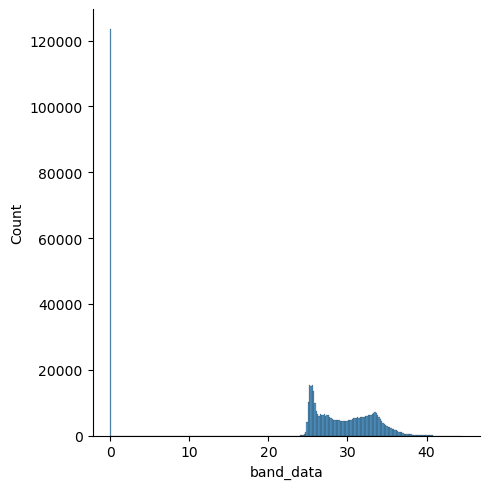

In [155]:
# checking the data
sns.displot(df5['band_data'])

In [156]:
# replacing 0 with nan
df5.replace(0, np.nan, inplace=True)

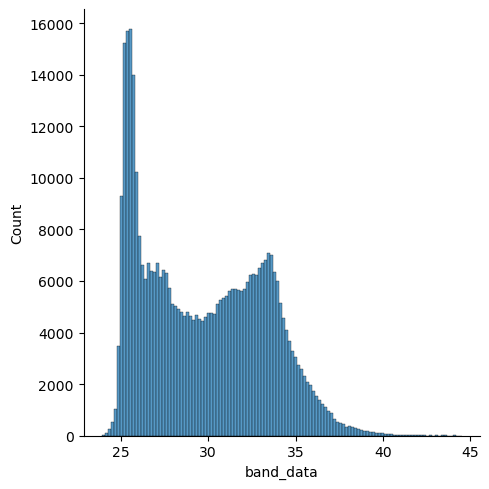

In [157]:
# checking the data
sns.displot(df5['band_data'])

In [158]:
# creating geometry 
geometry = [Point(xy) for xy in zip(df5.x, df5.y)]
# df = df.drop(['x', 'y'], axis=1)
gdf5 = GeoDataFrame(df5, crs="EPSG:32632", geometry=geometry)
gdf5

band         x          y  spatial_ref  band_data  \
0          1  462870.0  5533860.0          NaN  25.642796   
1          1  462870.0  5533830.0          NaN  25.578901   
2          1  462870.0  5533800.0          NaN  25.495598   
3          1  462870.0  5533770.0          NaN  25.428875   
4          1  462870.0  5533740.0          NaN  25.384352   
...      ...       ...        ...          ...        ...   
526677     1  488700.0  5515680.0          NaN        NaN   
526678     1  488700.0  5515650.0          NaN        NaN   
526679     1  488700.0  5515620.0          NaN        NaN   
526680     1  488700.0  5515590.0          NaN        NaN   
526681     1  488700.0  5515560.0          NaN        NaN   

                      geometry  
0       POINT (462870 5533860)  
1       POINT (462870 5533830)  
2       POINT (462870 5533800)  
3       POINT (462870 5533770)  
4       POINT (462870 5533740)  
...                        ...  
526677  POINT (488700 5515680)  
526678  POINT (488700 5515650)  
526679  POINT (488700 5515620)  
526680  POINT (488700 5515590)  
526681  POINT (488700 5515560)  

[526682 rows x 6 columns]

<Axes: >

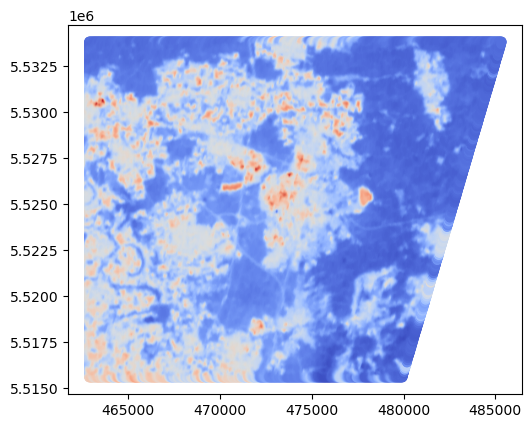

In [159]:
gdf5.plot(column='band_data', cmap='coolwarm')

<Axes: >

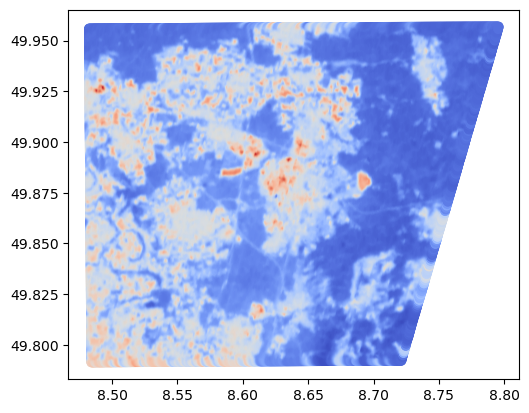

In [160]:
# changing crs to epsg:4326
gdf5.to_crs(crs='epsg:4326', inplace=True)
gdf5.plot(column='band_data', cmap='coolwarm')

In [161]:
# joining temp with hex9
gdf5_w_hex9 = gdf5.overlay(darm_hex9_fxd, how='intersection')
gdf5_w_hex9

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521800.0          NaN  31.776602  897a9321813ffff   
1          1  468300.0  5521770.0          NaN  31.702152  897a9321813ffff   
2          1  468300.0  5521740.0          NaN  31.696505  897a9321813ffff   
3          1  468300.0  5521710.0          NaN  31.730862  897a9321813ffff   
4          1  468300.0  5521680.0          NaN  31.722839  897a9321813ffff   
...      ...       ...        ...          ...        ...              ...   
135938     1  482070.0  5528040.0          NaN  25.145021  8963926cd93ffff   
135939     1  482070.0  5528010.0          NaN  25.100523  8963926cd93ffff   
135940     1  482070.0  5527980.0          NaN  25.072565  8963926cd93ffff   
135941     1  482070.0  5527950.0          NaN  25.039093  8963926cd93ffff   
135942     1  482100.0  5528070.0          NaN  25.133804  8963926cd93ffff   

                        geometry  
0       POINT (8.55907 49.84778)  
1       POINT (8.55907 49.84751)  
2       POINT (8.55907 49.84724)  
3       POINT (8.55907 49.84697)  
4        POINT (8.55908 49.8467)  
...                          ...  
135938  POINT (8.75031 49.90448)  
135939  POINT (8.75031 49.90421)  
135940  POINT (8.75031 49.90394)  
135941  POINT (8.75031 49.90367)  
135942  POINT (8.75073 49.90475)  

[135943 rows x 7 columns]

In [162]:
# calculating mean temp of hex9
gdf5_w_hex9_grp = gdf5_w_hex9.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf5_w_hex9_grp.rename(columns={"band_data": "HW_5"}, inplace=True)
gdf5_w_hex9_grp

hex_id       HW_5
0     8963926c323ffff  25.684700
1     8963926c327ffff  25.259813
2     8963926c32bffff  25.615698
3     8963926c32fffff  26.072378
4     8963926c333ffff  25.668648
...               ...        ...
2273  897a9366dcbffff  25.751553
2274  897a9366dcfffff  25.691660
2275  897a9366dd3ffff  25.631577
2276  897a9366dd7ffff  25.758768
2277  897a9366ddbffff  25.897484

[2278 rows x 2 columns]

In [163]:
pit9 = pit9.merge(gdf5_w_hex9_grp, on='hex_id')
pit9.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8963926d967ffff         NaN             NaN                    NaN   
1  8963926d96bffff         NaN             NaN                    NaN   
2  8963926d96fffff         NaN             NaN                    NaN   
3  8963926da2bffff         NaN             NaN             334.173365   
4  8963926da2fffff         NaN             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0            5998.331649              70.591067      6825.110809   
1              48.627892                    NaN              NaN   
2           11806.381376            7838.689081     11650.211475   
3            4867.465639                    NaN              NaN   
4                    NaN                    NaN              NaN   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                           5182.624977   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                                    NaN                    NaN   
3                                    NaN                    NaN   
4                                    NaN                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((477290.493 5526006.948, 477404.859 5...  53681.204005  29.838594   
1  POLYGON ((477149.611 5525546.057, 477263.994 5...  53692.410698  30.090197   
2  POLYGON ((477129.162 5525860.206, 477243.537 5...  53686.473523  31.541504   
3  POLYGON ((476465.019 5522926.877, 476579.491 5...  53754.404812  32.791145   
4  POLYGON ((476444.618 5523241.14, 476559.081 55...  53748.464832  30.724434   

        HW_2       HW_3       HW_4       HW_5  
0  38.552288  33.805782  35.329655  28.363529  
1  40.005802  38.112843  40.148472  30.232922  
2  40.954422  36.515518  38.647854  30.852018  
3  40.753078  35.644665  37.387890  29.111219  
4  38.766953  33.711040  35.695545  28.776838

In [164]:
# joining temp with hex8
gdf5_w_hex8 = gdf5.overlay(darm_hex8_fxd, how='intersection')
gdf5_w_hex8

band         x          y  spatial_ref  band_data           hex_id  \
0          1  468300.0  5521560.0          NaN  32.645889  887a932181fffff   
1          1  468300.0  5521530.0          NaN  33.155544  887a932181fffff   
2          1  468300.0  5521500.0          NaN  33.418583  887a932181fffff   
3          1  468300.0  5521470.0          NaN  33.442173  887a932181fffff   
4          1  468300.0  5521440.0          NaN  33.255756  887a932181fffff   
...      ...       ...        ...          ...        ...              ...   
136606     1  482070.0  5528220.0          NaN  25.131117  8863926cd9fffff   
136607     1  482070.0  5528190.0          NaN  25.128355  8863926cd9fffff   
136608     1  482070.0  5528160.0          NaN  25.111732  8863926cd9fffff   
136609     1  482070.0  5528130.0          NaN  25.133842  8863926cd9fffff   
136610     1  482070.0  5528100.0          NaN  25.172834  8863926cd9fffff   

                        geometry  
0       POINT (8.55909 49.84562)  
1       POINT (8.55909 49.84535)  
2       POINT (8.55909 49.84509)  
3       POINT (8.55909 49.84482)  
4        POINT (8.5591 49.84455)  
...                          ...  
136606    POINT (8.7503 49.9061)  
136607   POINT (8.7503 49.90583)  
136608   POINT (8.7503 49.90556)  
136609  POINT (8.75031 49.90529)  
136610  POINT (8.75031 49.90502)  

[136611 rows x 7 columns]

In [165]:
# calculating mean temp of hex8
gdf5_w_hex8_grp = gdf5_w_hex8.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf5_w_hex8_grp.rename(columns={"band_data": "HW_5"}, inplace=True)
gdf5_w_hex8_grp

hex_id       HW_5
0    8863926c33fffff  25.622465
1    8863926c81fffff  25.257402
2    8863926c83fffff  25.044233
3    8863926c85fffff  25.626329
4    8863926c87fffff  25.503389
..               ...        ...
322  887a9366d5fffff  25.453667
323  887a9366d7fffff  26.527212
324  887a9366d9fffff  26.676250
325  887a9366dbfffff  29.973534
326  887a9366ddfffff  25.681070

[327 rows x 2 columns]

In [166]:
pit8 = pit8.merge(gdf5_w_hex8_grp, on='hex_id')
pit8.head()

hex_id  EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8863926d97fffff         NaN             NaN                    NaN   
1  8863926da3fffff         NaN             NaN               1.402865   
2  8863926da7fffff         NaN             NaN           35070.086609   
3  8863926db1fffff         NaN             NaN                    NaN   
4  8863926db3fffff  922.635324             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           16621.459801            7528.525549     19959.579969   
1            4498.292880                    NaN              NaN   
2           20132.740288                    NaN     12414.954370   
3           79437.891126                    NaN      9377.362093   
4          153723.033194                    NaN      1692.195626   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                           6444.983305   
2                          14241.108956   
3                          16481.289669   
4                           8021.713419   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                            2172.225783                    NaN   
3                            5034.614558                    NaN   
4                                    NaN           13752.752536   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         625.885335                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4                NaN                   NaN               NaN   

                                            geometry       hex_area  \
0  POLYGON ((477129.162 5525860.206, 477404.859 5...  375809.985090   
1  POLYGON ((476444.618 5523241.14, 476720.562 55...  376243.911556   
2  POLYGON ((476141.968 5522633.251, 476417.982 5...  376359.341929   
3  POLYGON ((476524.472 5524644.846, 476800.31 55...  376040.701582   
4  POLYGON ((476301.86 5525440.669, 476577.663 55...  375952.890176   

        HW_1       HW_2       HW_3       HW_4       HW_5  
0  31.418055  40.754959  38.266575  39.740276  29.802946  
1  30.027418  37.968319  33.359394  35.053707  27.506592  
2  29.924324  38.008041  33.053688  34.657207  27.823254  
3  31.437441  40.381416  35.511772  37.490078  30.069221  
4  31.169531  40.260696  35.432758  37.357365  30.031340

In [167]:
# joining temp with hex7
gdf5_w_hex7 = gdf5.overlay(darm_hex7_fxd, how='intersection')
gdf5_w_hex7

band         x          y  spatial_ref  band_data           hex_id  \
0          1  467790.0  5521650.0          NaN  30.794834  877a93218ffffff   
1          1  467790.0  5521620.0          NaN  31.406616  877a93218ffffff   
2          1  467790.0  5521590.0          NaN  32.020802  877a93218ffffff   
3          1  467790.0  5521560.0          NaN  32.386795  877a93218ffffff   
4          1  467790.0  5521530.0          NaN  32.508804  877a93218ffffff   
...      ...       ...        ...          ...        ...              ...   
131402     1  482040.0  5528280.0          NaN  25.184027  8763926cdffffff   
131403     1  482040.0  5528250.0          NaN  25.234114  8763926cdffffff   
131404     1  482070.0  5528400.0          NaN  25.704115  8763926cdffffff   
131405     1  482070.0  5528370.0          NaN  25.534544  8763926cdffffff   
131406     1  482070.0  5528340.0          NaN  25.381603  8763926cdffffff   

                        geometry  
0       POINT (8.55199 49.84641)  
1       POINT (8.55199 49.84614)  
2       POINT (8.55199 49.84587)  
3        POINT (8.55199 49.8456)  
4         POINT (8.552 49.84533)  
...                          ...  
131402  POINT (8.74988 49.90663)  
131403  POINT (8.74988 49.90636)  
131404  POINT (8.75029 49.90771)  
131405  POINT (8.75029 49.90745)  
131406   POINT (8.7503 49.90718)  

[131407 rows x 7 columns]

In [168]:
# calculating mean temp of hex7
gdf5_w_hex7_grp = gdf5_w_hex7.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf5_w_hex7_grp.rename(columns={"band_data": "HW_5"}, inplace=True)
gdf5_w_hex7_grp

hex_id       HW_5
0   8763926c8ffffff  25.302622
1   8763926c9ffffff  25.553740
2   8763926caffffff  25.594120
3   8763926cbffffff  25.593603
4   8763926cdffffff  25.458624
5   8763926ceffffff  25.759106
6   8763926d8ffffff  26.020578
7   8763926d9ffffff  30.509882
8   8763926daffffff  26.121506
9   8763926dbffffff  29.635363
10  8763926ddffffff  25.543631
11  877a93218ffffff  32.066063
12  877a9321bffffff  28.973852
13  877a93282ffffff  32.861504
14  877a93283ffffff  31.114960
15  877a93288ffffff  34.282803
16  877a93289ffffff  31.116394
17  877a9328affffff  32.420502
18  877a9328bffffff  31.022959
19  877a9328cffffff  34.569988
20  877a9328dffffff  32.827930
21  877a9328effffff  33.357723
22  877a93291ffffff  30.341732
23  877a93298ffffff  32.628643
24  877a93299ffffff  29.735552
25  877a9329affffff  30.645151
26  877a9329bffffff  27.918968
27  877a9329cffffff  32.587387
28  877a9329dffffff  33.016529
29  877a9329effffff  30.762045
30  877a932abffffff  28.572786
31  877a932d0ffffff  28.001678
32  877a932d4ffffff  29.015947
33  877a932d5ffffff  30.038122
34  877a932d6ffffff  26.598867
35  877a932f0ffffff  26.659601
36  877a932f2ffffff  29.482412
37  877a932f3ffffff  29.694145
38  877a932f4ffffff  28.702579
39  877a932f6ffffff  27.628477
40  877a9364dffffff  27.991869
41  877a93668ffffff  25.449015
42  877a93669ffffff  25.752211
43  877a9366bffffff  25.523390
44  877a9366dffffff  27.057894

In [169]:
pit7 = pit7.merge(gdf5_w_hex7_grp, on='hex_id')
pit7.head()

hex_id   EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8763926d9ffffff          NaN             NaN                    NaN   
1  8763926daffffff          NaN             NaN           35071.489564   
2  8763926dbffffff  2184.358476    24387.049186                    NaN   
3  877a93283ffffff          NaN             NaN                    NaN   
4  877a93288ffffff  9881.342029             NaN                    NaN   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           10882.197440            4215.258953      9700.352304   
1           18563.273944                    NaN      8359.014671   
2          483684.259578            3209.713330     20795.953564   
3           19025.514696             152.324029     52366.232480   
4           36273.401777           28137.885941     24410.374269   

   EST3_row_structures_with_low_density  \
0                                   NaN   
1                          19423.655239   
2                          73978.330549   
3                          42133.740240   
4                         272346.726067   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN                    NaN   
1                            2172.225783                    NaN   
2                           14915.682503          122973.167321   
3                                    NaN                    NaN   
4                            6901.611633          292124.265546   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0                NaN                   NaN               NaN   
1                NaN                   NaN               NaN   
2                NaN                   NaN               NaN   
3                NaN                   NaN               NaN   
4       25460.653446           2203.494021      337451.38577   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((477431.335 5526467.807, 478231.741 5...  2.630477e+06  30.660500   
1  POLYGON ((476444.618 5523241.14, 477245.812 55...  2.634322e+06  28.538870   
2  POLYGON ((476301.86 5525440.669, 477102.642 55...  2.632285e+06  30.932590   
3  POLYGON ((473616.065 5529984.33, 474416.36 552...  2.629788e+06  32.202457   
4  POLYGON ((473898.837 5525586.162, 474699.958 5...  2.633865e+06  35.067825   

        HW_2       HW_3       HW_4       HW_5  
0  39.127792  37.202698  38.374813  30.509882  
1  36.090363  31.501644  32.758545  26.121506  
2  39.854946  35.403851  37.380898  29.635363  
3  42.909931  39.091614  40.924622  31.114960  
4  44.951012  38.729660  40.860596  34.282803

In [170]:
# joining temp with hex6
gdf5_w_hex6 = gdf5.overlay(darm_hex6_fxd, how='intersection')
gdf5_w_hex6

band         x          y  spatial_ref  band_data           hex_id  \
0          1  466650.0  5520930.0          NaN  32.095222  867a9321fffffff   
1          1  466650.0  5520900.0          NaN  32.654419  867a9321fffffff   
2          1  466650.0  5520870.0          NaN  32.860390  867a9321fffffff   
3          1  466650.0  5520840.0          NaN  32.693748  867a9321fffffff   
4          1  466650.0  5520810.0          NaN  32.365479  867a9321fffffff   
...      ...       ...        ...          ...        ...              ...   
157386     1  482070.0  5528220.0          NaN  25.131117  8663926cfffffff   
157387     1  482070.0  5528190.0          NaN  25.128355  8663926cfffffff   
157388     1  482070.0  5528160.0          NaN  25.111732  8663926cfffffff   
157389     1  482070.0  5528130.0          NaN  25.133842  8663926cfffffff   
157390     1  482070.0  5528100.0          NaN  25.172834  8663926cfffffff   

                        geometry  
0       POINT (8.53619 49.83987)  
1        POINT (8.53619 49.8396)  
2        POINT (8.5362 49.83933)  
3        POINT (8.5362 49.83906)  
4        POINT (8.5362 49.83879)  
...                          ...  
157386    POINT (8.7503 49.9061)  
157387   POINT (8.7503 49.90583)  
157388   POINT (8.7503 49.90556)  
157389  POINT (8.75031 49.90529)  
157390  POINT (8.75031 49.90502)  

[157391 rows x 7 columns]

In [171]:
# calculating mean temp of hex6
gdf5_w_hex6_grp = gdf5_w_hex6.groupby(['hex_id'], as_index=False)['band_data'].mean()
gdf5_w_hex6_grp.rename(columns={"band_data": "HW_5"}, inplace=True)
gdf5_w_hex6_grp

hex_id       HW_5
0  8663926cfffffff  25.506817
1  8663926dfffffff  27.551323
2  867a9321fffffff  31.789268
3  867a9328fffffff  32.837048
4  867a9329fffffff  30.992100
5  867a932d7ffffff  27.634981
6  867a932f7ffffff  28.693329
7  867a9366fffffff  25.980944

In [172]:
pit6 = pit6.merge(gdf5_w_hex6_grp, on='hex_id')
pit6.head()

hex_id     EST11_park  EST12_cemetary  EST13_alloment_garden  \
0  8663926dfffffff     922.802293    50699.605012           35071.489564   
1  867a9328fffffff  267940.237753    98431.234978          211485.325680   
2  867a9329fffffff   19996.898504             NaN          308957.288471   
3  867a932d7ffffff            NaN             NaN           22035.917625   
4  867a932f7ffffff            NaN             NaN           59216.594967   

   EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
0           6.199572e+05           39433.028030     65086.762080   
1           1.178889e+06          187608.050612    337257.313423   
2           9.743059e+05           39714.384270    643544.088894   
3           1.224552e+06           39401.843208    255943.403644   
4           4.229011e+05            2265.117032    141305.821266   

   EST3_row_structures_with_low_density  \
0                          7.795645e+04   
1                          1.261975e+06   
2                          3.160614e+05   
3                          3.428828e+05   
4                          5.775835e+04   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                           12968.175348           5.878773e+04   
1                           52839.505825           1.569654e+06   
2                          249408.171816                    NaN   
3                           31420.537407                    NaN   
4                            8997.551939                    NaN   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
0         627.097848                   NaN               NaN   
1      294554.184609          31247.772468     345095.237183   
2      611503.156937                   NaN               NaN   
3      416284.831704                   NaN               NaN   
4      208036.456458                   NaN               NaN   

                                            geometry      hex_area       HW_1  \
0  POLYGON ((476301.86 5525440.669, 478231.741 55...  1.842759e+07  29.327410   
1  POLYGON ((472626.528 5526759.169, 474558.114 5...  1.843705e+07  33.737103   
2  POLYGON ((474745.518 5531010.176, 476673.664 5...  1.839748e+07  31.742964   
3  POLYGON ((474181.965 5521185.811, 476115.288 5...  1.846719e+07  29.824053   
4  POLYGON ((470501.92 5522505.6, 472436.951 5523...  1.847668e+07  30.735737   

        HW_2       HW_3       HW_4       HW_5  
0  37.344666  33.491508  34.755138  27.551323  
1  43.723404  38.011215  40.049339  32.837048  
2  42.106445  37.491119  38.881802  30.992100  
3  38.124653  34.045586  35.631004  27.634981  
4  39.870174  34.877201  36.444481  28.693329

In [173]:
# joining temp with districts
gdf5_w_Dist = gdf5.overlay(darmstadt_std_shp, how='intersection')
gdf5_w_Dist

band         x          y  spatial_ref  band_data  OBJECTID  \
0          1  468240.0  5521830.0          NaN  32.606564        36   
1          1  468270.0  5521830.0          NaN  32.140480        36   
2          1  468270.0  5521800.0          NaN  32.050121        36   
3          1  468270.0  5521770.0          NaN  31.920187        36   
4          1  468270.0  5521740.0          NaN  31.848104        36   
...      ...       ...        ...          ...        ...       ...   
135557     1  482010.0  5527740.0          NaN  24.818666         7   
135558     1  482010.0  5527710.0          NaN  24.874537         7   
135559     1  482010.0  5527680.0          NaN  24.974941         7   
135560     1  482040.0  5527950.0          NaN  24.966583         7   
135561     1  482040.0  5527920.0          NaN  24.907948         7   

            Entity Layer  Color    Linetype  Elevation  LineWt RefName  \
0       LWPolyline  1001      7  Continuous        0.0      25    None   
1       LWPolyline  1001      7  Continuous        0.0      25    None   
2       LWPolyline  1001      7  Continuous        0.0      25    None   
3       LWPolyline  1001      7  Continuous        0.0      25    None   
4       LWPolyline  1001      7  Continuous        0.0      25    None   
...            ...   ...    ...         ...        ...     ...     ...   
135557  LWPolyline  1001      7  Continuous        0.0      25    None   
135558  LWPolyline  1001      7  Continuous        0.0      25    None   
135559  LWPolyline  1001      7  Continuous        0.0      25    None   
135560  LWPolyline  1001      7  Continuous        0.0      25    None   
135561  LWPolyline  1001      7  Continuous        0.0      25    None   

                   Name_Bezir    Shape_Leng    Shape_Area  \
0       540 Am Kavalleriesand  17662.149836  1.146508e+07   
1       540 Am Kavalleriesand  17662.149836  1.146508e+07   
2       540 Am Kavalleriesand  17662.149836  1.146508e+07   
3       540 Am Kavalleriesand  17662.149836  1.146508e+07   
4       540 Am Kavalleriesand  17662.149836  1.146508e+07   
...                       ...           ...           ...   
135557        310 Am Oberfeld  20788.406205  1.920096e+07   
135558        310 Am Oberfeld  20788.406205  1.920096e+07   
135559        310 Am Oberfeld  20788.406205  1.920096e+07   
135560        310 Am Oberfeld  20788.406205  1.920096e+07   
135561        310 Am Oberfeld  20788.406205  1.920096e+07   

                        geometry  
0       POINT (8.55823 49.84805)  
1       POINT (8.55865 49.84805)  
2       POINT (8.55865 49.84778)  
3       POINT (8.55865 49.84751)  
4       POINT (8.55865 49.84724)  
...                          ...  
135557  POINT (8.74949 49.90178)  
135558  POINT (8.74949 49.90151)  
135559  POINT (8.74949 49.90124)  
135560   POINT (8.7499 49.90367)  
135561    POINT (8.7499 49.9034)  

[135562 rows x 17 columns]

In [174]:
# calculating mean temp of hex6
gdf5_w_Dist_grp = gdf5_w_Dist.groupby(['Name_Bezir'], as_index=False)['band_data'].mean()
gdf5_w_Dist_grp.rename(columns={"band_data": "HW_5"}, inplace=True)
gdf5_w_Dist_grp

Name_Bezir       HW_5
0                     110 Stadtzentrum  35.082062
1            120 Rheintor/Grafenstraße  34.778698
2                 130 Hochschulviertel  32.837387
3               140 Kapellplatzviertel  33.010876
4   150 St. Ludwig mit Eichbergviertel  32.575256
5                  210 Johannesviertel  33.433140
6              220 Martinsviertel-West  32.864468
7               230 Martinsviertel-Ost  32.190651
8                      240 Waldkolonie  30.989313
9                  250 Mornewegviertel  34.957306
10             260 Pallaswiesenviertel  34.667313
11                  270 Am Ziegelbusch  31.227289
12                     310 Am Oberfeld  26.610802
13                   320 Mathildenhöhe  31.594139
14                    330 Woogsviertel  30.972862
15              340 An den Lichtwiesen  26.559093
16                   410 Paulusviertel  30.049833
17                   420 Alt-Bessungen  32.125256
18              430 An der Ludwigshöhe  27.029154
19                440 Lincoln-Siedlung  30.971512
20                   510 Am Südbahnhof  31.813532
21             520 Heimstättensiedlung  31.218668
22                 530 Verlegerviertel  33.337086
23               540 Am Kavalleriesand  29.971233
24                   610 Alt-Arheilgen  33.018524
25                   620 Arheilgen-Süd  32.429684
26                  630 Arheilgen-West  31.210276
27                   640 Arheilgen-Ost  31.784651
28                   710 Alt-Eberstadt  30.268904
29                 720 Am Lämmchesberg  29.038872
30                   730 Villenkolonie  27.815395
31                 740 Am Frankenstein  27.577227
32             750 Kirchtannensiedlung  29.419168
33                  810 Wixhausen-West  32.365189
34                   820 Wixhausen-Ost  27.435259
35                910 Kranichstein-Süd  30.424271
36               920 Kranichstein-Nord  26.772659

In [175]:
pitD_small = pitD_small.merge(gdf5_w_Dist_grp, on='Name_Bezir')
pitD_small.head()

Name_Bezir     EST11_park  EST12_cemetary  \
0                    110 Stadtzentrum    7370.186849             NaN   
1           120 Rheintor/Grafenstraße            NaN             NaN   
2                130 Hochschulviertel  113671.235126             NaN   
3              140 Kapellplatzviertel       1.259645             NaN   
4  150 St. Ludwig mit Eichbergviertel            NaN             NaN   

   EST13_alloment_garden  EST1A_detached_houses  EST1B_detached_houses  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN           11748.238663           33491.589152   
4                    NaN           37064.281641           20746.521595   

   EST2_row_houses  EST3_row_structures_with_low_density  \
0              NaN                                   NaN   
1              NaN                                   NaN   
2              NaN                                   NaN   
3      9814.215928                          51467.207186   
4     21350.298699                         187793.734718   

   EST4_row_structures_with_high_density  EST5_block_structures  \
0                                    NaN           24185.537025   
1                                    NaN                    NaN   
2                                    NaN           30495.437374   
3                                    NaN          170223.321769   
4                                    NaN          187282.062266   

   EST6_rural_houses  EST7_historic_centre  EST8_city_centre      Dist_area  \
0                NaN          23495.041093     112451.093688  299855.114999   
1                NaN                   NaN     231176.416702  398359.549998   
2                NaN                   NaN               NaN  414414.554998   
3        1391.841472           7752.731375       1467.726794  496346.624997   
4       22669.619786                   NaN               NaN  719066.379996   

        HW_1       HW_2       HW_3       HW_4       HW_5  
0  35.800507  45.670071  39.336338  41.295170  35.082062  
1  35.462467  45.641220  39.039982  41.081863  34.778698  
2  33.821999  43.415585  38.105221  40.093166  32.837387  
3  34.337162  43.720726  37.693356  39.781208  33.010876  
4  33.851768  43.267216  37.510578  39.568790  32.575256

In [176]:
# merging all hexes into a final dataframe
df_final = pd.concat([pit9, pit8])
df_final = pd.concat([df_final, pit7])
df_final = pd.concat([df_final, pit6])
df_final.describe()

EST11_park  EST12_cemetary  EST13_alloment_garden  \
count      48.000000       18.000000             120.000000   
mean    24071.665395    33140.175796           21225.582726   
std     44290.103100    35041.518742           41383.811616   
min        27.376142      712.930730               0.016703   
25%      2652.466838     7541.612949            2687.333589   
50%      7812.114824    21811.172835            7748.325049   
75%     21567.128662    48964.438585           20480.658002   
max    267940.237753   124743.666871          308957.288471   

       EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
count           4.670000e+02             134.000000       365.000000   
mean            3.846586e+04            9206.639542     16104.007597   
std             1.147904e+05           20879.870983     45311.442122   
min             6.870151e-01               0.000333         0.436134   
25%             4.024952e+03            1106.332104      1708.392909   
50%             1.168334e+04            2534.331715      5258.852313   
75%             2.983529e+04            7278.451444     12860.038730   
max             1.224552e+06          187608.050612    643544.088894   

       EST3_row_structures_with_low_density  \
count                          3.800000e+02   
mean                           2.257767e+04   
std                            7.796668e+04   
min                            5.650937e+00   
25%                            2.203052e+03   
50%                            7.394624e+03   
75%                            1.791424e+04   
max                            1.261975e+06   

       EST4_row_structures_with_high_density  EST5_block_structures  \
count                             122.000000           1.340000e+02   
mean                            13592.542816           4.861022e+04   
std                             27633.637625           1.521951e+05   
min                                 2.091553           1.065440e-01   
25%                              1649.856050           6.313515e+03   
50%                              5796.444265           1.869611e+04   
75%                             13549.105800           3.418583e+04   
max                            249408.171816           1.569654e+06   

       EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
count         167.000000             11.000000         28.000000   
mean        36670.796170          11362.826364      49299.322064   
std         78800.983799           8849.602454      92107.144302   
min             0.117580           1954.208710        639.989810   
25%          3151.959401           3164.522724       3940.279346   
50%         10740.334071          11592.889673      12559.443395   
75%         32568.222309          15125.813150      37885.254528   
max        611503.156937          31247.772468     345095.237183   

           hex_area        HW_1        HW_2        HW_3        HW_4  \
count  7.240000e+02  724.000000  724.000000  724.000000  724.000000   
mean   3.188349e+05   32.461212   42.024445   36.892212   38.812798   
std    1.582956e+06    1.742874    2.271695    1.914039    2.036106   
min    5.362902e+04   28.151941   35.915848   31.163012   32.758545   
25%    5.371066e+04   31.220270   40.465885   35.659756   37.576412   
50%    5.377548e+04   32.518557   42.225473   37.211077   39.115875   
75%    5.388264e+04   33.732917   43.667551   38.293626   40.250546   
max    1.847668e+07   38.736378   49.649895   42.668457   45.286800   

             HW_5  
count  724.000000  
mean    31.288393  
std      2.140084  
min     25.936232  
25%     29.910345  
50%     31.333417  
75%     32.829901  
max     39.487125

In [177]:
# computing city wide temperature 
h1 = gdf1.overlay(darm_dslv, how='intersection')
h1_grp = h1.groupby(['band'], as_index=False)['band_data'].mean()
print('H1', h1_grp.band_data[0])

h2 = gdf2.overlay(darm_dslv, how='intersection')
h2_grp = h2.groupby(['band'], as_index=False)['band_data'].mean()
print('H2', h2_grp.band_data[0])

h3 = gdf3.overlay(darm_dslv, how='intersection')
h3_grp = h3.groupby(['band'], as_index=False)['band_data'].mean()
print('H3', h3_grp.band_data[0])

h4 = gdf4.overlay(darm_dslv, how='intersection')
h4_grp = h4.groupby(['band'], as_index=False)['band_data'].mean()
print('H4', h4_grp.band_data[0])
      
h5 = gdf5.overlay(darm_dslv, how='intersection')
h5_grp = h5.groupby(['band'], as_index=False)['band_data'].mean()
print('H5', h5_grp.band_data[0])

H1 30.561342
H2 39.846935
H3 35.314964
H4 36.704945
H5 29.028418


In [178]:
# adding city wide temp to the dataframe
df_final['HW1_city'] = h1_grp.band_data[0]
df_final['HW2_city'] = h2_grp.band_data[0]
df_final['HW3_city'] = h3_grp.band_data[0]
df_final['HW4_city'] = h4_grp.band_data[0]
df_final['HW5_city'] = h5_grp.band_data[0]

# adding city wide temp to the district dataframe
pitD_small['HW1_city'] = h1_grp.band_data[0]
pitD_small['HW2_city'] = h2_grp.band_data[0]
pitD_small['HW3_city'] = h3_grp.band_data[0]
pitD_small['HW4_city'] = h4_grp.band_data[0]
pitD_small['HW5_city'] = h5_grp.band_data[0]

In [179]:
df_final.describe()

EST11_park  EST12_cemetary  EST13_alloment_garden  \
count      48.000000       18.000000             120.000000   
mean    24071.665395    33140.175796           21225.582726   
std     44290.103100    35041.518742           41383.811616   
min        27.376142      712.930730               0.016703   
25%      2652.466838     7541.612949            2687.333589   
50%      7812.114824    21811.172835            7748.325049   
75%     21567.128662    48964.438585           20480.658002   
max    267940.237753   124743.666871          308957.288471   

       EST1A_detached_houses  EST1B_detached_houses  EST2_row_houses  \
count           4.670000e+02             134.000000       365.000000   
mean            3.846586e+04            9206.639542     16104.007597   
std             1.147904e+05           20879.870983     45311.442122   
min             6.870151e-01               0.000333         0.436134   
25%             4.024952e+03            1106.332104      1708.392909   
50%             1.168334e+04            2534.331715      5258.852313   
75%             2.983529e+04            7278.451444     12860.038730   
max             1.224552e+06          187608.050612    643544.088894   

       EST3_row_structures_with_low_density  \
count                          3.800000e+02   
mean                           2.257767e+04   
std                            7.796668e+04   
min                            5.650937e+00   
25%                            2.203052e+03   
50%                            7.394624e+03   
75%                            1.791424e+04   
max                            1.261975e+06   

       EST4_row_structures_with_high_density  EST5_block_structures  \
count                             122.000000           1.340000e+02   
mean                            13592.542816           4.861022e+04   
std                             27633.637625           1.521951e+05   
min                                 2.091553           1.065440e-01   
25%                              1649.856050           6.313515e+03   
50%                              5796.444265           1.869611e+04   
75%                             13549.105800           3.418583e+04   
max                            249408.171816           1.569654e+06   

       EST6_rural_houses  EST7_historic_centre  EST8_city_centre  \
count         167.000000             11.000000         28.000000   
mean        36670.796170          11362.826364      49299.322064   
std         78800.983799           8849.602454      92107.144302   
min             0.117580           1954.208710        639.989810   
25%          3151.959401           3164.522724       3940.279346   
50%         10740.334071          11592.889673      12559.443395   
75%         32568.222309          15125.813150      37885.254528   
max        611503.156937          31247.772468     345095.237183   

           hex_area        HW_1        HW_2        HW_3        HW_4  \
count  7.240000e+02  724.000000  724.000000  724.000000  724.000000   
mean   3.188349e+05   32.461212   42.024445   36.892212   38.812798   
std    1.582956e+06    1.742874    2.271695    1.914039    2.036106   
min    5.362902e+04   28.151941   35.915848   31.163012   32.758545   
25%    5.371066e+04   31.220270   40.465885   35.659756   37.576412   
50%    5.377548e+04   32.518557   42.225473   37.211077   39.115875   
75%    5.388264e+04   33.732917   43.667551   38.293626   40.250546   
max    1.847668e+07   38.736378   49.649895   42.668457   45.286800   

             HW_5    HW1_city    HW2_city    HW3_city    HW4_city    HW5_city  
count  724.000000  724.000000  724.000000  724.000000  724.000000  724.000000  
mean    31.288393   30.561342   39.846931   35.314968   36.704948   29.028416  
std      2.140084    0.000000    0.000000    0.000000    0.000000    0.000000  
min     25.936232   30.561342   39.846935   35.314964   36.704945   29.028418  
25%     29.910345   30.561342   39.846935   35.314964   36.704945   29.02841

In [180]:
df_final.rename(columns={'EST11_park': "EST11", 'EST12_cemetary': "EST12", 'EST13_alloment_garden': "EST13",
       'EST1A_detached_houses': "EST1A", 'EST1B_detached_houses': "EST1B", 'EST2_row_houses': "EST2",
       'EST3_row_structures_with_low_density': "EST3", 'EST4_row_structures_with_high_density': "EST4", 
                         'EST5_block_structures': "EST5",
       'EST6_rural_houses': "EST6", 'EST7_historic_centre': "EST7", 'EST8_city_centre': "EST8" }, inplace=True)

In [183]:
pitD_small.rename(columns={'EST11_park': "EST11", 'EST12_cemetary': "EST12", 'EST13_alloment_garden': "EST13",
       'EST1A_detached_houses': "EST1A", 'EST1B_detached_houses': "EST1B", 'EST2_row_houses': "EST2",
       'EST3_row_structures_with_low_density': "EST3", 'EST4_row_structures_with_high_density': "EST4", 
                         'EST5_block_structures': "EST5",
       'EST6_rural_houses': "EST6", 'EST7_historic_centre': "EST7", 'EST8_city_centre': "EST8" }, inplace=True)

In [181]:
df_final.to_excel('../data/results/Darmstadt_typ_tmp_regression_data.xlsx')

In [184]:
pitD_small.to_excel('../data/results/Dist_w_typ&temp_area.xlsx')